<a href="https://colab.research.google.com/github/ashishpatel26/SRGAN_Keras_Tensorflow2/blob/main/SRGAN_MedicalMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !gdown --id 1LukOUfVNeps1Jj7Z27JbkmrO90jwBgie
# !pip install kora
# from kora import drive
# drive.download_folder('1LukOUfVNeps1Jj7Z27JbkmrO90jwBgie')

In [3]:
import zipfile
# !cp -R /content/drive/MyDrive/CropDermnetv2.zip /content/
def extract_zip(file_path="/content/img_align_celeba.zip"):
  zip_ref = zipfile.ZipFile(file_path, 'r')
  zip_ref.extractall("/content")
  zip_ref.close()

extract_zip()

In [5]:
# !ls /content/img_align_celeba

### Load Libraries

In [1]:
# !pip install scipy==1.1.0

In [4]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.misc import imread, imresize

### Residual Block

In [5]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

### Build Generator

In [6]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 1)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model


### Build Descriminator

In [7]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 1)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

### Build VGG19

In [8]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (256, 256, 1)

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.outputs = [vgg.layers[20].output]

    # Create a Keras model
    model = Model(vgg.input, vgg.outputs)
    return model


# def build_vgg():
#     """
#     Build VGG network to extract image features
#     """
#     input_shape = (256, 256, 3)

#     # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
#     vgg = VGG19(include_top=False, weights='imagenet')
#     vgg.outputs = [vgg.layers[20].output]

#     input_layer = Input(shape=input_shape)

#     # Extract features
#     features = vgg(input_layer)

#     # Create a Keras model
#     model = Model(inputs=[input_layer], outputs=[features])
#     return model

In [9]:
model = build_vgg()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Sample Images

In [10]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        # Do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

### Save Images

In [11]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)

### Write a Log

In [12]:
# def write_log(callback, name, value, batch_no):
#     """
#     Write scalars to Tensorboard
#     """
#     summary = tf.Summary()
#     summary_value = summary.value.add()
#     summary_value.simple_value = value
#     summary_value.tag = name
#     callback.writer.add_summary(summary, batch_no)
#     callback.writer.flush()

### Final SRGAN Execution

Epoch:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


d_loss: [0.32048114 0.4609375 ]
g_loss: [0.08400193601846695, 0.5994328856468201, 0.08340249955654144]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1
d_loss: [0.2447159 0.5625   ]
g_loss: [0.07555690407752991, 0.5756793022155762, 0.07498122751712799]
Epoch:2
d_loss: [0.2224782  0.71484375]
g_loss: [0.0710677057504654, 0.6291250586509705, 0.07043857872486115]
Epoch:3
d_loss: [0.11040443 0.83789062]
g_loss: [0.06530248373746872, 1.5466598272323608, 0.0637558251619339]
Epoch:4
d_loss: [0.05675756 0.95117188]
g_loss: [0.06182150915265083, 1.6382415294647217, 0.060183268040418625]
Epoch:5
d_loss: [0.16342746 0.72851562]
g_loss: [0.05755886808037758, 0.5999290943145752, 0.056958939880132675]
Epoch:6
d_loss: [0.13032851 0.8671875 ]
g_loss: [0.053022727370262146, 1.856289267539978, 0.051166437566280365]
Epoch:7
d_loss: [0.03202178 0.96875   ]
g_loss: [0.058840759098529816, 8.395598411560059, 0.050445158034563065]
Epoch:8
d_loss: [0.02040208 0.9921875 ]
g_loss: [0.05444192513823509, 10.542723655700684, 0.04389920085668564]
Epoch:9
d_loss: [0.00550585 1.        ]
g_loss: [0.056400418281555176, 9.930961608886719, 0.04646945744752884]
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.02518613263964653, 3.203625202178955, 0.021982507780194283]
Epoch:101
d_loss: [6.6214976e-04 1.0000000e+00]
g_loss: [0.034011613577604294, 3.995734691619873, 0.03001588024199009]
Epoch:102
d_loss: [9.14400043e-05 1.00000000e+00]
g_loss: [0.027168413624167442, 3.8671486377716064, 0.0233012642711401]
Epoch:103
d_loss: [9.38912781e-05 1.00000000e+00]
g_loss: [0.03164512664079666, 4.125692367553711, 0.027519434690475464]
Epoch:104
d_loss: [1.02525097e-04 1.00000000e+00]
g_loss: [0.030980413779616356, 3.4483113288879395, 0.027532102540135384]
Epoch:105
d_loss: [1.15070725e-04 1.00000000e+00]
g_loss: [0.029607398435473442, 4.5653767585754395, 0.02504202164709568]
Epoch:106
d_loss: [2.59143693e-04 1.00000000e+00]
g_loss: [0.03259434551000595, 5.107596397399902, 0.02748674899339676]
Epoch:107
d_loss: [9.69129069e-05 1.00000000e+00]
g_loss: [0.029948145151138306, 4.686642169952393, 0.02526150271296501]
Epoch:108
d_loss: [5.84746012e-05 1.00000000e+00]
g_loss: [0.03384559229016304, 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:201
d_loss: [1.99995987e-04 1.00000000e+00]
g_loss: [0.022159762680530548, 2.1429412364959717, 0.02001682110130787]
Epoch:202
d_loss: [1.52042728e-04 1.00000000e+00]
g_loss: [0.0276581272482872, 2.424374580383301, 0.02523375302553177]
Epoch:203
d_loss: [6.7685467e-05 1.0000000e+00]
g_loss: [0.020869746804237366, 2.244586229324341, 0.018625160679221153]
Epoch:204
d_loss: [5.13844971e-05 1.00000000e+00]
g_loss: [0.02280859649181366, 1.7293697595596313, 0.021079227328300476]
Epoch:205
d_loss: [4.48589999e-05 1.00000000e+00]
g_loss: [0.01715903729200363, 2.4025444984436035, 0.014756493270397186]
Epoch:206
d_loss: [6.72988335e-05 1.00000000e+00]
g_loss: [0.017893115058541298, 1.9362845420837402, 0.015956830233335495]
Epoch:207
d_loss: [5.85115413e-05 1.00000000e+00]
g_loss: [0.030141444876790047, 1.9152541160583496, 0.02822619117796421]
Epoch:208
d_loss: [1.30210359e-04 1.00000000e+00]
g_loss: [0.020880714058876038, 2.0593225955963135, 0.018821390345692635]
Epoch:209
d_loss: [1.672347

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.016298439353704453, 1.9475111961364746, 0.014350928366184235]
Epoch:301
d_loss: [2.52616319e-05 1.00000000e+00]
g_loss: [0.01136760599911213, 1.6926041841506958, 0.009675001725554466]
Epoch:302
d_loss: [2.64594328e-05 1.00000000e+00]
g_loss: [0.014181094244122505, 2.0830183029174805, 0.012098075821995735]
Epoch:303
d_loss: [2.73755941e-05 1.00000000e+00]
g_loss: [0.012494273483753204, 2.041708469390869, 0.010452564805746078]
Epoch:304
d_loss: [3.14742956e-05 1.00000000e+00]
g_loss: [0.012791474349796772, 1.7200348377227783, 0.01107143983244896]
Epoch:305
d_loss: [2.50030398e-05 1.00000000e+00]
g_loss: [0.013451263308525085, 1.630509853363037, 0.01182075310498476]
Epoch:306
d_loss: [2.97479228e-05 1.00000000e+00]
g_loss: [0.012356404215097427, 1.6298431158065796, 0.010726560838520527]
Epoch:307
d_loss: [6.03822609e-05 1.00000000e+00]
g_loss: [0.009576551616191864, 1.156587839126587, 0.008419963531196117]
Epoch:308
d_loss: [3.46156685e-05 1.00000000e+00]
g_loss: [0.01101263146

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:401
d_loss: [2.08080537e-05 1.00000000e+00]
g_loss: [0.00878401380032301, 0.2729474604129791, 0.008511066436767578]
Epoch:402
d_loss: [1.49102611e-05 1.00000000e+00]
g_loss: [0.015764091163873672, 0.320957213640213, 0.015443133190274239]
Epoch:403
d_loss: [1.44737487e-05 1.00000000e+00]
g_loss: [0.012689664959907532, 0.46588289737701416, 0.012223782017827034]
Epoch:404
d_loss: [1.05278959e-05 1.00000000e+00]
g_loss: [0.010489110834896564, 0.7112184166908264, 0.009777892380952835]
Epoch:405
d_loss: [1.40287038e-05 1.00000000e+00]
g_loss: [0.010979657992720604, 0.6952968835830688, 0.0102843614295125]
Epoch:406
d_loss: [1.45946419e-05 1.00000000e+00]
g_loss: [0.01131530199199915, 0.6449795961380005, 0.010670321993529797]
Epoch:407
d_loss: [1.22331862e-05 1.00000000e+00]
g_loss: [0.012388704344630241, 0.5211107730865479, 0.011867593973875046]
Epoch:408
d_loss: [1.05763484e-05 1.00000000e+00]
g_loss: [0.007545733358711004, 0.49987587332725525, 0.007045857608318329]
Epoch:409
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.009192196652293205, 0.5515579581260681, 0.008640638552606106]
Epoch:501
d_loss: [4.62213666e-06 1.00000000e+00]
g_loss: [0.011731022968888283, 0.654984712600708, 0.011076037771999836]
Epoch:502
d_loss: [7.32229216e-06 1.00000000e+00]
g_loss: [0.009843353182077408, 0.6505365371704102, 0.0091928169131279]
Epoch:503
d_loss: [5.12390284e-06 1.00000000e+00]
g_loss: [0.00943912286311388, 0.7496454119682312, 0.008689477108418941]
Epoch:504
d_loss: [1.12476537e-05 1.00000000e+00]
g_loss: [0.00739382253959775, 0.5650299191474915, 0.00682879239320755]
Epoch:505
d_loss: [5.92421679e-06 1.00000000e+00]
g_loss: [0.00550609827041626, 0.6259163618087769, 0.004880181979387999]
Epoch:506
d_loss: [9.77101718e-06 1.00000000e+00]
g_loss: [0.007331539411097765, 0.6997939944267273, 0.006631745491176844]
Epoch:507
d_loss: [1.15141554e-05 1.00000000e+00]
g_loss: [0.007615519221872091, 0.5454051494598389, 0.007070113904774189]
Epoch:508
d_loss: [8.88649947e-06 1.00000000e+00]
g_loss: [0.009487920440

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:601
d_loss: [5.63916637e-06 1.00000000e+00]
g_loss: [0.0070352982729673386, 0.34500932693481445, 0.00669028889387846]
Epoch:602
d_loss: [2.06631801e-05 1.00000000e+00]
g_loss: [0.004693649709224701, 0.2880820333957672, 0.004405567888170481]
Epoch:603
d_loss: [4.73271882e-06 1.00000000e+00]
g_loss: [0.0066621205769479275, 0.5213510394096375, 0.006140769459307194]
Epoch:604
d_loss: [3.11154736e-06 1.00000000e+00]
g_loss: [0.007203657645732164, 0.5842252969741821, 0.006619432475417852]
Epoch:605
d_loss: [6.11650944e-06 1.00000000e+00]
g_loss: [0.005654474720358849, 0.4822770059108734, 0.0051721977069973946]
Epoch:606
d_loss: [4.95581253e-06 1.00000000e+00]
g_loss: [0.005237313453108072, 0.4152941107749939, 0.0048220194876194]
Epoch:607
d_loss: [1.13504893e-05 1.00000000e+00]
g_loss: [0.010703734122216702, 0.33782416582107544, 0.010365909896790981]
Epoch:608
d_loss: [3.01920488e-06 1.00000000e+00]
g_loss: [0.005478885490447283, 0.5305691957473755, 0.004948316141963005]
Epoch:609
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.008488300256431103, 0.4810464382171631, 0.008007253520190716]
Epoch:701
d_loss: [3.50156097e-06 1.00000000e+00]
g_loss: [0.004815002903342247, 0.602796733379364, 0.004212206229567528]
Epoch:702
d_loss: [3.00812928e-06 1.00000000e+00]
g_loss: [0.00400918023660779, 0.5583117604255676, 0.0034508686512708664]
Epoch:703
d_loss: [2.78687003e-06 1.00000000e+00]
g_loss: [0.005555058363825083, 0.6272723078727722, 0.0049277860671281815]
Epoch:704
d_loss: [2.90486491e-06 1.00000000e+00]
g_loss: [0.006252746097743511, 0.6186457276344299, 0.005634100176393986]
Epoch:705
d_loss: [3.17914305e-06 1.00000000e+00]
g_loss: [0.0054306830279529095, 0.5302689671516418, 0.004900414030998945]
Epoch:706
d_loss: [3.10487781e-06 1.00000000e+00]
g_loss: [0.004512269515544176, 0.5884355306625366, 0.0039238338358700275]
Epoch:707
d_loss: [4.8405152e-06 1.0000000e+00]
g_loss: [0.007516065146774054, 0.5790485143661499, 0.006937016732990742]
Epoch:708
d_loss: [4.06968047e-06 1.00000000e+00]
g_loss: [0.00654

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:801
d_loss: [3.28050521e-06 1.00000000e+00]
g_loss: [0.00986956711858511, 0.4966290593147278, 0.009372938424348831]
Epoch:802
d_loss: [2.61202717e-06 1.00000000e+00]
g_loss: [0.004885104484856129, 0.45237278938293457, 0.00443273177370429]
Epoch:803
d_loss: [3.28305759e-06 1.00000000e+00]
g_loss: [0.0046427384950220585, 0.40961313247680664, 0.004233125131577253]
Epoch:804
d_loss: [3.67907285e-06 1.00000000e+00]
g_loss: [0.007686133496463299, 0.3786153793334961, 0.007307518273591995]
Epoch:805
d_loss: [3.64378252e-06 1.00000000e+00]
g_loss: [0.005581099074333906, 0.3815130591392517, 0.0051995860412716866]
Epoch:806
d_loss: [4.53528196e-06 1.00000000e+00]
g_loss: [0.005410791840404272, 0.419000506401062, 0.00499179121106863]
Epoch:807
d_loss: [3.66836207e-06 1.00000000e+00]
g_loss: [0.007670784369111061, 0.4283449649810791, 0.007242439314723015]
Epoch:808
d_loss: [5.31518072e-06 1.00000000e+00]
g_loss: [0.005212126299738884, 0.4594767987728119, 0.004752649459987879]
Epoch:809
d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.007646814454346895, 0.26086440682411194, 0.007385950069874525]
Epoch:901
d_loss: [2.53638768e-06 1.00000000e+00]
g_loss: [0.006183302029967308, 0.3747102618217468, 0.005808591842651367]
Epoch:902
d_loss: [3.21720438e-06 1.00000000e+00]
g_loss: [0.006537307519465685, 0.31225016713142395, 0.006225057411938906]
Epoch:903
d_loss: [2.29310649e-06 1.00000000e+00]
g_loss: [0.004759226460009813, 0.35771897435188293, 0.004401507321745157]
Epoch:904
d_loss: [7.48545915e-06 1.00000000e+00]
g_loss: [0.005727039650082588, 0.30760249495506287, 0.005419437307864428]
Epoch:905
d_loss: [2.35920618e-06 1.00000000e+00]
g_loss: [0.003727272152900696, 0.4598560035228729, 0.0032674160320311785]
Epoch:906
d_loss: [2.37971619e-06 1.00000000e+00]
g_loss: [0.006307748146355152, 0.4030458927154541, 0.005904702004045248]
Epoch:907
d_loss: [2.85042438e-06 1.00000000e+00]
g_loss: [0.004745247308164835, 0.3671775162220001, 0.004378069657832384]
Epoch:908
d_loss: [2.00185173e-06 1.00000000e+00]
g_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1001
d_loss: [1.81674073e-06 1.00000000e+00]
g_loss: [0.007263516075909138, 0.3653661012649536, 0.006898149847984314]
Epoch:1002
d_loss: [7.40016958e-06 1.00000000e+00]
g_loss: [0.00532707991078496, 0.26891446113586426, 0.005058165639638901]
Epoch:1003
d_loss: [3.43264787e-06 1.00000000e+00]
g_loss: [0.0025844417978078127, 0.1940036416053772, 0.002390438225120306]
Epoch:1004
d_loss: [7.28410555e-06 1.00000000e+00]
g_loss: [0.004015324171632528, 0.15108582377433777, 0.0038642382714897394]
Epoch:1005
d_loss: [2.19741526e-06 1.00000000e+00]
g_loss: [0.004147225990891457, 0.2324245572090149, 0.003914801403880119]
Epoch:1006
d_loss: [2.95095117e-06 1.00000000e+00]
g_loss: [0.005029251798987389, 0.18399678170681, 0.004845255054533482]
Epoch:1007
d_loss: [1.48632751e-06 1.00000000e+00]
g_loss: [0.0034108588006347418, 0.2888302206993103, 0.003122028661891818]
Epoch:1008
d_loss: [1.57609691e-06 1.00000000e+00]
g_loss: [0.0055777584202587605, 0.38844770193099976, 0.005189310759305954]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0037653492763638496, 0.5024054050445557, 0.003262943821027875]
Epoch:1101
d_loss: [1.58128535e-06 1.00000000e+00]
g_loss: [0.005694868974387646, 0.5252514481544495, 0.005169617477804422]
Epoch:1102
d_loss: [1.81671476e-06 1.00000000e+00]
g_loss: [0.004441371187567711, 0.5328603982925415, 0.003908510785549879]
Epoch:1103
d_loss: [1.84850558e-06 1.00000000e+00]
g_loss: [0.004134631250053644, 0.5255675911903381, 0.0036090638022869825]
Epoch:1104
d_loss: [1.48602487e-06 1.00000000e+00]
g_loss: [0.00371151533909142, 0.4303101897239685, 0.0032812051940709352]
Epoch:1105
d_loss: [5.55363681e-06 1.00000000e+00]
g_loss: [0.003734785132110119, 0.23898208141326904, 0.003495803102850914]
Epoch:1106
d_loss: [2.8630692e-06 1.0000000e+00]
g_loss: [0.006388195790350437, 0.23978140950202942, 0.006148414220660925]
Epoch:1107
d_loss: [2.50159724e-06 1.00000000e+00]
g_loss: [0.004871365614235401, 0.24864313006401062, 0.004622722510248423]
Epoch:1108
d_loss: [1.29763725e-06 1.00000000e+00]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.004499473609030247, 0.41759830713272095, 0.0040818750858306885]
Epoch:1201
d_loss: [2.20425375e-06 1.00000000e+00]
g_loss: [0.004162033554166555, 0.3878295123577118, 0.00377420405857265]
Epoch:1202
d_loss: [3.03417477e-06 1.00000000e+00]
g_loss: [0.004476536531001329, 0.3992443084716797, 0.004077292047441006]
Epoch:1203
d_loss: [1.553826e-06 1.000000e+00]
g_loss: [0.0040792254731059074, 0.29576680064201355, 0.0037834588438272476]
Epoch:1204
d_loss: [1.1865821e-06 1.0000000e+00]
g_loss: [0.005287099163979292, 0.2922801375389099, 0.004994818940758705]
Epoch:1205
d_loss: [2.586101e-06 1.000000e+00]
g_loss: [0.004155210684984922, 0.22465834021568298, 0.003930552396923304]
Epoch:1206
d_loss: [1.30419636e-06 1.00000000e+00]
g_loss: [0.0033628582023084164, 0.2424691617488861, 0.0031203890684992075]
Epoch:1207
d_loss: [2.37300219e-06 1.00000000e+00]
g_loss: [0.004272720776498318, 0.26171910762786865, 0.004011001903563738]
Epoch:1208
d_loss: [1.66089171e-06 1.00000000e+00]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1301
d_loss: [1.28339792e-06 1.00000000e+00]
g_loss: [0.004255954176187515, 0.25529828667640686, 0.0040006558410823345]
Epoch:1302
d_loss: [1.22232564e-06 1.00000000e+00]
g_loss: [0.005470276810228825, 0.28433579206466675, 0.005185940768569708]
Epoch:1303
d_loss: [1.30659123e-06 1.00000000e+00]
g_loss: [0.0030815068166702986, 0.38764965534210205, 0.002693857066333294]
Epoch:1304
d_loss: [1.21553211e-06 1.00000000e+00]
g_loss: [0.0038724106270819902, 0.33967918157577515, 0.0035327314399182796]
Epoch:1305
d_loss: [1.96630498e-06 1.00000000e+00]
g_loss: [0.0038523278199136257, 0.2599691152572632, 0.0035923586692661047]
Epoch:1306
d_loss: [1.03711436e-05 1.00000000e+00]
g_loss: [0.004129067063331604, 0.1526222825050354, 0.003976444713771343]
Epoch:1307
d_loss: [9.37324444e-07 1.00000000e+00]
g_loss: [0.00574000459164381, 0.29946455359458923, 0.00544054014608264]
Epoch:1308
d_loss: [4.06046092e-06 1.00000000e+00]
g_loss: [0.0055730328895151615, 0.2473241686820984, 0.005325708538293838

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0026794071309268475, 0.2592998743057251, 0.0024201073683798313]
Epoch:1401
d_loss: [1.1024035e-06 1.0000000e+00]
g_loss: [0.0046574813313782215, 0.25836724042892456, 0.004399114288389683]
Epoch:1402
d_loss: [1.0986592e-06 1.0000000e+00]
g_loss: [0.0034814835526049137, 0.29151302576065063, 0.0031899705063551664]
Epoch:1403
d_loss: [1.07758274e-06 1.00000000e+00]
g_loss: [0.005374686326831579, 0.32872438430786133, 0.005045962054282427]
Epoch:1404
d_loss: [9.56601866e-07 1.00000000e+00]
g_loss: [0.00421525165438652, 0.28064197301864624, 0.003934609703719616]
Epoch:1405
d_loss: [1.15935808e-06 1.00000000e+00]
g_loss: [0.005063996184617281, 0.304703950881958, 0.004759292118251324]
Epoch:1406
d_loss: [1.99688253e-06 1.00000000e+00]
g_loss: [0.004335997626185417, 0.2676265239715576, 0.004068370908498764]
Epoch:1407
d_loss: [3.93956805e-06 1.00000000e+00]
g_loss: [0.00635252520442009, 0.14279215037822723, 0.006209732964634895]
Epoch:1408
d_loss: [7.45208069e-07 1.00000000e+00]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.003477249527350068, 0.26639842987060547, 0.003210850991308689]
Epoch:1501
d_loss: [1.06578864e-06 1.00000000e+00]
g_loss: [0.005797897465527058, 0.4833206832408905, 0.005314576905220747]
Epoch:1502
d_loss: [7.73737014e-07 1.00000000e+00]
g_loss: [0.00255298032425344, 0.3465318977832794, 0.0022064484655857086]
Epoch:1503
d_loss: [2.29264538e-06 1.00000000e+00]
g_loss: [0.0028428114019334316, 0.36142468452453613, 0.0024813867639750242]
Epoch:1504
d_loss: [2.73540229e-06 1.00000000e+00]
g_loss: [0.0043088817037642, 0.24697156250476837, 0.0040619103237986565]
Epoch:1505
d_loss: [1.09560125e-06 1.00000000e+00]
g_loss: [0.004052675794810057, 0.30659571290016174, 0.0037460799794644117]
Epoch:1506
d_loss: [2.5821746e-06 1.0000000e+00]
g_loss: [0.002698618685826659, 0.20056596398353577, 0.002498052781447768]
Epoch:1507
d_loss: [7.28445087e-07 1.00000000e+00]
g_loss: [0.004030118230730295, 0.2719276249408722, 0.0037581906653940678]
Epoch:1508
d_loss: [8.81126141e-07 1.00000000e+00]
g_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1601
d_loss: [2.87517628e-06 1.00000000e+00]
g_loss: [0.00334102101624012, 0.32212358713150024, 0.0030188974924385548]
Epoch:1602
d_loss: [7.6719553e-07 1.0000000e+00]
g_loss: [0.0034468539524823427, 0.3330755829811096, 0.003113778308033943]
Epoch:1603
d_loss: [7.27211659e-06 1.00000000e+00]
g_loss: [0.002903344575315714, 0.19281834363937378, 0.002710526343435049]
Epoch:1604
d_loss: [3.2461287e-06 1.0000000e+00]
g_loss: [0.0028578191995620728, 0.24231255054473877, 0.0026155065279453993]
Epoch:1605
d_loss: [1.20897744e-06 1.00000000e+00]
g_loss: [0.004162912722676992, 0.22372791171073914, 0.0039391848258674145]
Epoch:1606
d_loss: [1.36011056e-06 1.00000000e+00]
g_loss: [0.003999896813184023, 0.2270866334438324, 0.0037728101015090942]
Epoch:1607
d_loss: [9.07060837e-07 1.00000000e+00]
g_loss: [0.0034115270245820284, 0.30116111040115356, 0.003110365942120552]
Epoch:1608
d_loss: [9.6888246e-07 1.0000000e+00]
g_loss: [0.002569920849055052, 0.32319381833076477, 0.00224672700278461]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.004786157049238682, 0.37064409255981445, 0.004415513016283512]
Epoch:1701
d_loss: [1.97462919e-06 1.00000000e+00]
g_loss: [0.002896373625844717, 0.28762897849082947, 0.0026087446603924036]
Epoch:1702
d_loss: [1.6012774e-06 1.0000000e+00]
g_loss: [0.0031743538565933704, 0.18371133506298065, 0.002990642562508583]
Epoch:1703
d_loss: [7.47768723e-07 1.00000000e+00]
g_loss: [0.003626483026891947, 0.21849708259105682, 0.0034079859033226967]
Epoch:1704
d_loss: [3.5202745e-06 1.0000000e+00]
g_loss: [0.003555270144715905, 0.23438897728919983, 0.00332088116556406]
Epoch:1705
d_loss: [3.13159455e-06 1.00000000e+00]
g_loss: [0.004880099091678858, 0.17033930122852325, 0.0047097597271203995]
Epoch:1706
d_loss: [2.4841233e-06 1.0000000e+00]
g_loss: [0.004244646523147821, 0.2150154411792755, 0.004029631149023771]
Epoch:1707
d_loss: [1.26870634e-06 1.00000000e+00]
g_loss: [0.003920828457921743, 0.4041121006011963, 0.003516716416925192]
Epoch:1708
d_loss: [7.64202497e-07 1.00000000e+00]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1801
d_loss: [1.43066552e-06 1.00000000e+00]
g_loss: [0.003124416572973132, 0.4526670277118683, 0.0026717495638877153]
Epoch:1802
d_loss: [1.05099261e-06 1.00000000e+00]
g_loss: [0.0031155652832239866, 0.30584031343460083, 0.0028097250033169985]
Epoch:1803
d_loss: [8.34008972e-07 1.00000000e+00]
g_loss: [0.0044885971583426, 0.3089384436607361, 0.004179658833891153]
Epoch:1804
d_loss: [1.13878284e-06 1.00000000e+00]
g_loss: [0.004415750037878752, 0.3308764398097992, 0.004084873478859663]
Epoch:1805
d_loss: [1.88144629e-06 1.00000000e+00]
g_loss: [0.003823001403361559, 0.3001261353492737, 0.003522875253111124]
Epoch:1806
d_loss: [1.3385706e-06 1.0000000e+00]
g_loss: [0.00446647685021162, 0.31347185373306274, 0.004153004847466946]
Epoch:1807
d_loss: [1.79702252e-06 1.00000000e+00]
g_loss: [0.0031568927224725485, 0.3100334107875824, 0.002846859395503998]
Epoch:1808
d_loss: [1.15481393e-06 1.00000000e+00]
g_loss: [0.0037298728711903095, 0.2964928150177002, 0.0034333800431340933]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04568900167942047, 1.283408522605896, 0.04440559446811676]
Epoch:1901
d_loss: [0.47298677 0.52734375]
g_loss: [0.04459498077630997, 1.0787590742111206, 0.04351622238755226]
Epoch:1902
d_loss: [0.46744102 0.53125   ]
g_loss: [0.043274376541376114, 0.6990311145782471, 0.04257534444332123]
Epoch:1903
d_loss: [0.45254452 0.54296875]
g_loss: [0.043032459914684296, 1.983263611793518, 0.04104919731616974]
Epoch:1904
d_loss: [0.46877408 0.53125   ]
g_loss: [0.04882335290312767, 2.0013248920440674, 0.04682202637195587]
Epoch:1905
d_loss: [0.45792292 0.5390625 ]
g_loss: [0.05269652232527733, 0.809231162071228, 0.05188729241490364]
Epoch:1906
d_loss: [0.46284193 0.53710938]
g_loss: [0.04372919723391533, 0.3434252142906189, 0.04338577017188072]
Epoch:1907
d_loss: [0.45222795 0.546875  ]
g_loss: [0.04104919359087944, 9.57100212417572e-08, 0.04104919359087944]
Epoch:1908
d_loss: [0.41817053 0.58203125]
g_loss: [0.0407448336482048, 0.005817692261189222, 0.040739014744758606]
Epoch:1909
d_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2001
d_loss: [0.42382875 0.57617188]
g_loss: [0.03564072772860527, 4.369745875010267e-05, 0.03564068302512169]
Epoch:2002
d_loss: [0.45328157 0.54492188]
g_loss: [0.03901265561580658, 4.237081157043576e-06, 0.03901265189051628]
Epoch:2003
d_loss: [0.44742593 0.55273438]
g_loss: [0.039276860654354095, 4.594775418809149e-06, 0.0392768569290638]
Epoch:2004
d_loss: [0.46577848 0.53320312]
g_loss: [0.043516140431165695, 1.3453654901240952e-05, 0.0435161255300045]
Epoch:2005
d_loss: [0.41022203 0.58984375]
g_loss: [0.040176872164011, 6.369416951201856e-05, 0.04017680883407593]
Epoch:2006
d_loss: [0.41635021 0.58398438]
g_loss: [0.040916603058576584, 0.00038527490687556565, 0.04091621935367584]
Epoch:2007
d_loss: [0.41038976 0.58984375]
g_loss: [0.0409560389816761, 0.00048536568647250533, 0.0409555546939373]
Epoch:2008
d_loss: [0.42165016 0.578125  ]
g_loss: [0.05188838392496109, 0.0011586900800466537, 0.05188722535967827]
Epoch:2009
d_loss: [0.44502369 0.55859375]
g_loss: [0.0418112128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044428758323192596, 6.630105531257868e-08, 0.044428758323192596]
Epoch:2101
d_loss: [0.36726415 0.6328125 ]
g_loss: [0.03843091428279877, 1.4873975828777475e-07, 0.03843091428279877]
Epoch:2102
d_loss: [0.399207   0.59960938]
g_loss: [0.042331255972385406, 1.4145578575153195e-07, 0.042331255972385406]
Epoch:2103
d_loss: [0.37948353 0.61914062]
g_loss: [0.04257524758577347, 1.4959007899051358e-07, 0.04257524758577347]
Epoch:2104
d_loss: [0.36725389 0.6328125 ]
g_loss: [0.044405385851860046, 3.6034148820363043e-07, 0.044405385851860046]
Epoch:2105
d_loss: [0.37889448 0.62109375]
g_loss: [0.035640597343444824, 1.06797369880951e-06, 0.035640597343444824]
Epoch:2106
d_loss: [0.37305624 0.62695312]
g_loss: [0.037444327026605606, 1.1337239129716181e-06, 0.037444327026605606]
Epoch:2107
d_loss: [0.39054135 0.609375  ]
g_loss: [0.045062389224767685, 8.411650753714639e-08, 0.045062389224767685]
Epoch:2108
d_loss: [0.38897309 0.59179688]
g_loss: [0.05796351283788681, 7.624155044555664,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2201
d_loss: [0.37869015 0.61914062]
g_loss: [0.029998188838362694, 5.026340659242123e-07, 0.029998188838362694]
Epoch:2202
d_loss: [0.37379418 0.62890625]
g_loss: [0.04915120452642441, 6.543262287550533e-08, 0.04915120452642441]
Epoch:2203
d_loss: [0.37369521 0.625     ]
g_loss: [0.04351605102419853, 8.82522144252107e-08, 0.04351605102419853]
Epoch:2204
d_loss: [0.37557851 0.62304688]
g_loss: [0.027223410084843636, 1.5597780134157802e-07, 0.027223410084843636]
Epoch:2205
d_loss: [0.37060544 0.63085938]
g_loss: [0.029998186975717545, 1.344903495237304e-07, 0.029998186975717545]
Epoch:2206
d_loss: [0.36724719 0.63476562]
g_loss: [0.029998186975717545, 1.1608746319780039e-07, 0.029998186975717545]
Epoch:2207
d_loss: [0.36525873 0.63476562]
g_loss: [0.028993379324674606, 7.620981534728344e-08, 0.028993379324674606]
Epoch:2208
d_loss: [0.37161691 0.62890625]
g_loss: [0.04017667472362518, 9.077776041976904e-08, 0.04017667472362518]
Epoch:2209
d_loss: [0.3649201  0.63476562]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044622752815485, 1.0626686162140686e-06, 0.044622752815485]
Epoch:2301
d_loss: [0.35547209 0.64453125]
g_loss: [0.044817205518484116, 1.5829612038942287e-06, 0.044817205518484116]
Epoch:2302
d_loss: [0.35547477 0.64453125]
g_loss: [0.04413323104381561, 2.313680852239486e-06, 0.044133227318525314]
Epoch:2303
d_loss: [0.35763191 0.64257812]
g_loss: [0.0475960448384285, 4.758678187499754e-06, 0.0475960411131382]
Epoch:2304
d_loss: [0.35565949 0.64453125]
g_loss: [0.03837845101952553, 4.606862603395712e-06, 0.03837844729423523]
Epoch:2305
d_loss: [0.35549706 0.64453125]
g_loss: [0.027223384007811546, 5.510111805051565e-06, 0.0272233784198761]
Epoch:2306
d_loss: [0.35548767 0.64453125]
g_loss: [0.04506230726838112, 5.377359229896683e-06, 0.04506230354309082]
Epoch:2307
d_loss: [0.35547085 0.64453125]
g_loss: [0.037503987550735474, 4.182178599876352e-06, 0.037503983825445175]
Epoch:2308
d_loss: [0.35547245 0.64453125]
g_loss: [0.0472438707947731, 4.169441581325373e-06, 0.047243867

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2401
d_loss: [0.3554697  0.64453125]
g_loss: [0.040738679468631744, 4.35375000051863e-07, 0.040738679468631744]
Epoch:2402
d_loss: [0.35546985 0.64453125]
g_loss: [0.042706556618213654, 5.551460162678268e-07, 0.042706556618213654]
Epoch:2403
d_loss: [0.35547159 0.64453125]
g_loss: [0.04095541313290596, 1.162017838396423e-06, 0.04095541313290596]
Epoch:2404
d_loss: [0.35548342 0.64453125]
g_loss: [0.043442364782094955, 2.067825789708877e-06, 0.04344236105680466]
Epoch:2405
d_loss: [0.35548298 0.64453125]
g_loss: [0.0468217171728611, 2.9826392164977733e-06, 0.0468217134475708]
Epoch:2406
d_loss: [0.35546953 0.64453125]
g_loss: [0.04440529644489288, 6.155320306788781e-07, 0.04440529644489288]
Epoch:2407
d_loss: [0.35546971 0.64453125]
g_loss: [0.038378432393074036, 8.129555908453767e-07, 0.038378432393074036]
Epoch:2408
d_loss: [0.3554695  0.64453125]
g_loss: [0.03893456980586052, 2.843534900875966e-07, 0.03893456980586052]
Epoch:2409
d_loss: [0.35548175 0.64453125]
g_loss: [0.04104

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04416781663894653, 4.1795911442932265e-07, 0.04416781663894653]
Epoch:2501
d_loss: [0.3554694  0.64453125]
g_loss: [0.0409160815179348, 6.747443421772914e-07, 0.0409160815179348]
Epoch:2502
d_loss: [0.35547384 0.64453125]
g_loss: [0.042575202882289886, 1.2206980954942992e-06, 0.042575202882289886]
Epoch:2503
d_loss: [0.35547343 0.64453125]
g_loss: [0.04338553547859192, 1.8839662061509443e-06, 0.04338553175330162]
Epoch:2504
d_loss: [0.35546912 0.64453125]
g_loss: [0.04915115237236023, 6.873448228361667e-07, 0.04915115237236023]
Epoch:2505
d_loss: [0.35547192 0.64453125]
g_loss: [0.03783800080418587, 1.2714634749499965e-06, 0.03783800080418587]
Epoch:2506
d_loss: [0.35546912 0.64453125]
g_loss: [0.04442868381738663, 4.847985906053509e-07, 0.04442868381738663]
Epoch:2507
d_loss: [0.35546937 0.64453125]
g_loss: [0.04388434439897537, 8.004477649592445e-07, 0.04388434439897537]
Epoch:2508
d_loss: [0.35547746 0.64453125]
g_loss: [0.03568325564265251, 1.942988546943525e-06, 0.03568

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2601
d_loss: [0.35547147 0.64453125]
g_loss: [0.04741879180073738, 1.3550015864893794e-06, 0.04741879180073738]
Epoch:2602
d_loss: [0.35547375 0.64453125]
g_loss: [0.04440527409315109, 2.064964746750775e-06, 0.044405270367860794]
Epoch:2603
d_loss: [0.35547046 0.64453125]
g_loss: [0.027223331853747368, 2.2433912363339914e-06, 0.02722332999110222]
Epoch:2604
d_loss: [0.35546904 0.64453125]
g_loss: [0.03900638967752457, 1.5539850437562563e-06, 0.03900638967752457]
Epoch:2605
d_loss: [0.35548069 0.64453125]
g_loss: [0.04233112186193466, 2.4621374450362055e-06, 0.04233111813664436]
Epoch:2606
d_loss: [0.35547056 0.64453125]
g_loss: [0.029998093843460083, 2.54819383371796e-06, 0.029998091980814934]
Epoch:2607
d_loss: [0.35546904 0.64453125]
g_loss: [0.03927673026919365, 1.5647437976440415e-06, 0.03927673026919365]
Epoch:2608
d_loss: [0.35546922 0.64453125]
g_loss: [0.03575475141406059, 1.436380330233078e-06, 0.03575475141406059]
Epoch:2609
d_loss: [0.35546952 0.64453125]
g_loss: [0.03

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04104897007346153, 2.6840245936909923e-06, 0.041048966348171234]
Epoch:2701
d_loss: [0.35547014 0.64453125]
g_loss: [0.040955379605293274, 2.6477607661945513e-06, 0.040955375880002975]
Epoch:2702
d_loss: [0.35547008 0.64453125]
g_loss: [0.04442867264151573, 2.599647359602386e-06, 0.04442866891622543]
Epoch:2703
d_loss: [0.35546999 0.64453125]
g_loss: [0.037362173199653625, 2.545318466218305e-06, 0.03736216947436333]
Epoch:2704
d_loss: [0.35547001 0.64453125]
g_loss: [0.03744419291615486, 2.3074808268574998e-06, 0.03744418919086456]
Epoch:2705
d_loss: [0.35546973 0.64453125]
g_loss: [0.027223320677876472, 1.0200980113950209e-06, 0.027223318815231323]
Epoch:2706
d_loss: [0.35547021 0.64453125]
g_loss: [0.0408690981566906, 1.4994391221989645e-06, 0.0408690981566906]
Epoch:2707
d_loss: [0.35549029 0.64453125]
g_loss: [0.040916066616773605, 2.7983737709291745e-06, 0.04091606289148331]
Epoch:2708
d_loss: [0.35548087 0.64453125]
g_loss: [0.04175136238336563, 3.717356776178349e-06, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2801
d_loss: [0.35546933 0.64453125]
g_loss: [0.03367403522133827, 8.906121138352319e-07, 0.03367403522133827]
Epoch:2802
d_loss: [0.35546922 0.64453125]
g_loss: [0.03893454745411873, 8.358991294699081e-07, 0.03893454745411873]
Epoch:2803
d_loss: [0.3554692  0.64453125]
g_loss: [0.03837839886546135, 3.734299127700069e-07, 0.03837839886546135]
Epoch:2804
d_loss: [0.3554693  0.64453125]
g_loss: [0.029998071491718292, 4.5205672449810663e-07, 0.029998071491718292]
Epoch:2805
d_loss: [0.3554692  0.64453125]
g_loss: [0.04346849024295807, 4.773049226969306e-07, 0.04346849024295807]
Epoch:2806
d_loss: [0.35546925 0.64453125]
g_loss: [0.04270650073885918, 6.32597107141919e-07, 0.04270650073885918]
Epoch:2807
d_loss: [0.35546985 0.64453125]
g_loss: [0.044487692415714264, 6.898379751874018e-07, 0.044487692415714264]
Epoch:2808
d_loss: [0.35546935 0.64453125]
g_loss: [0.043884314596652985, 6.870503739264677e-07, 0.043884314596652985]
Epoch:2809
d_loss: [0.35546914 0.64453125]
g_loss: [0.0375

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04085715860128403, 3.396928320853476e-07, 0.04085715860128403]
Epoch:2901
d_loss: [0.35547095 0.64453125]
g_loss: [0.042331092059612274, 7.464847158189514e-07, 0.042331092059612274]
Epoch:2902
d_loss: [0.35549563 0.64453125]
g_loss: [0.04460027813911438, 1.1233564691792708e-06, 0.04460027813911438]
Epoch:2903
d_loss: [0.35546936 0.64453125]
g_loss: [0.029998065903782845, 1.2307405086176004e-06, 0.029998064041137695]
Epoch:2904
d_loss: [0.35547028 0.64453125]
g_loss: [0.04429497942328453, 1.181770812763716e-06, 0.04429497942328453]
Epoch:2905
d_loss: [0.35546934 0.64453125]
g_loss: [0.04073861986398697, 1.120960860134801e-06, 0.04073861986398697]
Epoch:2906
d_loss: [0.35546913 0.64453125]
g_loss: [0.034102968871593475, 9.329821182291198e-07, 0.034102968871593475]
Epoch:2907
d_loss: [0.35546915 0.64453125]
g_loss: [0.0375039279460907, 8.184123316823388e-07, 0.0375039279460907]
Epoch:2908
d_loss: [0.35546911 0.64453125]
g_loss: [0.042331092059612274, 3.053980606182449e-07, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3001
d_loss: [0.35546902 0.64453125]
g_loss: [0.03901239484548569, 7.194681757027865e-07, 0.03901239484548569]
Epoch:3002
d_loss: [0.35546896 0.64453125]
g_loss: [0.04485480859875679, 3.656285798570025e-07, 0.04485480859875679]
Epoch:3003
d_loss: [0.35546896 0.64453125]
g_loss: [0.04346848651766777, 3.2781386494207254e-07, 0.04346848651766777]
Epoch:3004
d_loss: [0.35546898 0.64453125]
g_loss: [0.04448768123984337, 1.9880556578755204e-07, 0.04448768123984337]
Epoch:3005
d_loss: [0.35547039 0.64453125]
g_loss: [0.04741877689957619, 5.045221200816741e-07, 0.04741877689957619]
Epoch:3006
d_loss: [0.35546896 0.64453125]
g_loss: [0.044428661465644836, 2.098194471500392e-07, 0.044428661465644836]
Epoch:3007
d_loss: [0.35546899 0.64453125]
g_loss: [0.03410296514630318, 2.5241203616133134e-07, 0.03410296514630318]
Epoch:3008
d_loss: [0.35546979 0.64453125]
g_loss: [0.038430776447057724, 5.665283993039338e-07, 0.038430776447057724]
Epoch:3009
d_loss: [0.35547151 0.64453125]
g_loss: [0.044

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03410295769572258, 5.502372459886828e-07, 0.03410295769572258]
Epoch:3101
d_loss: [0.35546902 0.64453125]
g_loss: [0.053040605038404465, 6.027494805493916e-07, 0.053040605038404465]
Epoch:3102
d_loss: [0.35546896 0.64453125]
g_loss: [0.05033925548195839, 4.658342618313327e-07, 0.05033925548195839]
Epoch:3103
d_loss: [0.35546896 0.64453125]
g_loss: [0.041751351207494736, 3.7615237147292646e-07, 0.041751351207494736]
Epoch:3104
d_loss: [0.35546944 0.64453125]
g_loss: [0.04448767751455307, 5.205757815929246e-07, 0.04448767751455307]
Epoch:3105
d_loss: [0.35547081 0.64453125]
g_loss: [0.053040556609630585, 9.088496426556958e-07, 0.053040556609630585]
Epoch:3106
d_loss: [0.35547003 0.64453125]
g_loss: [0.04085712879896164, 9.614627742848825e-07, 0.04085712879896164]
Epoch:3107
d_loss: [0.35546899 0.64453125]
g_loss: [0.04429497569799423, 8.362493417735095e-07, 0.04429497569799423]
Epoch:3108
d_loss: [0.35546899 0.64453125]
g_loss: [0.04388429969549179, 7.819057827873621e-07, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3201
d_loss: [0.35546895 0.64453125]
g_loss: [0.05226004123687744, 1.1606800853769528e-06, 0.05226004123687744]
Epoch:3202
d_loss: [0.35546888 0.64453125]
g_loss: [0.05226004123687744, 8.889982154869358e-07, 0.05226004123687744]
Epoch:3203
d_loss: [0.35546897 0.64453125]
g_loss: [0.043884292244911194, 9.475606361775135e-07, 0.043884292244911194]
Epoch:3204
d_loss: [0.35546887 0.64453125]
g_loss: [0.04495770111680031, 3.165600332977192e-07, 0.04495770111680031]
Epoch:3205
d_loss: [0.35546892 0.64453125]
g_loss: [0.047822218388319016, 4.063793994646403e-07, 0.047822218388319016]
Epoch:3206
d_loss: [0.35546892 0.64453125]
g_loss: [0.047822218388319016, 4.054620035276457e-07, 0.047822218388319016]
Epoch:3207
d_loss: [0.35546887 0.64453125]
g_loss: [0.049151115119457245, 1.8447450145231414e-07, 0.049151115119457245]
Epoch:3208
d_loss: [0.35546887 0.64453125]
g_loss: [0.050957996398210526, 1.567017875458987e-07, 0.050957996398210526]
Epoch:3209
d_loss: [0.35546918 0.64453125]
g_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3301
d_loss: [0.35546947 0.64453125]
g_loss: [0.027223283424973488, 5.455885343508271e-07, 0.027223283424973488]
Epoch:3302
d_loss: [0.35546885 0.64453125]
g_loss: [0.044294971972703934, 5.139257837072364e-07, 0.044294971972703934]
Epoch:3303
d_loss: [0.3554689  0.64453125]
g_loss: [0.03901238366961479, 5.157942268851912e-07, 0.03901238366961479]
Epoch:3304
d_loss: [0.3554689  0.64453125]
g_loss: [0.03927670791745186, 5.46912133359001e-07, 0.03927670791745186]
Epoch:3305
d_loss: [0.35546886 0.64453125]
g_loss: [0.03893453627824783, 5.507204150489997e-07, 0.03893453627824783]
Epoch:3306
d_loss: [0.35546889 0.64453125]
g_loss: [0.04233107343316078, 5.427986593531386e-07, 0.04233107343316078]
Epoch:3307
d_loss: [0.35546895 0.64453125]
g_loss: [0.04481713846325874, 5.50948584532307e-07, 0.04481713846325874]
Epoch:3308
d_loss: [0.35546999 0.64453125]
g_loss: [0.04270647093653679, 9.20264653814229e-07, 0.04270647093653679]
Epoch:3309
d_loss: [0.35546885 0.64453125]
g_loss: [0.047243822

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.029998037964105606, 7.10370045453601e-07, 0.029998037964105606]
Epoch:3401
d_loss: [0.35546884 0.64453125]
g_loss: [0.052260033786296844, 1.8902848353263835e-07, 0.052260033786296844]
Epoch:3402
d_loss: [0.35546892 0.64453125]
g_loss: [0.041751351207494736, 2.7015093451154826e-07, 0.041751351207494736]
Epoch:3403
d_loss: [0.35546908 0.64453125]
g_loss: [0.03901237994432449, 4.282422594314994e-07, 0.03901237994432449]
Epoch:3404
d_loss: [0.35547075 0.64453125]
g_loss: [0.044167760759592056, 8.101778803393245e-07, 0.044167760759592056]
Epoch:3405
d_loss: [0.35546885 0.64453125]
g_loss: [0.03568322956562042, 6.668224727945926e-07, 0.03568322956562042]
Epoch:3406
d_loss: [0.35546884 0.64453125]
g_loss: [0.04724382236599922, 3.807883501849574e-07, 0.04724382236599922]
Epoch:3407
d_loss: [0.35546939 0.64453125]
g_loss: [0.04344231262803078, 6.249728130569565e-07, 0.04344231262803078]
Epoch:3408
d_loss: [0.35546911 0.64453125]
g_loss: [0.0375039167702198, 7.59697627472633e-07, 0.03

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3501
d_loss: [0.35546896 0.64453125]
g_loss: [0.035640403628349304, 5.502858471118088e-07, 0.035640403628349304]
Epoch:3502
d_loss: [0.35546887 0.64453125]
g_loss: [0.042302243411540985, 5.45193245216069e-07, 0.042302243411540985]
Epoch:3503
d_loss: [0.35546954 0.64453125]
g_loss: [0.04460027068853378, 6.056525876374508e-07, 0.04460027068853378]
Epoch:3504
d_loss: [0.35546883 0.64453125]
g_loss: [0.04086906835436821, 5.948108423581289e-07, 0.04086906835436821]
Epoch:3505
d_loss: [0.35546883 0.64453125]
g_loss: [0.031110089272260666, 6.469231834671518e-07, 0.031110089272260666]
Epoch:3506
d_loss: [0.35546934 0.64453125]
g_loss: [0.03568322956562042, 9.818047601584112e-07, 0.03568322956562042]
Epoch:3507
d_loss: [0.35546882 0.64453125]
g_loss: [0.028993243351578712, 6.743993594682252e-07, 0.028993243351578712]
Epoch:3508
d_loss: [0.35546897 0.64453125]
g_loss: [0.03367399796843529, 8.108252131933114e-07, 0.03367399796843529]
Epoch:3509
d_loss: [0.35546905 0.64453125]
g_loss: [0.047

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04351598024368286, 5.265711706670118e-07, 0.04351598024368286]
Epoch:3601
d_loss: [0.35546917 0.64453125]
g_loss: [0.04308558255434036, 5.906633191443689e-07, 0.04308558255434036]
Epoch:3602
d_loss: [0.35546882 0.64453125]
g_loss: [0.050339244306087494, 5.026234930483042e-07, 0.050339244306087494]
Epoch:3603
d_loss: [0.35546928 0.64453125]
g_loss: [0.05199441313743591, 7.377286124210514e-07, 0.05199441313743591]
Epoch:3604
d_loss: [0.35547746 0.64453125]
g_loss: [0.042575184255838394, 1.0722709475885495e-06, 0.042575184255838394]
Epoch:3605
d_loss: [0.3554689  0.64453125]
g_loss: [0.04846300184726715, 8.727744216230349e-07, 0.04846300184726715]
Epoch:3606
d_loss: [0.35546881 0.64453125]
g_loss: [0.04176724702119827, 6.870320135021757e-07, 0.04176724702119827]
Epoch:3607
d_loss: [0.35547024 0.64453125]
g_loss: [0.037837933748960495, 1.669481548560725e-06, 0.037837933748960495]
Epoch:3608
d_loss: [0.35546885 0.64453125]
g_loss: [0.03927670791745186, 6.091580075917591e-07, 0.03

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3701
d_loss: [0.35546879 0.64453125]
g_loss: [0.02722327411174774, 2.308184576804706e-07, 0.02722327411174774]
Epoch:3702
d_loss: [0.35546893 0.64453125]
g_loss: [0.035683225840330124, 3.009168949574814e-07, 0.035683225840330124]
Epoch:3703
d_loss: [0.35546907 0.64453125]
g_loss: [0.037362150847911835, 3.7465423474714044e-07, 0.037362150847911835]
Epoch:3704
d_loss: [0.35546879 0.64453125]
g_loss: [0.03602408617734909, 4.3504596192178724e-07, 0.03602408617734909]
Epoch:3705
d_loss: [0.35546894 0.64453125]
g_loss: [0.04682161659002304, 5.099019517729175e-07, 0.04682161659002304]
Epoch:3706
d_loss: [0.3554688  0.64453125]
g_loss: [0.04073859378695488, 4.4835857693215075e-07, 0.04073859378695488]
Epoch:3707
d_loss: [0.35546922 0.64453125]
g_loss: [0.04846300184726715, 6.388324891304364e-07, 0.04846300184726715]
Epoch:3708
d_loss: [0.35546886 0.64453125]
g_loss: [0.043922893702983856, 6.484348205049173e-07, 0.043922893702983856]
Epoch:3709
d_loss: [0.35546879 0.64453125]
g_loss: [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03927670419216156, 2.7245363298789016e-07, 0.03927670419216156]
Epoch:3801
d_loss: [0.35546944 0.64453125]
g_loss: [0.04495768994092941, 4.4353612338454695e-07, 0.04495768994092941]
Epoch:3802
d_loss: [0.35546879 0.64453125]
g_loss: [0.043922893702983856, 4.134791424803552e-07, 0.043922893702983856]
Epoch:3803
d_loss: [0.35546881 0.64453125]
g_loss: [0.03927670791745186, 4.336946517469187e-07, 0.03927670791745186]
Epoch:3804
d_loss: [0.35546879 0.64453125]
g_loss: [0.03744414448738098, 3.886441390932305e-07, 0.03744414448738098]
Epoch:3805
d_loss: [0.35546882 0.64453125]
g_loss: [0.04682159796357155, 3.820434244516946e-07, 0.04682159796357155]
Epoch:3806
d_loss: [0.35546974 0.64453125]
g_loss: [0.031110083684325218, 5.532405111807748e-07, 0.031110083684325218]
Epoch:3807
d_loss: [0.35546878 0.64453125]
g_loss: [0.028993239626288414, 2.2640622887593054e-07, 0.028993239626288414]
Epoch:3808
d_loss: [0.35546897 0.64453125]
g_loss: [0.038583625108003616, 3.5441840395833424e-07, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3901
d_loss: [0.35546878 0.64453125]
g_loss: [0.038583625108003616, 4.917382412372717e-08, 0.038583625108003616]
Epoch:3902
d_loss: [0.35546878 0.64453125]
g_loss: [0.03602408245205879, 3.6250963120210145e-08, 0.03602408245205879]
Epoch:3903
d_loss: [0.35546878 0.64453125]
g_loss: [0.04230223968625069, 7.969505588789616e-08, 0.04230223968625069]
Epoch:3904
d_loss: [0.35546878 0.64453125]
g_loss: [0.037917472422122955, 4.5334306975064464e-08, 0.037917472422122955]
Epoch:3905
d_loss: [0.35546888 0.64453125]
g_loss: [0.02999802678823471, 8.760143543895538e-08, 0.02999802678823471]
Epoch:3906
d_loss: [0.35546897 0.64453125]
g_loss: [0.037362150847911835, 2.137051353656716e-07, 0.037362150847911835]
Epoch:3907
d_loss: [0.35546879 0.64453125]
g_loss: [0.03900628536939621, 2.8293331411077816e-07, 0.03900628536939621]
Epoch:3908
d_loss: [0.35546886 0.64453125]
g_loss: [0.035683222115039825, 3.688694505399326e-07, 0.035683222115039825]
Epoch:3909
d_loss: [0.35546879 0.64453125]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03367398679256439, 2.1176536790790124e-07, 0.03367398679256439]
Epoch:4001
d_loss: [0.35546878 0.64453125]
g_loss: [0.047243814915418625, 1.7177671907120384e-07, 0.047243814915418625]
Epoch:4002
d_loss: [0.35546878 0.64453125]
g_loss: [0.04442864656448364, 1.2148515793342085e-07, 0.04442864656448364]
Epoch:4003
d_loss: [0.3554688  0.64453125]
g_loss: [0.04800284653902054, 1.7561148979439167e-07, 0.04800284653902054]
Epoch:4004
d_loss: [0.35546879 0.64453125]
g_loss: [0.03564039617776871, 2.430493282190582e-07, 0.03564039617776871]
Epoch:4005
d_loss: [0.35546885 0.64453125]
g_loss: [0.038583625108003616, 3.208434691259754e-07, 0.038583625108003616]
Epoch:4006
d_loss: [0.35546988 0.64453125]
g_loss: [0.042706459760665894, 5.143758130543574e-07, 0.042706459760665894]
Epoch:4007
d_loss: [0.35546879 0.64453125]
g_loss: [0.04708937183022499, 5.079814968667051e-07, 0.04708937183022499]
Epoch:4008
d_loss: [0.35546879 0.64453125]
g_loss: [0.052260030061006546, 3.8872084928698314e-07,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4101
d_loss: [0.35546876 0.64453125]
g_loss: [0.04462267830967903, 1.3450669200665288e-07, 0.04462267830967903]
Epoch:4102
d_loss: [0.35546875 0.64453125]
g_loss: [0.03367398679256439, 1.6757752518969937e-07, 0.03367398679256439]
Epoch:4103
d_loss: [0.35546875 0.64453125]
g_loss: [0.03893453627824783, 1.278004475580019e-07, 0.03893453627824783]
Epoch:4104
d_loss: [0.35546876 0.64453125]
g_loss: [0.028292318806052208, 1.8961958403451717e-07, 0.028292318806052208]
Epoch:4105
d_loss: [0.35546876 0.64453125]
g_loss: [0.04782221093773842, 2.2318914716379368e-07, 0.04782221093773842]
Epoch:4106
d_loss: [0.35546875 0.64453125]
g_loss: [0.04782221093773842, 9.323728988874791e-08, 0.04782221093773842]
Epoch:4107
d_loss: [0.35546876 0.64453125]
g_loss: [0.03602408245205879, 1.4515319435304264e-07, 0.03602408245205879]
Epoch:4108
d_loss: [0.35546876 0.64453125]
g_loss: [0.04235066846013069, 2.052088348136749e-07, 0.04235066846013069]
Epoch:4109
d_loss: [0.35546875 0.64453125]
g_loss: [0.044

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044487617909908295, 1.10391823682221e-07, 0.044487617909908295]
Epoch:4201
d_loss: [0.35546875 0.64453125]
g_loss: [0.0448547787964344, 4.6919154783608974e-08, 0.0448547787964344]
Epoch:4202
d_loss: [0.35546878 0.64453125]
g_loss: [0.04759599640965462, 9.268524081562646e-08, 0.04759599640965462]
Epoch:4203
d_loss: [0.35546875 0.64453125]
g_loss: [0.0390506349503994, 1.355029155547527e-07, 0.0390506349503994]
Epoch:4204
d_loss: [0.35546875 0.64453125]
g_loss: [0.04392288997769356, 8.52718358146376e-08, 0.04392288997769356]
Epoch:4205
d_loss: [0.35546916 0.64453125]
g_loss: [0.050339244306087494, 2.4930278641477344e-07, 0.050339244306087494]
Epoch:4206
d_loss: [0.35546875 0.64453125]
g_loss: [0.053037047386169434, 2.587632081940683e-07, 0.053037047386169434]
Epoch:4207
d_loss: [0.35546875 0.64453125]
g_loss: [0.03575468808412552, 1.1949443035064178e-07, 0.03575468808412552]
Epoch:4208
d_loss: [0.35546875 0.64453125]
g_loss: [0.04233105853199959, 1.5245011297793098e-07, 0.04233

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4301
d_loss: [0.35546882 0.64453125]
g_loss: [0.04448753222823143, 3.9180562794172147e-07, 0.04448753222823143]
Epoch:4302
d_loss: [0.35546875 0.64453125]
g_loss: [0.038934528827667236, 1.9198135703391017e-07, 0.038934528827667236]
Epoch:4303
d_loss: [0.35546875 0.64453125]
g_loss: [0.037837933748960495, 8.266046336302679e-08, 0.037837933748960495]
Epoch:4304
d_loss: [0.35546875 0.64453125]
g_loss: [0.05226006358861923, 1.2198377419281314e-07, 0.05226006358861923]
Epoch:4305
d_loss: [0.35547172 0.64453125]
g_loss: [0.026404568925499916, 2.3804780369118816e-07, 0.026404568925499916]
Epoch:4306
d_loss: [0.35546937 0.64453125]
g_loss: [0.05303359776735306, 3.8213312336665695e-07, 0.05303359776735306]
Epoch:4307
d_loss: [0.35546875 0.64453125]
g_loss: [0.05095799267292023, 9.852900717532975e-08, 0.05095799267292023]
Epoch:4308
d_loss: [0.35546876 0.64453125]
g_loss: [0.031110083684325218, 1.187539027114326e-07, 0.031110083684325218]
Epoch:4309
d_loss: [0.35546875 0.64453125]
g_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04180328547954559, 5.037881578573433e-08, 0.04180328547954559]
Epoch:4401
d_loss: [0.35546875 0.64453125]
g_loss: [0.03744414448738098, 1.0060676203238472e-07, 0.03744414448738098]
Epoch:4402
d_loss: [0.35546909 0.64453125]
g_loss: [0.04230223968625069, 2.550287945268792e-07, 0.04230223968625069]
Epoch:4403
d_loss: [0.35546876 0.64453125]
g_loss: [0.04135926812887192, 2.806293650792213e-07, 0.04135926812887192]
Epoch:4404
d_loss: [0.35546877 0.64453125]
g_loss: [0.04915110766887665, 2.979812450121244e-07, 0.04915110766887665]
Epoch:4405
d_loss: [0.35546875 0.64453125]
g_loss: [0.0375039242208004, 2.7333635443937965e-07, 0.0375039242208004]
Epoch:4406
d_loss: [0.35546875 0.64453125]
g_loss: [0.04490835964679718, 2.7086895215688855e-07, 0.04490835964679718]
Epoch:4407
d_loss: [0.35546875 0.64453125]
g_loss: [0.04413318261504173, 1.703170795508413e-07, 0.04413318261504173]
Epoch:4408
d_loss: [0.35546876 0.64453125]
g_loss: [0.04308559000492096, 2.9648177246599516e-07, 0.0430855

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4501
d_loss: [0.35546875 0.64453125]
g_loss: [0.04176725074648857, 1.0815899997851375e-07, 0.04176725074648857]
Epoch:4502
d_loss: [0.3554688  0.64453125]
g_loss: [0.04235067591071129, 1.4871510245484387e-07, 0.04235067591071129]
Epoch:4503
d_loss: [0.35546876 0.64453125]
g_loss: [0.04448537155985832, 1.836416458900203e-07, 0.04448537155985832]
Epoch:4504
d_loss: [0.35546875 0.64453125]
g_loss: [0.03905064985156059, 7.109282762485236e-08, 0.03905064985156059]
Epoch:4505
d_loss: [0.3554688  0.64453125]
g_loss: [0.048462994396686554, 1.1130950383630989e-07, 0.048462994396686554]
Epoch:4506
d_loss: [0.35546876 0.64453125]
g_loss: [0.03893448784947395, 1.5669544950469572e-07, 0.03893448784947395]
Epoch:4507
d_loss: [0.35546876 0.64453125]
g_loss: [0.04095533862709999, 1.9678566332004266e-07, 0.04095533862709999]
Epoch:4508
d_loss: [0.35546876 0.64453125]
g_loss: [0.031110096722841263, 2.408536374787218e-07, 0.031110096722841263]
Epoch:4509
d_loss: [0.35546875 0.64453125]
g_loss: [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044957637786865234, 2.6325938051741105e-07, 0.044957637786865234]
Epoch:4601
d_loss: [0.35546891 0.64453125]
g_loss: [0.0356832817196846, 3.938892234600644e-07, 0.0356832817196846]
Epoch:4602
d_loss: [0.35546876 0.64453125]
g_loss: [0.03901240602135658, 3.7064188518343144e-07, 0.03901240602135658]
Epoch:4603
d_loss: [0.35546877 0.64453125]
g_loss: [0.04257464408874512, 3.4071217669406906e-07, 0.04257464408874512]
Epoch:4604
d_loss: [0.35546876 0.64453125]
g_loss: [0.04446306824684143, 3.9814582919461827e-07, 0.04446306824684143]
Epoch:4605
d_loss: [0.35546875 0.64453125]
g_loss: [0.04724385216832161, 2.7513155487213226e-07, 0.04724385216832161]
Epoch:4606
d_loss: [0.35546876 0.64453125]
g_loss: [0.04388431832194328, 2.3939736593092675e-07, 0.04388431832194328]
Epoch:4607
d_loss: [0.35546883 0.64453125]
g_loss: [0.05033917352557182, 3.340075522828556e-07, 0.05033917352557182]
Epoch:4608
d_loss: [0.35546875 0.64453125]
g_loss: [0.04489442706108093, 1.0550506601703091e-07, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4701
d_loss: [0.35546875 0.64453125]
g_loss: [0.041767269372940063, 1.7109827865624538e-07, 0.041767269372940063]
Epoch:4702
d_loss: [0.35546875 0.64453125]
g_loss: [0.03410300984978676, 1.1352395290487038e-07, 0.03410300984978676]
Epoch:4703
d_loss: [0.35546876 0.64453125]
g_loss: [0.038583677262067795, 1.398580735667565e-07, 0.038583677262067795]
Epoch:4704
d_loss: [0.35546878 0.64453125]
g_loss: [0.04270651564002037, 2.1365674740536633e-07, 0.04270651564002037]
Epoch:4705
d_loss: [0.35546882 0.64453125]
g_loss: [0.04392294958233833, 2.935456677732873e-07, 0.04392294958233833]
Epoch:4706
d_loss: [0.35547066 0.64453125]
g_loss: [0.04017655923962593, 4.4627370243688347e-07, 0.04017655923962593]
Epoch:4707
d_loss: [0.35546875 0.64453125]
g_loss: [0.04708944261074066, 1.0580788512015715e-07, 0.04708944261074066]
Epoch:4708
d_loss: [0.35546876 0.64453125]
g_loss: [0.03791770711541176, 1.389311279353933e-07, 0.03791770711541176]
Epoch:4709
d_loss: [0.35546876 0.64453125]
g_loss: [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04346850514411926, 1.22229778298788e-07, 0.04346850514411926]
Epoch:4801
d_loss: [0.35546876 0.64453125]
g_loss: [0.053040891885757446, 1.64458668905354e-07, 0.053040891885757446]
Epoch:4802
d_loss: [0.35546876 0.64453125]
g_loss: [0.042350687086582184, 2.2032367041902035e-07, 0.042350687086582184]
Epoch:4803
d_loss: [0.35546915 0.64453125]
g_loss: [0.038583654910326004, 3.692090047024976e-07, 0.038583654910326004]
Epoch:4804
d_loss: [0.35546896 0.64453125]
g_loss: [0.04490849748253822, 3.4207249655082705e-07, 0.04490849748253822]
Epoch:4805
d_loss: [0.35546875 0.64453125]
g_loss: [0.04485483467578888, 2.8256937412152183e-07, 0.04485483467578888]
Epoch:4806
d_loss: [0.35546875 0.64453125]
g_loss: [0.04506222903728485, 2.2680988820411585e-07, 0.04506222903728485]
Epoch:4807
d_loss: [0.35546875 0.64453125]
g_loss: [0.04392293095588684, 1.647572673846298e-07, 0.04392293095588684]
Epoch:4808
d_loss: [0.35546921 0.64453125]
g_loss: [0.04085719212889671, 3.7563194155154633e-07, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4901
d_loss: [0.35546876 0.64453125]
g_loss: [0.04413321241736412, 1.9218670388454484e-07, 0.04413321241736412]
Epoch:4902
d_loss: [0.35546916 0.64453125]
g_loss: [0.03843075409531593, 3.1230337071974645e-07, 0.03843075409531593]
Epoch:4903
d_loss: [0.35546888 0.64453125]
g_loss: [0.04351601004600525, 4.3193543319830496e-07, 0.04351601004600525]
Epoch:4904
d_loss: [0.35546877 0.64453125]
g_loss: [0.0408690981566906, 3.971126147916948e-07, 0.0408690981566906]
Epoch:4905
d_loss: [0.35546875 0.64453125]
g_loss: [0.03783794865012169, 2.863266956865118e-07, 0.03783794865012169]
Epoch:4906
d_loss: [0.35546875 0.64453125]
g_loss: [0.044908493757247925, 1.5754771709453053e-07, 0.044908493757247925]
Epoch:4907
d_loss: [0.35546875 0.64453125]
g_loss: [0.04338553175330162, 7.553949643579472e-08, 0.04338553175330162]
Epoch:4908
d_loss: [0.35546875 0.64453125]
g_loss: [0.05095800384879112, 7.717632399817376e-08, 0.05095800384879112]
Epoch:4909
d_loss: [0.35546875 0.64453125]
g_loss: [0.047418

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04086909070611, 2.2430546664509166e-07, 0.04086909070611]
Epoch:5001
d_loss: [0.35546881 0.64453125]
g_loss: [0.0438842698931694, 2.8776736371582956e-07, 0.0438842698931694]
Epoch:5002
d_loss: [0.35546875 0.64453125]
g_loss: [0.03795432671904564, 1.1463354354646071e-07, 0.03795432671904564]
Epoch:5003
d_loss: [0.35546876 0.64453125]
g_loss: [0.040176525712013245, 1.3624850225824048e-07, 0.040176525712013245]
Epoch:5004
d_loss: [0.35546875 0.64453125]
g_loss: [0.04708939790725708, 5.303585126625876e-08, 0.04708939790725708]
Epoch:5005
d_loss: [0.35546876 0.64453125]
g_loss: [0.05188711732625961, 8.727209888093057e-08, 0.05188711732625961]
Epoch:5006
d_loss: [0.35546875 0.64453125]
g_loss: [0.05188711732625961, 1.0768692959572945e-07, 0.05188711732625961]
Epoch:5007
d_loss: [0.35546906 0.64453125]
g_loss: [0.04085717350244522, 1.879475348687265e-07, 0.04085717350244522]
Epoch:5008
d_loss: [0.35546875 0.64453125]
g_loss: [0.04135934263467789, 2.0832445102314523e-07, 0.041359342

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5101
d_loss: [0.35546886 0.64453125]
g_loss: [0.041048891842365265, 1.984742254990124e-07, 0.041048891842365265]
Epoch:5102
d_loss: [0.35546891 0.64453125]
g_loss: [0.02640456147491932, 2.1623486645694356e-07, 0.02640456147491932]
Epoch:5103
d_loss: [0.35546875 0.64453125]
g_loss: [0.04413321241736412, 1.1230235941184219e-07, 0.04413321241736412]
Epoch:5104
d_loss: [0.35546992 0.64453125]
g_loss: [0.036024075001478195, 2.396977549778967e-07, 0.036024075001478195]
Epoch:5105
d_loss: [0.35546877 0.64453125]
g_loss: [0.04235067963600159, 2.852160605470999e-07, 0.04235067963600159]
Epoch:5106
d_loss: [0.35546875 0.64453125]
g_loss: [0.041751377284526825, 1.7489945491888648e-07, 0.041751377284526825]
Epoch:5107
d_loss: [0.35546875 0.64453125]
g_loss: [0.044487640261650085, 1.6448231576760008e-07, 0.044487640261650085]
Epoch:5108
d_loss: [0.35546877 0.64453125]
g_loss: [0.038934558629989624, 2.205680686984124e-07, 0.038934558629989624]
Epoch:5109
d_loss: [0.35546875 0.64453125]
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04135934263467789, 8.757650249435756e-08, 0.04135934263467789]
Epoch:5201
d_loss: [0.35546875 0.64453125]
g_loss: [0.051887113600969315, 8.065615730856734e-08, 0.051887113600969315]
Epoch:5202
d_loss: [0.35546875 0.64453125]
g_loss: [0.03564039245247841, 5.40521796210669e-08, 0.03564039245247841]
Epoch:5203
d_loss: [0.35546875 0.64453125]
g_loss: [0.044167738407850266, 8.44207903583083e-08, 0.044167738407850266]
Epoch:5204
d_loss: [0.35546875 0.64453125]
g_loss: [0.04413321241736412, 7.778685073844827e-08, 0.04413321241736412]
Epoch:5205
d_loss: [0.35546875 0.64453125]
g_loss: [0.049151111394166946, 2.7764832211119028e-08, 0.049151111394166946]
Epoch:5206
d_loss: [0.35546875 0.64453125]
g_loss: [0.03927671164274216, 1.7461402990193164e-08, 0.03927671164274216]
Epoch:5207
d_loss: [0.35546875 0.64453125]
g_loss: [0.04526367038488388, 1.3377986718410284e-08, 0.04526367038488388]
Epoch:5208
d_loss: [0.35546876 0.64453125]
g_loss: [0.04344233497977257, 3.912922963422716e-08, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5301
d_loss: [0.35546875 0.64453125]
g_loss: [0.04800290986895561, 8.24783299435694e-08, 0.04800290986895561]
Epoch:5302
d_loss: [0.35546876 0.64453125]
g_loss: [0.043515995144844055, 1.2635581470021862e-07, 0.043515995144844055]
Epoch:5303
d_loss: [0.35546875 0.64453125]
g_loss: [0.0427064448595047, 4.970874556420313e-08, 0.0427064448595047]
Epoch:5304
d_loss: [0.35546875 0.64453125]
g_loss: [0.04235067218542099, 3.752196420236942e-08, 0.04235067218542099]
Epoch:5305
d_loss: [0.35546982 0.64453125]
g_loss: [0.053040873259305954, 8.899233705506049e-08, 0.053040873259305954]
Epoch:5306
d_loss: [0.35546876 0.64453125]
g_loss: [0.04741877689957619, 1.1216551598636215e-07, 0.04741877689957619]
Epoch:5307
d_loss: [0.35546902 0.64453125]
g_loss: [0.044294990599155426, 1.9810747176052246e-07, 0.044294990599155426]
Epoch:5308
d_loss: [0.35546875 0.64453125]
g_loss: [0.043884262442588806, 1.8299752468919905e-07, 0.043884262442588806]
Epoch:5309
d_loss: [0.35546879 0.64453125]
g_loss: [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04724380001425743, 1.3637520623888122e-07, 0.04724380001425743]
Epoch:5401
d_loss: [0.3554689  0.64453125]
g_loss: [0.04392290860414505, 2.4355861683034163e-07, 0.04392290860414505]
Epoch:5402
d_loss: [0.35546875 0.64453125]
g_loss: [0.04104887321591377, 1.6766153976277565e-07, 0.04104887321591377]
Epoch:5403
d_loss: [0.35546878 0.64453125]
g_loss: [0.04506218805909157, 2.28170350169421e-07, 0.04506218805909157]
Epoch:5404
d_loss: [0.35546877 0.64453125]
g_loss: [0.03893455117940903, 2.7961371529272583e-07, 0.03893455117940903]
Epoch:5405
d_loss: [0.35546875 0.64453125]
g_loss: [0.04091600328683853, 1.8787099520523043e-07, 0.04091600328683853]
Epoch:5406
d_loss: [0.35546876 0.64453125]
g_loss: [0.04490848258137703, 2.0918486143273185e-07, 0.04490848258137703]
Epoch:5407
d_loss: [0.3554689  0.64453125]
g_loss: [0.04526366665959358, 3.4390319569865824e-07, 0.04526366665959358]
Epoch:5408
d_loss: [0.35546901 0.64453125]
g_loss: [0.044133204966783524, 5.477210152093903e-07, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5501
d_loss: [0.35546876 0.64453125]
g_loss: [0.04915110394358635, 2.2866339577376493e-07, 0.04915110394358635]
Epoch:5502
d_loss: [0.35546875 0.64453125]
g_loss: [0.041048869490623474, 2.0195641070586134e-07, 0.041048869490623474]
Epoch:5503
d_loss: [0.35546876 0.64453125]
g_loss: [0.0448547825217247, 2.0371139441976993e-07, 0.0448547825217247]
Epoch:5504
d_loss: [0.35546875 0.64453125]
g_loss: [0.047822196036577225, 1.5765456851113413e-07, 0.047822196036577225]
Epoch:5505
d_loss: [0.35546875 0.64453125]
g_loss: [0.04091600328683853, 1.4018081628819345e-07, 0.04091600328683853]
Epoch:5506
d_loss: [0.35546876 0.64453125]
g_loss: [0.048002906143665314, 1.6732782626149856e-07, 0.048002906143665314]
Epoch:5507
d_loss: [0.35546875 0.64453125]
g_loss: [0.040869079530239105, 8.053915934169709e-08, 0.040869079530239105]
Epoch:5508
d_loss: [0.35546875 0.64453125]
g_loss: [0.04724380001425743, 1.0301192787665059e-07, 0.04724380001425743]
Epoch:5509
d_loss: [0.35546875 0.64453125]
g_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0448547825217247, 1.0968982167014474e-07, 0.0448547825217247]
Epoch:5601
d_loss: [0.35546875 0.64453125]
g_loss: [0.039012353867292404, 1.1678787359414855e-07, 0.039012353867292404]
Epoch:5602
d_loss: [0.35546875 0.64453125]
g_loss: [0.03893454372882843, 1.3566928203090356e-07, 0.03893454372882843]
Epoch:5603
d_loss: [0.35546875 0.64453125]
g_loss: [0.044405221939086914, 1.4385990709797625e-07, 0.044405221939086914]
Epoch:5604
d_loss: [0.35546875 0.64453125]
g_loss: [0.039276693016290665, 1.4230100475742802e-07, 0.039276693016290665]
Epoch:5605
d_loss: [0.35546875 0.64453125]
g_loss: [0.04416772723197937, 1.5742679693175887e-07, 0.04416772723197937]
Epoch:5606
d_loss: [0.35546875 0.64453125]
g_loss: [0.04460028186440468, 1.7126241402820597e-07, 0.04460028186440468]
Epoch:5607
d_loss: [0.35546875 0.64453125]
g_loss: [0.0375039279460907, 5.503405020590435e-08, 0.0375039279460907]
Epoch:5608
d_loss: [0.35546875 0.64453125]
g_loss: [0.04344232380390167, 8.879928259375447e-08, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5701
d_loss: [0.35546875 0.64453125]
g_loss: [0.04235066846013069, 1.4140842097276618e-07, 0.04235066846013069]
Epoch:5702
d_loss: [0.35546875 0.64453125]
g_loss: [0.042575202882289886, 2.187916834373027e-07, 0.042575202882289886]
Epoch:5703
d_loss: [0.35546885 0.64453125]
g_loss: [0.04085715115070343, 3.3533302712385193e-07, 0.04085715115070343]
Epoch:5704
d_loss: [0.35546881 0.64453125]
g_loss: [0.028292307630181313, 3.502530887544708e-07, 0.028292307630181313]
Epoch:5705
d_loss: [0.35546875 0.64453125]
g_loss: [0.053040869534015656, 2.1459167953707947e-07, 0.053040869534015656]
Epoch:5706
d_loss: [0.35546875 0.64453125]
g_loss: [0.0272232498973608, 1.9675228202231665e-07, 0.0272232498973608]
Epoch:5707
d_loss: [0.35546875 0.64453125]
g_loss: [0.04180309176445007, 1.6586236029070278e-07, 0.04180309176445007]
Epoch:5708
d_loss: [0.35546875 0.64453125]
g_loss: [0.035754669457674026, 9.070264184174448e-08, 0.035754669457674026]
Epoch:5709
d_loss: [0.35546875 0.64453125]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04782218858599663, 7.054926243199588e-08, 0.04782218858599663]
Epoch:5801
d_loss: [0.35546886 0.64453125]
g_loss: [0.045263659209012985, 1.5295424304895278e-07, 0.045263659209012985]
Epoch:5802
d_loss: [0.35546882 0.64453125]
g_loss: [0.04073859378695488, 2.340275386814028e-07, 0.04073859378695488]
Epoch:5803
d_loss: [0.35546875 0.64453125]
g_loss: [0.04091599956154823, 1.8227872544684942e-07, 0.04091599956154823]
Epoch:5804
d_loss: [0.35546875 0.64453125]
g_loss: [0.03893454372882843, 1.6213788001095963e-07, 0.03893454372882843]
Epoch:5805
d_loss: [0.35546875 0.64453125]
g_loss: [0.02999800443649292, 1.3153449174296838e-07, 0.02999800443649292]
Epoch:5806
d_loss: [0.35546875 0.64453125]
g_loss: [0.04086907207965851, 1.2872610000158602e-07, 0.04086907207965851]
Epoch:5807
d_loss: [0.35546875 0.64453125]
g_loss: [0.053040869534015656, 6.961331422417061e-08, 0.053040869534015656]
Epoch:5808
d_loss: [0.35546876 0.64453125]
g_loss: [0.03893454372882843, 8.554005859195968e-08, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5901
d_loss: [0.35546875 0.64453125]
g_loss: [0.047243788838386536, 1.609185886763953e-07, 0.047243788838386536]
Epoch:5902
d_loss: [0.35546875 0.64453125]
g_loss: [0.04708937928080559, 1.4056107033866283e-07, 0.04708937928080559]
Epoch:5903
d_loss: [0.35546875 0.64453125]
g_loss: [0.04462268948554993, 4.536601849736144e-08, 0.04462268948554993]
Epoch:5904
d_loss: [0.35546875 0.64453125]
g_loss: [0.0448547787964344, 3.356492683792567e-08, 0.0448547787964344]
Epoch:5905
d_loss: [0.35546892 0.64453125]
g_loss: [0.04506218805909157, 6.65966055635181e-08, 0.04506218805909157]
Epoch:5906
d_loss: [0.35546875 0.64453125]
g_loss: [0.038583628833293915, 7.471341234577267e-08, 0.038583628833293915]
Epoch:5907
d_loss: [0.35546875 0.64453125]
g_loss: [0.039006270468235016, 1.0846015641163831e-07, 0.039006270468235016]
Epoch:5908
d_loss: [0.35546883 0.64453125]
g_loss: [0.039050642400979996, 1.26297564406741e-07, 0.039050642400979996]
Epoch:5909
d_loss: [0.35546875 0.64453125]
g_loss: [0.0522

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.052260007709264755, 6.514854078432109e-08, 0.052260007709264755]
Epoch:6001
d_loss: [0.35546875 0.64453125]
g_loss: [0.04506218433380127, 2.565431245216132e-08, 0.04506218433380127]
Epoch:6002
d_loss: [0.35546875 0.64453125]
g_loss: [0.02899322099983692, 2.621736072683234e-08, 0.02899322099983692]
Epoch:6003
d_loss: [0.35546875 0.64453125]
g_loss: [0.04135933890938759, 4.880606851997982e-08, 0.04135933890938759]
Epoch:6004
d_loss: [0.35546875 0.64453125]
g_loss: [0.04338551312685013, 7.493360953958472e-08, 0.04338551312685013]
Epoch:6005
d_loss: [0.35546889 0.64453125]
g_loss: [0.051887091249227524, 1.2214663058784936e-07, 0.051887091249227524]
Epoch:6006
d_loss: [0.35546877 0.64453125]
g_loss: [0.038430728018283844, 1.6638375655020354e-07, 0.038430728018283844]
Epoch:6007
d_loss: [0.35546876 0.64453125]
g_loss: [0.052260007709264755, 1.428523432878137e-07, 0.052260007709264755]
Epoch:6008
d_loss: [0.35546876 0.64453125]
g_loss: [0.045263659209012985, 1.657193564597037e-07, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6101
d_loss: [0.35546875 0.64453125]
g_loss: [0.04235066473484039, 3.5892284699912125e-08, 0.04235066473484039]
Epoch:6102
d_loss: [0.35546875 0.64453125]
g_loss: [0.04782218113541603, 6.306621713747518e-08, 0.04782218113541603]
Epoch:6103
d_loss: [0.35546875 0.64453125]
g_loss: [0.052260007709264755, 2.639868235121412e-08, 0.052260007709264755]
Epoch:6104
d_loss: [0.35546875 0.64453125]
g_loss: [0.04782218113541603, 3.487439670379899e-08, 0.04782218113541603]
Epoch:6105
d_loss: [0.35546875 0.64453125]
g_loss: [0.037837915122509, 2.656291542280087e-08, 0.037837915122509]
Epoch:6106
d_loss: [0.35546875 0.64453125]
g_loss: [0.04460028186440468, 3.1899524799428036e-08, 0.04460028186440468]
Epoch:6107
d_loss: [0.35546875 0.64453125]
g_loss: [0.037837915122509, 5.19438785318016e-08, 0.037837915122509]
Epoch:6108
d_loss: [0.35546876 0.64453125]
g_loss: [0.047418758273124695, 6.402418506468166e-08, 0.047418758273124695]
Epoch:6109
d_loss: [0.35546875 0.64453125]
g_loss: [0.0434423238039

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04526365548372269, 1.0903663394401519e-07, 0.04526365548372269]
Epoch:6201
d_loss: [0.35546877 0.64453125]
g_loss: [0.04846300557255745, 5.5200668924726415e-08, 0.04846300557255745]
Epoch:6202
d_loss: [0.35546875 0.64453125]
g_loss: [0.05304086208343506, 5.037455608203345e-08, 0.05304086208343506]
Epoch:6203
d_loss: [0.35546875 0.64453125]
g_loss: [0.04481714218854904, 4.64801956923111e-08, 0.04481714218854904]
Epoch:6204
d_loss: [0.35546877 0.64453125]
g_loss: [0.04429497942328453, 6.689160159112362e-08, 0.04429497942328453]
Epoch:6205
d_loss: [0.35546875 0.64453125]
g_loss: [0.04708937928080559, 7.811759417108988e-08, 0.04708937928080559]
Epoch:6206
d_loss: [0.35546875 0.64453125]
g_loss: [0.05095785856246948, 4.036650835814726e-08, 0.05095785856246948]
Epoch:6207
d_loss: [0.35546875 0.64453125]
g_loss: [0.041542958468198776, 1.7794274498328377e-08, 0.041542958468198776]
Epoch:6208
d_loss: [0.35546875 0.64453125]
g_loss: [0.04506218805909157, 3.687661020990163e-08, 0.04506

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6301
d_loss: [0.35546876 0.64453125]
g_loss: [0.047822147607803345, 6.130380114655054e-08, 0.047822147607803345]
Epoch:6302
d_loss: [0.35546875 0.64453125]
g_loss: [0.03744414076209068, 6.9870793595328e-08, 0.03744414076209068]
Epoch:6303
d_loss: [0.35546883 0.64453125]
g_loss: [0.047822147607803345, 1.51973935658134e-07, 0.047822147607803345]
Epoch:6304
d_loss: [0.35546875 0.64453125]
g_loss: [0.03602404147386551, 4.019070587446549e-08, 0.03602404147386551]
Epoch:6305
d_loss: [0.35546875 0.64453125]
g_loss: [0.04346845671534538, 6.44808295646726e-08, 0.04346845671534538]
Epoch:6306
d_loss: [0.3554688  0.64453125]
g_loss: [0.04526365175843239, 1.193754570749661e-07, 0.04526365175843239]
Epoch:6307
d_loss: [0.35546876 0.64453125]
g_loss: [0.03568338230252266, 1.2413082117745944e-07, 0.03568338230252266]
Epoch:6308
d_loss: [0.35546875 0.64453125]
g_loss: [0.034102924168109894, 1.173222941019958e-07, 0.034102924168109894]
Epoch:6309
d_loss: [0.35546875 0.64453125]
g_loss: [0.0426080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04460027813911438, 7.951901181968424e-08, 0.04460027813911438]
Epoch:6401
d_loss: [0.35546875 0.64453125]
g_loss: [0.04741867631673813, 8.335656787039625e-08, 0.04741867631673813]
Epoch:6402
d_loss: [0.35546881 0.64453125]
g_loss: [0.0378379188477993, 1.4243806845115614e-07, 0.0378379188477993]
Epoch:6403
d_loss: [0.35546875 0.64453125]
g_loss: [0.04388422518968582, 1.3792178776839137e-07, 0.04388422518968582]
Epoch:6404
d_loss: [0.35546875 0.64453125]
g_loss: [0.040869079530239105, 1.2043115305004903e-07, 0.040869079530239105]
Epoch:6405
d_loss: [0.35546879 0.64453125]
g_loss: [0.04460027813911438, 1.7297972476626455e-07, 0.04460027813911438]
Epoch:6406
d_loss: [0.35546881 0.64453125]
g_loss: [0.035683415830135345, 2.2664431753582903e-07, 0.035683415830135345]
Epoch:6407
d_loss: [0.35546875 0.64453125]
g_loss: [0.04413319379091263, 5.385562928950094e-08, 0.04413319379091263]
Epoch:6408
d_loss: [0.35546875 0.64453125]
g_loss: [0.04073859751224518, 6.853453271560284e-08, 0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6501
d_loss: [0.35546875 0.64453125]
g_loss: [0.040857166051864624, 3.672338877436232e-08, 0.040857166051864624]
Epoch:6502
d_loss: [0.35546875 0.64453125]
g_loss: [0.035754527896642685, 2.5599057096314937e-08, 0.035754527896642685]
Epoch:6503
d_loss: [0.35546875 0.64453125]
g_loss: [0.047243647277355194, 3.8385849165933905e-08, 0.047243647277355194]
Epoch:6504
d_loss: [0.35546875 0.64453125]
g_loss: [0.04915110021829605, 4.9642107313729866e-08, 0.04915110021829605]
Epoch:6505
d_loss: [0.35546885 0.64453125]
g_loss: [0.0448547899723053, 1.088040590957462e-07, 0.0448547899723053]
Epoch:6506
d_loss: [0.35546876 0.64453125]
g_loss: [0.03736216574907303, 1.4646818158325914e-07, 0.03736216574907303]
Epoch:6507
d_loss: [0.35546875 0.64453125]
g_loss: [0.04429495707154274, 1.0488159318811086e-07, 0.04429495707154274]
Epoch:6508
d_loss: [0.35546875 0.64453125]
g_loss: [0.039006151258945465, 1.4619118360315042e-07, 0.039006151258945465]
Epoch:6509
d_loss: [0.35546875 0.64453125]
g_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6601
d_loss: [0.50585938 0.49414062]
g_loss: [0.030784253031015396, 0.0023871182929724455, 0.030781865119934082]
Epoch:6602
d_loss: [0.50585938 0.49414062]
g_loss: [0.048313040286302567, 0.0017906759167090058, 0.048311248421669006]
Epoch:6603
d_loss: [0.50585938 0.49414062]
g_loss: [0.043492332100868225, 0.3365628719329834, 0.043155770748853683]
Epoch:6604
d_loss: [0.50585938 0.49414062]
g_loss: [0.042696189135313034, 0.03739688917994499, 0.042658790946006775]
Epoch:6605
d_loss: [0.50585938 0.49414062]
g_loss: [0.04104376584291458, 0.10500888526439667, 0.04093875735998154]
Epoch:6606
d_loss: [0.50585938 0.49414062]
g_loss: [0.03851640224456787, 4.573673868435435e-05, 0.03851635754108429]
Epoch:6607
d_loss: [0.50585938 0.49414062]
g_loss: [0.04430509731173515, 0.00047635199734941125, 0.04430462047457695]
Epoch:6608
d_loss: [0.50585938 0.49414062]
g_loss: [0.029514392837882042, 0.0018051158403977752, 0.029512587934732437]
Epoch:6609
d_loss: [0.50585938 0.49414062]
g_loss: [0.044407

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.027288515120744705, 0.00013964655227027833, 0.027288375422358513]
Epoch:6701
d_loss: [0.50585938 0.49414062]
g_loss: [0.045014623552560806, 0.0005789013812318444, 0.045014046132564545]
Epoch:6702
d_loss: [0.50585938 0.49414062]
g_loss: [0.04322735592722893, 4.1465477806923445e-06, 0.04322735220193863]
Epoch:6703
d_loss: [0.50585938 0.49414062]
g_loss: [0.04181421920657158, 2.13649618672207e-05, 0.04181419685482979]
Epoch:6704
d_loss: [0.50585938 0.49414062]
g_loss: [0.046217937022447586, 0.006421665661036968, 0.04621151462197304]
Epoch:6705
d_loss: [0.50585938 0.49414062]
g_loss: [0.027867084369063377, 0.009349771775305271, 0.027857733890414238]
Epoch:6706
d_loss: [0.50585938 0.49414062]
g_loss: [0.0432298369705677, 0.002486334415152669, 0.04322735220193863]
Epoch:6707
d_loss: [0.50585938 0.49414062]
g_loss: [0.04266013950109482, 0.001129994634538889, 0.042659010738134384]
Epoch:6708
d_loss: [0.50781249 0.4921875 ]
g_loss: [0.042512375861406326, 8.602414709457662e-06, 0.0425

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6801
d_loss: [0.47460938 0.52539062]
g_loss: [0.03358392417430878, 3.4695075995126376e-14, 0.03358392417430878]
Epoch:6802
d_loss: [0.47460938 0.52539062]
g_loss: [0.044406455010175705, 3.237555419610162e-14, 0.044406455010175705]
Epoch:6803
d_loss: [0.47460938 0.52539062]
g_loss: [0.04542913660407066, 1.3999189990825806e-13, 0.04542913660407066]
Epoch:6804
d_loss: [0.47460938 0.52539062]
g_loss: [0.029513265937566757, 1.155475590425628e-13, 0.029513265937566757]
Epoch:6805
d_loss: [0.47460938 0.52539062]
g_loss: [0.030782993882894516, 1.244122399502931e-13, 0.030782993882894516]
Epoch:6806
d_loss: [0.47460938 0.52539062]
g_loss: [0.03868647292256355, 7.188750327435586e-14, 0.03868647292256355]
Epoch:6807
d_loss: [0.47460938 0.52539062]
g_loss: [0.04768487811088562, 6.844178679745253e-14, 0.04768487811088562]
Epoch:6808
d_loss: [0.47460938 0.52539062]
g_loss: [0.052194274961948395, 9.91867449718492e-14, 0.052194274961948395]
Epoch:6809
d_loss: [0.47460938 0.52539062]
g_loss: [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.038812797516584396, 1.4167590813355096e-14, 0.038812797516584396]
Epoch:6901
d_loss: [0.47460938 0.52539062]
g_loss: [0.030782824382185936, 7.288070530918605e-15, 0.030782824382185936]
Epoch:6902
d_loss: [0.47460938 0.52539062]
g_loss: [0.04167461767792702, 2.6097224018308343e-14, 0.04167461767792702]
Epoch:6903
d_loss: [0.47460938 0.52539062]
g_loss: [0.04909170791506767, 1.1442348702925004e-14, 0.04909170791506767]
Epoch:6904
d_loss: [0.47460938 0.52539062]
g_loss: [0.027288012206554413, 2.0652001566116504e-14, 0.027288012206554413]
Epoch:6905
d_loss: [0.47460938 0.52539062]
g_loss: [0.04182027280330658, 2.4925370876440964e-14, 0.04182027280330658]
Epoch:6906
d_loss: [0.47460938 0.52539062]
g_loss: [0.03847912326455116, 2.807232019812287e-14, 0.03847912326455116]
Epoch:6907
d_loss: [0.47460938 0.52539062]
g_loss: [0.05005733668804169, 3.4479990612895986e-14, 0.05005733668804169]
Epoch:6908
d_loss: [0.47460938 0.52539062]
g_loss: [0.043227292597293854, 4.807544878686343e-14

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7001
d_loss: [0.47460938 0.52539062]
g_loss: [0.04030153900384903, 2.7947943574213943e-14, 0.04030153900384903]
Epoch:7002
d_loss: [0.47460938 0.52539062]
g_loss: [0.04030153527855873, 1.3055520748685157e-13, 0.04030153527855873]
Epoch:7003
d_loss: [0.47460938 0.52539062]
g_loss: [0.038515910506248474, 7.846213912962585e-14, 0.038515910506248474]
Epoch:7004
d_loss: [0.47460938 0.52539062]
g_loss: [0.04306916519999504, 2.891861283858127e-13, 0.04306916519999504]
Epoch:7005
d_loss: [0.47460938 0.52539062]
g_loss: [0.046211279928684235, 1.2844860266571223e-13, 0.046211279928684235]
Epoch:7006
d_loss: [0.47460938 0.52539062]
g_loss: [0.041543323546648026, 1.5206801475594472e-13, 0.041543323546648026]
Epoch:7007
d_loss: [0.47460938 0.52539062]
g_loss: [0.041042961180210114, 2.329280973829839e-13, 0.041042961180210114]
Epoch:7008
d_loss: [0.47460938 0.52539062]
g_loss: [0.04481353238224983, 1.4284187439643492e-13, 0.04481353238224983]
Epoch:7009
d_loss: [0.47460938 0.52539062]
g_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04768429324030876, 3.757939597524851e-14, 0.04768429324030876]
Epoch:7101
d_loss: [0.47460938 0.52539062]
g_loss: [0.04585954174399376, 4.6721585205290045e-14, 0.04585954174399376]
Epoch:7102
d_loss: [0.47460938 0.52539062]
g_loss: [0.033582936972379684, 4.8393895905581366e-14, 0.033582936972379684]
Epoch:7103
d_loss: [0.47460938 0.52539062]
g_loss: [0.04040181264281273, 5.3810780023489865e-14, 0.04040181264281273]
Epoch:7104
d_loss: [0.47460938 0.52539062]
g_loss: [0.03927243500947952, 1.6046124390149685e-14, 0.03927243500947952]
Epoch:7105
d_loss: [0.47460938 0.52539062]
g_loss: [0.03856706619262695, 2.651013225130408e-14, 0.03856706619262695]
Epoch:7106
d_loss: [0.47460938 0.52539062]
g_loss: [0.04542850703001022, 1.242570364093018e-13, 0.04542850703001022]
Epoch:7107
d_loss: [0.47460938 0.52539062]
g_loss: [0.044098272919654846, 3.8223422230100265e-14, 0.044098272919654846]
Epoch:7108
d_loss: [0.47460938 0.52539062]
g_loss: [0.031339310109615326, 1.442759181167954e-14, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7201
d_loss: [0.47265625 0.52734375]
g_loss: [0.04481415078043938, 0.0002242366608697921, 0.04481392726302147]
Epoch:7202
d_loss: [0.47265625 0.52734375]
g_loss: [0.041302744299173355, 8.163703569152858e-06, 0.04130273684859276]
Epoch:7203
d_loss: [0.47265625 0.52734375]
g_loss: [0.052375346422195435, 0.00020719337044283748, 0.05237513780593872]
Epoch:7204
d_loss: [0.47265625 0.52734375]
g_loss: [0.038479384034872055, 6.0795464378315955e-05, 0.03847932443022728]
Epoch:7205
d_loss: [0.47265625 0.52734375]
g_loss: [0.035956189036369324, 0.0002882478293031454, 0.03595590218901634]
Epoch:7206
d_loss: [0.47265625 0.52734375]
g_loss: [0.04017217457294464, 0.0015879790298640728, 0.040170587599277496]
Epoch:7207
d_loss: [0.47265625 0.52734375]
g_loss: [0.05237977206707001, 0.004634617827832699, 0.05237513780593872]
Epoch:7208
d_loss: [0.47265625 0.52734375]
g_loss: [0.052377209067344666, 0.002070923103019595, 0.05237513780593872]
Epoch:7209
d_loss: [0.47265626 0.52734375]
g_loss: [0.0426

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04631826654076576, 0.00046691318857483566, 0.046317800879478455]
Epoch:7301
d_loss: [0.47265625 0.52734375]
g_loss: [0.04909204691648483, 8.269542740890756e-05, 0.04909196496009827]
Epoch:7302
d_loss: [0.47265625 0.52734375]
g_loss: [0.04251255467534065, 8.19702836452052e-05, 0.042512472718954086]
Epoch:7303
d_loss: [0.47265625 0.52734375]
g_loss: [0.044407110661268234, 0.00035794489667750895, 0.04440675303339958]
Epoch:7304
d_loss: [0.47265625 0.52734375]
g_loss: [0.050057657063007355, 9.49628883972764e-06, 0.05005764588713646]
Epoch:7305
d_loss: [0.47265625 0.52734375]
g_loss: [0.04488925635814667, 0.0005655018612742424, 0.0448886901140213]
Epoch:7306
d_loss: [0.47265625 0.52734375]
g_loss: [0.04265991598367691, 0.0008590688812546432, 0.042659055441617966]
Epoch:7307
d_loss: [0.47265625 0.52734375]
g_loss: [0.04440886899828911, 0.00929343979805708, 0.044399574398994446]
Epoch:7308
d_loss: [0.47265625 0.52734375]
g_loss: [0.045564644038677216, 0.014412914402782917, 0.045550

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7401
d_loss: [0.47265625 0.52734375]
g_loss: [0.038485899567604065, 0.006580651272088289, 0.03847932070493698]
Epoch:7402
d_loss: [0.47265625 0.52734375]
g_loss: [0.046322647482156754, 0.004841252230107784, 0.04631780460476875]
Epoch:7403
d_loss: [0.47265625 0.52734375]
g_loss: [0.04138195142149925, 0.0009077759459614754, 0.04138104245066643]
Epoch:7404
d_loss: [0.47265625 0.52734375]
g_loss: [0.04625380411744118, 0.003390518482774496, 0.04625041410326958]
Epoch:7405
d_loss: [0.47265625 0.52734375]
g_loss: [0.04629143700003624, 0.04102383553981781, 0.04625041410326958]
Epoch:7406
d_loss: [0.47265625 0.52734375]
g_loss: [0.04104622080922127, 0.002854391233995557, 0.041043367236852646]
Epoch:7407
d_loss: [0.47265632 0.52734375]
g_loss: [0.051975466310977936, 2.1839738110429607e-05, 0.051975443959236145]
Epoch:7408
d_loss: [0.47265625 0.52734375]
g_loss: [0.04395236074924469, 0.00019178799993824214, 0.04395217075943947]
Epoch:7409
d_loss: [0.47265625 0.52734375]
g_loss: [0.043227419

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0349714457988739, 0.00028780708089470863, 0.03497115895152092]
Epoch:7501
d_loss: [0.47265625 0.52734375]
g_loss: [0.039273668080568314, 9.721649803395849e-06, 0.03927365690469742]
Epoch:7502
d_loss: [0.47265625 0.52734375]
g_loss: [0.046211689710617065, 5.670452810591087e-05, 0.04621163383126259]
Epoch:7503
d_loss: [0.47265625 0.52734375]
g_loss: [0.03617400303483009, 0.0019187963334843516, 0.036172084510326385]
Epoch:7504
d_loss: [0.47265625 0.52734375]
g_loss: [0.040202368050813675, 0.03179430216550827, 0.0401705726981163]
Epoch:7505
d_loss: [0.47265625 0.52734375]
g_loss: [0.04622422531247139, 0.012593043968081474, 0.04621163383126259]
Epoch:7506
d_loss: [0.47265625 0.52734375]
g_loss: [0.043963395059108734, 0.011231986805796623, 0.04395216330885887]
Epoch:7507
d_loss: [0.47265625 0.52734375]
g_loss: [0.029534077271819115, 0.020526280626654625, 0.02951355092227459]
Epoch:7508
d_loss: [0.47265625 0.52734375]
g_loss: [0.0335848443210125, 0.0008340739877894521, 0.0335840098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7601
d_loss: [0.47265625 0.52734375]
g_loss: [0.038559235632419586, 0.0009316583164036274, 0.03855830430984497]
Epoch:7602
d_loss: [0.47265625 0.52734375]
g_loss: [0.040182553231716156, 0.0012445198372006416, 0.04018130898475647]
Epoch:7603
d_loss: [0.47265625 0.52734375]
g_loss: [0.040181439369916916, 0.00013110674626659602, 0.04018130898475647]
Epoch:7604
d_loss: [0.47265625 0.52734375]
g_loss: [0.038516815751791, 4.813527993974276e-05, 0.03851676732301712]
Epoch:7605
d_loss: [0.47265625 0.52734375]
g_loss: [0.04542931914329529, 5.0860620831372216e-05, 0.04542926698923111]
Epoch:7606
d_loss: [0.47265625 0.52734375]
g_loss: [0.04936198890209198, 0.00012212696310598403, 0.04936186596751213]
Epoch:7607
d_loss: [0.47265625 0.52734375]
g_loss: [0.04104340076446533, 4.071032890351489e-05, 0.04104335978627205]
Epoch:7608
d_loss: [0.47265625 0.52734375]
g_loss: [0.02933313511312008, 6.514931737910956e-05, 0.029333069920539856]
Epoch:7609
d_loss: [0.47265625 0.52734375]
g_loss: [0.04733

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03358403593301773, 8.194493420887738e-05, 0.033583953976631165]
Epoch:7701
d_loss: [0.44719827 0.55273438]
g_loss: [0.042659856379032135, 0.0008478338713757694, 0.042659007012844086]
Epoch:7702
d_loss: [0.44531252 0.5546875 ]
g_loss: [0.03927383944392204, 0.00019015038560610265, 0.03927364945411682]
Epoch:7703
d_loss: [0.4453125 0.5546875]
g_loss: [0.04555631801486015, 0.006098318379372358, 0.04555021971464157]
Epoch:7704
d_loss: [0.4453125 0.5546875]
g_loss: [0.040362730622291565, 0.19217145442962646, 0.04017055779695511]
Epoch:7705
d_loss: [0.4453125 0.5546875]
g_loss: [0.02752087078988552, 0.23253922164440155, 0.02728833071887493]
Epoch:7706
d_loss: [0.4453125 0.5546875]
g_loss: [0.046556927263736725, 0.3065224885940552, 0.04625040292739868]
Epoch:7707
d_loss: [0.4453125 0.5546875]
g_loss: [0.052748214453458786, 0.37312018871307373, 0.05237509310245514]
Epoch:7708
d_loss: [0.4453125 0.5546875]
g_loss: [0.04461023956537247, 0.20352846384048462, 0.0444067120552063]
Epoch:77

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7801
d_loss: [0.4453125 0.5546875]
g_loss: [0.05434678867459297, 0.003052276326343417, 0.05434373766183853]
Epoch:7802
d_loss: [0.4453125 0.5546875]
g_loss: [0.05219775065779686, 0.003279223572462797, 0.05219447240233421]
Epoch:7803
d_loss: [0.4453125 0.5546875]
g_loss: [0.04621206969022751, 0.00044895365135744214, 0.046211618930101395]
Epoch:7804
d_loss: [0.4453125 0.5546875]
g_loss: [0.04440870136022568, 0.0019976901821792126, 0.0444067046046257]
Epoch:7805
d_loss: [0.4453125 0.5546875]
g_loss: [0.04415874555706978, 0.059707775712013245, 0.04409903660416603]
Epoch:7806
d_loss: [0.4453125 0.5546875]
g_loss: [0.04548410326242447, 0.05484287440776825, 0.04542925953865051]
Epoch:7807
d_loss: [0.4453125 0.5546875]
g_loss: [0.04929129406809807, 0.10162611305713654, 0.04918966814875603]
Epoch:7808
d_loss: [0.4453125 0.5546875]
g_loss: [0.035284992307424545, 0.09413022547960281, 0.03519086167216301]
Epoch:7809
d_loss: [0.4453125 0.5546875]
g_loss: [0.046303581446409225, 0.0919633954763

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04591824859380722, 0.057811859995126724, 0.04586043581366539]
Epoch:7901
d_loss: [0.4453125 0.5546875]
g_loss: [0.041384417563676834, 0.34107330441474915, 0.041043344885110855]
Epoch:7902
d_loss: [0.4453125 0.5546875]
g_loss: [0.04042304679751396, 0.31191951036453247, 0.040111128240823746]
Epoch:7903
d_loss: [0.4453125 0.5546875]
g_loss: [0.04591331258416176, 0.6354066729545593, 0.045277904719114304]
Epoch:7904
d_loss: [0.4453125 0.5546875]
g_loss: [0.04437148571014404, 0.49619877338409424, 0.04387528821825981]
Epoch:7905
d_loss: [0.4453125 0.5546875]
g_loss: [0.03838454559445381, 0.2863949239253998, 0.03809814900159836]
Epoch:7906
d_loss: [0.4453125 0.5546875]
g_loss: [0.052477434277534485, 0.28296995162963867, 0.052194464951753616]
Epoch:7907
d_loss: [0.4453125 0.5546875]
g_loss: [0.029822565615177155, 0.4895334541797638, 0.02933303266763687]
Epoch:7908
d_loss: [0.4453125 0.5546875]
g_loss: [0.042078256607055664, 0.40302684903144836, 0.041675228625535965]
Epoch:7909
d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8001
d_loss: [0.4453125 0.5546875]
g_loss: [0.042278170585632324, 0.12537316977977753, 0.04215279594063759]
Epoch:8002
d_loss: [0.4453125 0.5546875]
g_loss: [0.042825885117053986, 0.16693612933158875, 0.04265894740819931]
Epoch:8003
d_loss: [0.4453125 0.5546875]
g_loss: [0.04929480701684952, 0.20287242531776428, 0.04909193515777588]
Epoch:8004
d_loss: [0.4453125 0.5546875]
g_loss: [0.040793467313051224, 0.39113926887512207, 0.04040232673287392]
Epoch:8005
d_loss: [0.4453125 0.5546875]
g_loss: [0.04939115047454834, 0.29921358823776245, 0.04909193515777588]
Epoch:8006
d_loss: [0.4453125 0.5546875]
g_loss: [0.0523841418325901, 0.18968459963798523, 0.05219445750117302]
Epoch:8007
d_loss: [0.4453125 0.5546875]
g_loss: [0.05026204511523247, 0.20442239940166473, 0.05005762353539467]
Epoch:8008
d_loss: [0.4453125 0.5546875]
g_loss: [0.04514436796307564, 0.13030719757080078, 0.04501406103372574]
Epoch:8009
d_loss: [0.4453125 0.5546875]
g_loss: [0.04333203658461571, 0.10463739186525345, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04835148900747299, 0.03971254080533981, 0.04831177741289139]
Epoch:8101
d_loss: [0.4453125 0.5546875]
g_loss: [0.041765935719013214, 0.0907510295510292, 0.04167518392205238]
Epoch:8102
d_loss: [0.4453125 0.5546875]
g_loss: [0.038232482969760895, 0.13435745239257812, 0.03809812664985657]
Epoch:8103
d_loss: [0.4453125 0.5546875]
g_loss: [0.02800481766462326, 0.14780910313129425, 0.027857009321451187]
Epoch:8104
d_loss: [0.4453125 0.5546875]
g_loss: [0.041335757821798325, 0.39628052711486816, 0.04093947634100914]
Epoch:8105
d_loss: [0.4453125 0.5546875]
g_loss: [0.03923310339450836, 0.5603067874908447, 0.0386727973818779]
Epoch:8106
d_loss: [0.4453125 0.5546875]
g_loss: [0.04311137646436691, 0.041821204125881195, 0.04306955635547638]
Epoch:8107
d_loss: [0.4453125 0.5546875]
g_loss: [0.027877366170287132, 0.02039463445544243, 0.027856972068548203]
Epoch:8108
d_loss: [0.4453125 0.5546875]
g_loss: [0.053459297865629196, 0.03007950447499752, 0.053429219871759415]
Epoch:8109
d_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8201
d_loss: [0.4453125 0.5546875]
g_loss: [0.04547052085399628, 0.19264689087867737, 0.045277874916791916]
Epoch:8202
d_loss: [0.4453125 0.5546875]
g_loss: [0.04992315545678139, 0.08037343621253967, 0.04984278231859207]
Epoch:8203
d_loss: [0.4453125 0.5546875]
g_loss: [0.046288132667541504, 0.07653920352458954, 0.046211592853069305]
Epoch:8204
d_loss: [0.4453125 0.5546875]
g_loss: [0.05324521288275719, 0.12495160847902298, 0.053120262920856476]
Epoch:8205
d_loss: [0.4453125 0.5546875]
g_loss: [0.04642674699425697, 0.006330370903015137, 0.046420417726039886]
Epoch:8206
d_loss: [0.4453125 0.5546875]
g_loss: [0.04315689951181412, 0.000682343787048012, 0.0431562177836895]
Epoch:8207
d_loss: [0.4453125 0.5546875]
g_loss: [0.042526502162218094, 0.014064667746424675, 0.0425124391913414]
Epoch:8208
d_loss: [0.4453125 0.5546875]
g_loss: [0.04429517686367035, 0.023566892370581627, 0.04427161067724228]
Epoch:8209
d_loss: [0.4453125 0.5546875]
g_loss: [0.05238593369722366, 0.010937596671283

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04640157148241997, 0.15124259889125824, 0.04625032842159271]
Epoch:8301
d_loss: [0.4453125 0.5546875]
g_loss: [0.04215787723660469, 0.005111054517328739, 0.0421527661383152]
Epoch:8302
d_loss: [0.4453125 0.5546875]
g_loss: [0.04628254845738411, 0.03221148997545242, 0.04625033587217331]
Epoch:8303
d_loss: [0.4453125 0.5546875]
g_loss: [0.038558680564165115, 0.000580534222535789, 0.038558099418878555]
Epoch:8304
d_loss: [0.4453125 0.5546875]
g_loss: [0.04168268293142319, 0.007629245053976774, 0.04167505353689194]
Epoch:8305
d_loss: [0.4453125 0.5546875]
g_loss: [0.029520057141780853, 0.006703709717839956, 0.02951335348188877]
Epoch:8306
d_loss: [0.4453125 0.5546875]
g_loss: [0.0522211492061615, 0.02675175666809082, 0.052194397896528244]
Epoch:8307
d_loss: [0.4453125 0.5546875]
g_loss: [0.045278627425432205, 0.0007730927900411189, 0.045277852565050125]
Epoch:8308
d_loss: [0.4453125 0.5546875]
g_loss: [0.04920446127653122, 0.01485125906765461, 0.04918960854411125]
Epoch:8309
d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8401
d_loss: [0.4453125 0.5546875]
g_loss: [0.04734448343515396, 0.010527088306844234, 0.04733395576477051]
Epoch:8402
d_loss: [0.4453125 0.5546875]
g_loss: [0.038690678775310516, 0.018014976754784584, 0.038672663271427155]
Epoch:8403
d_loss: [0.4453125 0.5546875]
g_loss: [0.049363475292921066, 0.001676688902080059, 0.04936179891228676]
Epoch:8404
d_loss: [0.4453125 0.5546875]
g_loss: [0.03597043454647064, 0.014828430488705635, 0.035955607891082764]
Epoch:8405
d_loss: [0.4453125 0.5546875]
g_loss: [0.04989399015903473, 0.05126757547259331, 0.049842722713947296]
Epoch:8406
d_loss: [0.4453125 0.5546875]
g_loss: [0.04738253727555275, 0.048590101301670074, 0.04733394831418991]
Epoch:8407
d_loss: [0.4453125 0.5546875]
g_loss: [0.04018735513091087, 0.017163773998618126, 0.04017019271850586]
Epoch:8408
d_loss: [0.4453125 0.5546875]
g_loss: [0.0415540486574173, 0.011060171760618687, 0.041542988270521164]
Epoch:8409
d_loss: [0.4453125 0.5546875]
g_loss: [0.045430101454257965, 0.0009039752

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04233042895793915, 0.000584829249419272, 0.04232984408736229]
Epoch:8501
d_loss: [0.4453125 0.5546875]
g_loss: [0.043876003473997116, 0.0009244431857950985, 0.0438750796020031]
Epoch:8502
d_loss: [0.4453125 0.5546875]
g_loss: [0.03596346080303192, 0.008179198019206524, 0.0359552800655365]
Epoch:8503
d_loss: [0.4453125 0.5546875]
g_loss: [0.041694656014442444, 0.020117992535233498, 0.04167453944683075]
Epoch:8504
d_loss: [0.4453125 0.5546875]
g_loss: [0.04188453033566475, 0.07053723186254501, 0.04181399196386337]
Epoch:8505
d_loss: [0.4453125 0.5546875]
g_loss: [0.049845773726701736, 0.0031644259579479694, 0.04984261095523834]
Epoch:8506
d_loss: [0.4453125 0.5546875]
g_loss: [0.053438521921634674, 0.009694663807749748, 0.053428828716278076]
Epoch:8507
d_loss: [0.4453125 0.5546875]
g_loss: [0.046340204775333405, 0.025674642994999886, 0.046314530074596405]
Epoch:8508
d_loss: [0.4453125 0.5546875]
g_loss: [0.03504171594977379, 0.07108848541975021, 0.03497062623500824]
Epoch:8509

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8601
d_loss: [0.4453125 0.5546875]
g_loss: [0.04194093868136406, 0.14018510282039642, 0.04180075228214264]
Epoch:8602
d_loss: [0.4453125 0.5546875]
g_loss: [0.04648920148611069, 0.1846756935119629, 0.046304523944854736]
Epoch:8603
d_loss: [0.4453125 0.5546875]
g_loss: [0.050021424889564514, 0.19858840107917786, 0.049822837114334106]
Epoch:8604
d_loss: [0.4453125 0.5546875]
g_loss: [0.040156155824661255, 0.011362448334693909, 0.040144793689250946]
Epoch:8605
d_loss: [0.4453125 0.5546875]
g_loss: [0.04527799412608147, 0.061981476843357086, 0.04521601274609566]
Epoch:8606
d_loss: [0.4453125 0.5546875]
g_loss: [0.04930870234966278, 0.0024242715444415808, 0.04930627718567848]
Epoch:8607
d_loss: [0.4453125 0.5546875]
g_loss: [0.038495369255542755, 0.006316793616861105, 0.038489051163196564]
Epoch:8608
d_loss: [0.4453125 0.5546875]
g_loss: [0.05434228479862213, 0.036180779337882996, 0.05430610477924347]
Epoch:8609
d_loss: [0.4453125 0.5546875]
g_loss: [0.04585465416312218, 0.00187696982

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04639977961778641, 0.08196091651916504, 0.04631781950592995]
Epoch:8701
d_loss: [0.4453125 0.5546875]
g_loss: [0.04502017796039581, 0.13147741556167603, 0.0448887012898922]
Epoch:8702
d_loss: [0.4453125 0.5546875]
g_loss: [0.05229740962386131, 0.10289958119392395, 0.0521945096552372]
Epoch:8703
d_loss: [0.4453125 0.5546875]
g_loss: [0.04410354048013687, 0.0044960398226976395, 0.04409904405474663]
Epoch:8704
d_loss: [0.4453125 0.5546875]
g_loss: [0.043227676302194595, 0.0002647342043928802, 0.043227411806583405]
Epoch:8705
d_loss: [0.4453125 0.5546875]
g_loss: [0.041407324373722076, 0.026339132338762283, 0.04138098657131195]
Epoch:8706
d_loss: [0.4453125 0.5546875]
g_loss: [0.038624003529548645, 0.0656597912311554, 0.038558345288038254]
Epoch:8707
d_loss: [0.4453125 0.5546875]
g_loss: [0.05447240173816681, 0.12853625416755676, 0.05434386432170868]
Epoch:8708
d_loss: [0.4453125 0.5546875]
g_loss: [0.04062150791287422, 0.44012513756752014, 0.04018138349056244]
Epoch:8709
d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8801
d_loss: [0.4453125 0.5546875]
g_loss: [0.040957942605018616, 0.018413139507174492, 0.04093952849507332]
Epoch:8802
d_loss: [0.4453125 0.5546875]
g_loss: [0.05009545758366585, 0.037780582904815674, 0.05005767568945885]
Epoch:8803
d_loss: [0.4453125 0.5546875]
g_loss: [0.040451787412166595, 0.04943876340985298, 0.04040234908461571]
Epoch:8804
d_loss: [0.4453125 0.5546875]
g_loss: [0.040402401238679886, 0.10049189627170563, 0.04030190780758858]
Epoch:8805
d_loss: [0.4453125 0.5546875]
g_loss: [0.036177851259708405, 0.005740586668252945, 0.036172110587358475]
Epoch:8806
d_loss: [0.4453125 0.5546875]
g_loss: [0.047369297593832016, 0.0350126288831234, 0.04733428359031677]
Epoch:8807
d_loss: [0.4453125 0.5546875]
g_loss: [0.04089470952749252, 0.08027336001396179, 0.040814436972141266]
Epoch:8808
d_loss: [0.4453125 0.5546875]
g_loss: [0.0424293652176857, 0.09918954968452454, 0.04233017563819885]
Epoch:8809
d_loss: [0.4453125 0.5546875]
g_loss: [0.04940595105290413, 0.044076204299926

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04001251235604286, 0.008767247200012207, 0.04000374674797058]
Epoch:8901
d_loss: [0.4453125 0.5546875]
g_loss: [0.04434286430478096, 0.03769562393426895, 0.044305168092250824]
Epoch:8902
d_loss: [0.4453125 0.5546875]
g_loss: [0.03876124322414398, 0.08836190402507782, 0.038672883063554764]
Epoch:8903
d_loss: [0.4453125 0.5546875]
g_loss: [0.049495335668325424, 0.1334632784128189, 0.04936187341809273]
Epoch:8904
d_loss: [0.4453125 0.5546875]
g_loss: [0.04427925869822502, 0.3270954191684723, 0.04395216330885887]
Epoch:8905
d_loss: [0.4453125 0.5546875]
g_loss: [0.0469106063246727, 0.5116829872131348, 0.04639892280101776]
Epoch:8906
d_loss: [0.4453125 0.5546875]
g_loss: [0.049400389194488525, 0.0385151244699955, 0.04936187341809273]
Epoch:8907
d_loss: [0.4453125 0.5546875]
g_loss: [0.04481593891978264, 0.0020060206297785044, 0.044813934713602066]
Epoch:8908
d_loss: [0.4453125 0.5546875]
g_loss: [0.0491076335310936, 0.015662861987948418, 0.049091972410678864]
Epoch:8909
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9001
d_loss: [0.4453125 0.5546875]
g_loss: [0.027696743607521057, 0.4134429395198822, 0.02728329971432686]
Epoch:9002
d_loss: [0.4453125 0.5546875]
g_loss: [0.03905555605888367, 0.38268333673477173, 0.03867287188768387]
Epoch:9003
d_loss: [0.4453125 0.5546875]
g_loss: [0.0481068380177021, 0.42181292176246643, 0.04768502339720726]
Epoch:9004
d_loss: [0.4453125 0.5546875]
g_loss: [0.036399371922016144, 0.4434705674648285, 0.03595590218901634]
Epoch:9005
d_loss: [0.4453125 0.5546875]
g_loss: [0.04601707309484482, 0.739137589931488, 0.04527793452143669]
Epoch:9006
d_loss: [0.4453125 0.5546875]
g_loss: [0.04971994459629059, 0.530274510383606, 0.049189671874046326]
Epoch:9007
d_loss: [0.4453125 0.5546875]
g_loss: [0.03695203736424446, 0.7799496054649353, 0.036172088235616684]
Epoch:9008
d_loss: [0.4453125 0.5546875]
g_loss: [0.05053744092583656, 0.47976362705230713, 0.05005767568945885]
Epoch:9009
d_loss: [0.4453125 0.5546875]
g_loss: [0.04532211273908615, 0.4333987236022949, 0.0448887

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.040608033537864685, 0.306123286485672, 0.040301911532878876]
Epoch:9101
d_loss: [0.4453125 0.5546875]
g_loss: [0.03644191473722458, 0.2698711156845093, 0.0361720435321331]
Epoch:9102
d_loss: [0.4453125 0.5546875]
g_loss: [0.052625592797994614, 0.2504637539386749, 0.052375130355358124]
Epoch:9103
d_loss: [0.4453125 0.5546875]
g_loss: [0.05374285951256752, 0.3135400414466858, 0.05342932045459747]
Epoch:9104
d_loss: [0.4453125 0.5546875]
g_loss: [0.048329710960388184, 0.6446855664253235, 0.04768502712249756]
Epoch:9105
d_loss: [0.4453125 0.5546875]
g_loss: [0.041736532002687454, 0.35917651653289795, 0.04137735441327095]
Epoch:9106
d_loss: [0.4453125 0.5546875]
g_loss: [0.054698552936315536, 0.35465240478515625, 0.054343901574611664]
Epoch:9107
d_loss: [0.4453125 0.5546875]
g_loss: [0.04608481377363205, 0.2243654578924179, 0.045860446989536285]
Epoch:9108
d_loss: [0.4453125 0.5546875]
g_loss: [0.04554326459765434, 0.26533713936805725, 0.045277927070856094]
Epoch:9109
d_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9201
d_loss: [0.4453125 0.5546875]
g_loss: [0.05329405143857002, 0.1737561821937561, 0.05312029644846916]
Epoch:9202
d_loss: [0.4453125 0.5546875]
g_loss: [0.038757480680942535, 0.1897774189710617, 0.03856770321726799]
Epoch:9203
d_loss: [0.4453125 0.5546875]
g_loss: [0.02728317119181156, 0.00878921989351511, 0.02727438136935234]
Epoch:9204
d_loss: [0.4453125 0.5546875]
g_loss: [0.03848011791706085, 0.000824738119263202, 0.03847929462790489]
Epoch:9205
d_loss: [0.4453125 0.5546875]
g_loss: [0.042514074593782425, 0.0016009060200303793, 0.042512472718954086]
Epoch:9206
d_loss: [0.4453125 0.5546875]
g_loss: [0.0360243022441864, 0.06848347932100296, 0.035955820232629776]
Epoch:9207
d_loss: [0.4453125 0.5546875]
g_loss: [0.05219743773341179, 0.0029581510461866856, 0.05219447985291481]
Epoch:9208
d_loss: [0.4453125 0.5546875]
g_loss: [0.046433065086603165, 0.034162722527980804, 0.04639890417456627]
Epoch:9209
d_loss: [0.4453125 0.5546875]
g_loss: [0.04185040295124054, 0.036138866096735

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044596605002880096, 0.021306132897734642, 0.04457530006766319]
Epoch:9301
d_loss: [0.4453125 0.5546875]
g_loss: [0.038706641644239426, 0.18991094827651978, 0.038516730070114136]
Epoch:9302
d_loss: [0.4453125 0.5546875]
g_loss: [0.04486270993947983, 0.2874145805835724, 0.044575296342372894]
Epoch:9303
d_loss: [0.4453125 0.5546875]
g_loss: [0.04429037123918533, 0.1913357526063919, 0.04409903660416603]
Epoch:9304
d_loss: [0.4453125 0.5546875]
g_loss: [0.053530868142843246, 0.4105721414089203, 0.05312029644846916]
Epoch:9305
d_loss: [0.4453125 0.5546875]
g_loss: [0.04832666739821434, 0.014866192825138569, 0.04831179976463318]
Epoch:9306
d_loss: [0.4453125 0.5546875]
g_loss: [0.040033191442489624, 0.029454555362462997, 0.040003735572099686]
Epoch:9307
d_loss: [0.4453125 0.5546875]
g_loss: [0.044457465410232544, 0.05078412964940071, 0.04440668225288391]
Epoch:9308
d_loss: [0.4453125 0.5546875]
g_loss: [0.03607448935508728, 0.11867658793926239, 0.03595581278204918]
Epoch:9309
d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9401
d_loss: [0.4453125 0.5546875]
g_loss: [0.05331135913729668, 0.19106167554855347, 0.05312029644846916]
Epoch:9402
d_loss: [0.4453125 0.5546875]
g_loss: [0.03538067266345024, 0.20207911729812622, 0.035178594291210175]
Epoch:9403
d_loss: [0.4453125 0.5546875]
g_loss: [0.04909645393490791, 0.0045470986515283585, 0.04909190535545349]
Epoch:9404
d_loss: [0.4453125 0.5546875]
g_loss: [0.04183902591466904, 0.024779217317700386, 0.04181424528360367]
Epoch:9405
d_loss: [0.4453125 0.5546875]
g_loss: [0.05219525098800659, 0.0007855652365833521, 0.052194464951753616]
Epoch:9406
d_loss: [0.4453125 0.5546875]
g_loss: [0.038107581436634064, 0.009432250633835793, 0.03809814900159836]
Epoch:9407
d_loss: [0.4453125 0.5546875]
g_loss: [0.039292238652706146, 0.01864662393927574, 0.039273593574762344]
Epoch:9408
d_loss: [0.4453125 0.5546875]
g_loss: [0.045521970838308334, 0.24405644834041595, 0.0452779158949852]
Epoch:9409
d_loss: [0.4453125 0.5546875]
g_loss: [0.040466535836458206, 0.16462704539

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.043161213397979736, 0.004970299080014229, 0.04315624386072159]
Epoch:9501
d_loss: [0.4453125 0.5546875]
g_loss: [0.04771630838513374, 0.031286466866731644, 0.04768502339720726]
Epoch:9502
d_loss: [0.4453125 0.5546875]
g_loss: [0.044175922870635986, 0.07689400017261505, 0.044099029153585434]
Epoch:9503
d_loss: [0.4453125 0.5546875]
g_loss: [0.040482714772224426, 0.18081465363502502, 0.04030190035700798]
Epoch:9504
d_loss: [0.4453125 0.5546875]
g_loss: [0.044147614389657974, 0.27235332131385803, 0.04387526214122772]
Epoch:9505
d_loss: [0.4453125 0.5546875]
g_loss: [0.0427742600440979, 0.2617943286895752, 0.04251246526837349]
Epoch:9506
d_loss: [0.4453125 0.5546875]
g_loss: [0.042900435626506805, 0.24613375961780548, 0.04265430197119713]
Epoch:9507
d_loss: [0.4453125 0.5546875]
g_loss: [0.04587744176387787, 0.017017768695950508, 0.045860424637794495]
Epoch:9508
d_loss: [0.4453125 0.5546875]
g_loss: [0.05221910774707794, 0.024649888277053833, 0.05219445750117302]
Epoch:9509
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9601
d_loss: [0.4453125 0.5546875]
g_loss: [0.045360129326581955, 0.0822378471493721, 0.04527788981795311]
Epoch:9602
d_loss: [0.4453125 0.5546875]
g_loss: [0.04573766514658928, 0.3084091246128082, 0.045429255813360214]
Epoch:9603
d_loss: [0.4453125 0.5546875]
g_loss: [0.02953261323273182, 0.01939779333770275, 0.029513215646147728]
Epoch:9604
d_loss: [0.4453125 0.5546875]
g_loss: [0.05222444236278534, 0.03001285158097744, 0.05219442769885063]
Epoch:9605
d_loss: [0.4453125 0.5546875]
g_loss: [0.04434719309210777, 0.0849849134683609, 0.04426220804452896]
Epoch:9606
d_loss: [0.4453125 0.5546875]
g_loss: [0.04481793940067291, 0.004057751502841711, 0.04481388255953789]
Epoch:9607
d_loss: [0.4453125 0.5546875]
g_loss: [0.04587613791227341, 0.015735439956188202, 0.045860402286052704]
Epoch:9608
d_loss: [0.4453125 0.5546875]
g_loss: [0.05320968106389046, 0.0893964096903801, 0.05312028527259827]
Epoch:9609
d_loss: [0.4453125 0.5546875]
g_loss: [0.042156774550676346, 0.003951141145080328, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9701
d_loss: [0.4453125 0.5546875]
g_loss: [0.041831135749816895, 0.15642207860946655, 0.04167471453547478]
Epoch:9702
d_loss: [0.4453125 0.5546875]
g_loss: [0.040420494973659515, 0.2505708634853363, 0.04016992449760437]
Epoch:9703
d_loss: [0.4453125 0.5546875]
g_loss: [0.03881083428859711, 0.25368595123291016, 0.03855714946985245]
Epoch:9704
d_loss: [0.4453125 0.5546875]
g_loss: [0.04050105810165405, 0.3204766511917114, 0.04018058255314827]
Epoch:9705
d_loss: [0.4453125 0.5546875]
g_loss: [0.04519074037671089, 0.17706722021102905, 0.0450136736035347]
Epoch:9706
d_loss: [0.4453125 0.5546875]
g_loss: [0.03616315871477127, 0.20811448991298676, 0.035955045372247696]
Epoch:9707
d_loss: [0.4453125 0.5546875]
g_loss: [0.04039342328906059, 0.21311643719673157, 0.040180306881666183]
Epoch:9708
d_loss: [0.4453125 0.5546875]
g_loss: [0.031226735562086105, 0.4559672176837921, 0.030770767480134964]
Epoch:9709
d_loss: [0.4453125 0.5546875]
g_loss: [0.03418442979454994, 0.6098717451095581, 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04639892280101776, 2.960670375529162e-09, 0.04639892280101776]
Epoch:9801
d_loss: [0.41796875 0.58203125]
g_loss: [0.04395217075943947, 2.624605777157285e-08, 0.04395217075943947]
Epoch:9802
d_loss: [0.41796875 0.58203125]
g_loss: [0.0416753925383091, 1.1035689340133104e-07, 0.0416753925383091]
Epoch:9803
d_loss: [0.41796875 0.58203125]
g_loss: [0.04625042900443077, 6.230120419559171e-08, 0.04625042900443077]
Epoch:9804
d_loss: [0.41796875 0.58203125]
g_loss: [0.0416753925383091, 3.703073758742903e-08, 0.0416753925383091]
Epoch:9805
d_loss: [0.41796875 0.58203125]
g_loss: [0.03134222328662872, 7.21878876674964e-08, 0.03134222328662872]
Epoch:9806
d_loss: [0.41796875 0.58203125]
g_loss: [0.044099047780036926, 5.249870582701988e-07, 0.044099047780036926]
Epoch:9807
d_loss: [0.41796875 0.58203125]
g_loss: [0.038812972605228424, 4.056895193116361e-07, 0.038812972605228424]
Epoch:9808
d_loss: [0.41796875 0.58203125]
g_loss: [0.04233017563819885, 1.399062057316769e-07, 0.042330175

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9901
d_loss: [0.41796875 0.58203125]
g_loss: [0.03867290914058685, 1.6354508716176497e-06, 0.03867290914058685]
Epoch:9902
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288975194096565, 7.98858138750802e-07, 0.027288975194096565]
Epoch:9903
d_loss: [0.41796875 0.58203125]
g_loss: [0.04427209496498108, 5.297047778185515e-07, 0.04427209496498108]
Epoch:9904
d_loss: [0.41796875 0.58203125]
g_loss: [0.043156277388334274, 1.544581684775892e-09, 0.043156277388334274]
Epoch:9905
d_loss: [0.41796875 0.58203125]
g_loss: [0.041543688625097275, 1.1826972734496621e-10, 0.041543688625097275]
Epoch:9906
d_loss: [0.41796875 0.58203125]
g_loss: [0.04481394216418266, 2.828293675649629e-11, 0.04481394216418266]
Epoch:9907
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631475731730461, 4.425945443475854e-10, 0.04631475731730461]
Epoch:9908
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288975194096565, 2.8156184939120976e-08, 0.027288975194096565]
Epoch:9909
d_loss: [0.41796875 0.58203125]
g_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.045277949422597885, 6.151572051749099e-08, 0.045277949422597885]
Epoch:10001
d_loss: [0.41796875 0.58203125]
g_loss: [0.04581626504659653, 1.3672341481196781e-07, 0.04581626504659653]
Epoch:10002
d_loss: [0.41796875 0.58203125]
g_loss: [0.038686688989400864, 5.8981651562817206e-08, 0.038686688989400864]
Epoch:10003
d_loss: [0.41796875 0.58203125]
g_loss: [0.04581626504659653, 1.8290127745679285e-10, 0.04581626504659653]
Epoch:10004
d_loss: [0.41796875 0.58203125]
g_loss: [0.04030190780758858, 3.8431296339735965e-11, 0.04030190780758858]
Epoch:10005
d_loss: [0.41796875 0.58203125]
g_loss: [0.04625042900443077, 2.6088900484388944e-10, 0.04625042900443077]
Epoch:10006
d_loss: [0.41796875 0.58203125]
g_loss: [0.041814353317022324, 4.796727598455064e-11, 0.041814353317022324]
Epoch:10007
d_loss: [0.41796875 0.58203125]
g_loss: [0.0534292608499527, 1.683264291840736e-11, 0.0534292608499527]
Epoch:10008
d_loss: [0.41796875 0.58203125]
g_loss: [0.03809821233153343, 2.245555963398260

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10101
d_loss: [0.41796875 0.58203125]
g_loss: [0.04306960478425026, 3.2369626978834276e-08, 0.04306960478425026]
Epoch:10102
d_loss: [0.41796875 0.58203125]
g_loss: [0.04000375419855118, 2.27899317195579e-08, 0.04000375419855118]
Epoch:10103
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 1.8396936751763349e-10, 0.04430517554283142]
Epoch:10104
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283691883087, 1.3225716077869265e-09, 0.04215283691883087]
Epoch:10105
d_loss: [0.41796875 0.58203125]
g_loss: [0.046317826956510544, 3.4789262581824687e-09, 0.046317826956510544]
Epoch:10106
d_loss: [0.41796875 0.58203125]
g_loss: [0.043486323207616806, 5.044391127029257e-09, 0.043486323207616806]
Epoch:10107
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 3.740486675951615e-08, 0.04251248762011528]
Epoch:10108
d_loss: [0.41796875 0.58203125]
g_loss: [0.04182056710124016, 1.1942989885938005e-07, 0.04182056710124016]
Epoch:10109
d_loss: [0.41796875 0.58203125]
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04215283691883087, 4.682118026622106e-10, 0.04215283691883087]
Epoch:10201
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283691883087, 1.5995725577422348e-11, 0.04215283691883087]
Epoch:10202
d_loss: [0.41796875 0.58203125]
g_loss: [0.0534292571246624, 2.011767141762988e-10, 0.0534292571246624]
Epoch:10203
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511545419693, 1.5623504268091892e-08, 0.05237511545419693]
Epoch:10204
d_loss: [0.41796875 0.58203125]
g_loss: [0.034971222281455994, 4.3743416000552315e-08, 0.034971222281455994]
Epoch:10205
d_loss: [0.41796875 0.58203125]
g_loss: [0.049361877143383026, 2.4433425949155207e-08, 0.049361877143383026]
Epoch:10206
d_loss: [0.41796875 0.58203125]
g_loss: [0.03358420357108116, 5.462407770551181e-08, 0.03358420357108116]
Epoch:10207
d_loss: [0.41796875 0.58203125]
g_loss: [0.04984286427497864, 4.0522589728198e-08, 0.04984286427497864]
Epoch:10208
d_loss: [0.41796875 0.58203125]
g_loss: [0.040111243724823, 1.5187364397206693e-06, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10301
d_loss: [0.41796875 0.58203125]
g_loss: [0.04936186969280243, 9.087948449337802e-11, 0.04936186969280243]
Epoch:10302
d_loss: [0.41796875 0.58203125]
g_loss: [0.04625042527914047, 9.725611427313652e-10, 0.04625042527914047]
Epoch:10303
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 7.376325328323219e-09, 0.04130274057388306]
Epoch:10304
d_loss: [0.41796875 0.58203125]
g_loss: [0.04501413553953171, 1.70897088147548e-10, 0.04501413553953171]
Epoch:10305
d_loss: [0.41796875 0.58203125]
g_loss: [0.040111243724823, 1.5919139340070387e-09, 0.040111243724823]
Epoch:10306
d_loss: [0.41796875 0.58203125]
g_loss: [0.03809821233153343, 3.9824143982514215e-09, 0.03809821233153343]
Epoch:10307
d_loss: [0.41796875 0.58203125]
g_loss: [0.0448886975646019, 7.117470168793716e-09, 0.0448886975646019]
Epoch:10308
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 1.5904815242606674e-08, 0.04430517554283142]
Epoch:10309
d_loss: [0.41796875 0.58203125]
g_loss: [0.04395

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04481394216418266, 3.4860750020015985e-07, 0.04481394216418266]
Epoch:10401
d_loss: [0.41796875 0.58203125]
g_loss: [0.04639892280101776, 6.451607026392026e-10, 0.04639892280101776]
Epoch:10402
d_loss: [0.41796875 0.58203125]
g_loss: [0.04984286054968834, 1.8905564613813652e-10, 0.04984286054968834]
Epoch:10403
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676845908165, 1.3947507593314867e-09, 0.0385676845908165]
Epoch:10404
d_loss: [0.41796875 0.58203125]
g_loss: [0.03881296515464783, 3.5207592397057397e-09, 0.03881296515464783]
Epoch:10405
d_loss: [0.41796875 0.58203125]
g_loss: [0.04581625759601593, 1.563539575588635e-10, 0.04581625759601593]
Epoch:10406
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 8.273643992140478e-10, 0.04130274057388306]
Epoch:10407
d_loss: [0.41796875 0.58203125]
g_loss: [0.0534292608499527, 2.9610800478252486e-09, 0.0534292608499527]
Epoch:10408
d_loss: [0.41796875 0.58203125]
g_loss: [0.05197546258568764, 3.675639237421535e-10, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10501
d_loss: [0.41796875 0.58203125]
g_loss: [0.05005768686532974, 1.2879280975042207e-09, 0.05005768686532974]
Epoch:10502
d_loss: [0.41796875 0.58203125]
g_loss: [0.040111243724823, 1.0728198884812912e-10, 0.040111243724823]
Epoch:10503
d_loss: [0.41796875 0.58203125]
g_loss: [0.04427209123969078, 9.781394583185943e-10, 0.04427209123969078]
Epoch:10504
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909198731184006, 2.401971510579415e-09, 0.04909198731184006]
Epoch:10505
d_loss: [0.41796875 0.58203125]
g_loss: [0.03809821233153343, 1.1959234313962952e-07, 0.03809821233153343]
Epoch:10506
d_loss: [0.41796875 0.58203125]
g_loss: [0.035191260278224945, 7.17235764113866e-08, 0.035191260278224945]
Epoch:10507
d_loss: [0.41796875 0.58203125]
g_loss: [0.04621164873242378, 4.5714639185234773e-08, 0.04621164873242378]
Epoch:10508
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181417018175125, 1.501002877546398e-09, 0.040181417018175125]
Epoch:10509
d_loss: [0.41796875 0.58203125]
g_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.029333166778087616, 4.535892147994325e-11, 0.029333166778087616]
Epoch:10601
d_loss: [0.41796875 0.58203125]
g_loss: [0.027858532965183258, 5.3037869235383894e-12, 0.027858532965183258]
Epoch:10602
d_loss: [0.41796875 0.58203125]
g_loss: [0.029333166778087616, 4.6001119580196814e-12, 0.029333166778087616]
Epoch:10603
d_loss: [0.41796875 0.58203125]
g_loss: [0.04440673068165779, 1.1852266390555144e-10, 0.04440673068165779]
Epoch:10604
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631475731730461, 1.2094872881007745e-09, 0.04631475731730461]
Epoch:10605
d_loss: [0.41796875 0.58203125]
g_loss: [0.043875325471162796, 2.461613413107244e-10, 0.043875325471162796]
Epoch:10606
d_loss: [0.41796875 0.58203125]
g_loss: [0.04017069190740585, 4.050510274411501e-11, 0.04017069190740585]
Epoch:10607
d_loss: [0.41796875 0.58203125]
g_loss: [0.04030190780758858, 3.060139919242033e-10, 0.04030190780758858]
Epoch:10608
d_loss: [0.41796875 0.58203125]
g_loss: [0.02785853110253811, 2.598233850292

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10701
d_loss: [0.41796875 0.58203125]
g_loss: [0.029333168640732765, 6.462321344713473e-09, 0.029333168640732765]
Epoch:10702
d_loss: [0.41796875 0.58203125]
g_loss: [0.04409904032945633, 2.2306680946826418e-08, 0.04409904032945633]
Epoch:10703
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511917948723, 4.667218433951348e-08, 0.05237511917948723]
Epoch:10704
d_loss: [0.41796875 0.58203125]
g_loss: [0.038686685264110565, 3.957099579565693e-06, 0.03868668153882027]
Epoch:10705
d_loss: [0.41796875 0.58203125]
g_loss: [0.04586047679185867, 3.773918706428958e-07, 0.04586047679185867]
Epoch:10706
d_loss: [0.41796875 0.58203125]
g_loss: [0.04040234908461571, 4.3251407078059856e-07, 0.04040234908461571]
Epoch:10707
d_loss: [0.41796875 0.58203125]
g_loss: [0.05312029644846916, 4.989643684893963e-07, 0.05312029644846916]
Epoch:10708
d_loss: [0.41796875 0.58203125]
g_loss: [0.03617212921380997, 7.593432087560359e-07, 0.03617212921380997]
Epoch:10709
d_loss: [0.41796875 0.58203125]
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.042659107595682144, 1.0884165964342163e-11, 0.042659107595682144]
Epoch:10801
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 9.046796645151289e-11, 0.04251248762011528]
Epoch:10802
d_loss: [0.41796875 0.58203125]
g_loss: [0.0416753925383091, 1.04473418804929e-09, 0.0416753925383091]
Epoch:10803
d_loss: [0.41796875 0.58203125]
g_loss: [0.0448886938393116, 2.9838385096070397e-09, 0.0448886938393116]
Epoch:10804
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909197986125946, 3.981406870856574e-11, 0.04909197986125946]
Epoch:10805
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587215572595596, 2.691095957185752e-10, 0.045587215572595596]
Epoch:10806
d_loss: [0.41796875 0.58203125]
g_loss: [0.0392737090587616, 2.2735497928749737e-09, 0.0392737090587616]
Epoch:10807
d_loss: [0.41796875 0.58203125]
g_loss: [0.03855843096971512, 5.691371374183518e-09, 0.03855843096971512]
Epoch:10808
d_loss: [0.41796875 0.58203125]
g_loss: [0.04017069190740585, 1.0860511101551396e-10, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10901
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215284809470177, 9.967397090804297e-06, 0.04215283691883087]
Epoch:10902
d_loss: [0.41796875 0.58203125]
g_loss: [0.050057683140039444, 5.676655518982443e-07, 0.050057683140039444]
Epoch:10903
d_loss: [0.41796875 0.58203125]
g_loss: [0.04639892280101776, 9.33802084546187e-07, 0.04639892280101776]
Epoch:10904
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 1.4328700217447476e-06, 0.04430517554283142]
Epoch:10905
d_loss: [0.41796875 0.58203125]
g_loss: [0.0448886901140213, 3.496070988262545e-08, 0.0448886901140213]
Epoch:10906
d_loss: [0.41796875 0.58203125]
g_loss: [0.040939539670944214, 1.471435382427444e-07, 0.040939539670944214]
Epoch:10907
d_loss: [0.41796875 0.58203125]
g_loss: [0.04501413553953171, 1.6942140745879186e-10, 0.04501413553953171]
Epoch:10908
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587215572595596, 1.4328570552279984e-09, 0.045587215572595596]
Epoch:10909
d_loss: [0.41796875 0.58203125]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.052194517105817795, 2.3163419793359452e-10, 0.052194517105817795]
Epoch:11001
d_loss: [0.41796875 0.58203125]
g_loss: [0.04768502339720726, 8.019257480285091e-10, 0.04768502339720726]
Epoch:11002
d_loss: [0.41796875 0.58203125]
g_loss: [0.043156273663043976, 5.175584405492373e-09, 0.043156273663043976]
Epoch:11003
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 6.898766713447912e-08, 0.04555022716522217]
Epoch:11004
d_loss: [0.41796875 0.58203125]
g_loss: [0.038686685264110565, 2.6889672710694867e-08, 0.038686685264110565]
Epoch:11005
d_loss: [0.41796875 0.58203125]
g_loss: [0.04642046242952347, 4.7335461772490817e-08, 0.04642046242952347]
Epoch:11006
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 9.266381795214329e-08, 0.04251248762011528]
Epoch:11007
d_loss: [0.41796875 0.58203125]
g_loss: [0.03617212921380997, 1.7270734531393828e-07, 0.03617212921380997]
Epoch:11008
d_loss: [0.41796875 0.58203125]
g_loss: [0.04427209123969078, 1.46398818401394

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11101
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676771402359, 1.115932057871305e-08, 0.0385676771402359]
Epoch:11102
d_loss: [0.41796875 0.58203125]
g_loss: [0.046250421553850174, 3.0079576163188904e-08, 0.046250421553850174]
Epoch:11103
d_loss: [0.41796875 0.58203125]
g_loss: [0.052194517105817795, 9.038608084210864e-08, 0.052194517105817795]
Epoch:11104
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283691883087, 7.23626547571854e-10, 0.04215283691883087]
Epoch:11105
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 2.0525827704176436e-09, 0.04831184074282646]
Epoch:11106
d_loss: [0.41796875 0.58203125]
g_loss: [0.04081536456942558, 6.198096202947312e-11, 0.04081536456942558]
Epoch:11107
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348631575703621, 1.9610436538530784e-11, 0.04348631575703621]
Epoch:11108
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 2.163295237389562e-10, 0.04130274057388306]
Epoch:11109
d_loss: [0.41796875 0.58203125]
g_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.040170714259147644, 2.3116452211979777e-05, 0.04017069190740585]
Epoch:11201
d_loss: [0.41796875 0.58203125]
g_loss: [0.04030190780758858, 1.7641704062043573e-06, 0.04030190780758858]
Epoch:11202
d_loss: [0.41796875 0.58203125]
g_loss: [0.05434376746416092, 3.8594336615460634e-07, 0.05434376746416092]
Epoch:11203
d_loss: [0.41796875 0.58203125]
g_loss: [0.04586047679185867, 8.496050440953695e-07, 0.04586047679185867]
Epoch:11204
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587215572595596, 1.5173260425882518e-09, 0.045587215572595596]
Epoch:11205
d_loss: [0.41796875 0.58203125]
g_loss: [0.03855843096971512, 2.7690979717553965e-11, 0.03855843096971512]
Epoch:11206
d_loss: [0.41796875 0.58203125]
g_loss: [0.04233017563819885, 3.6295669247898843e-10, 0.04233017563819885]
Epoch:11207
d_loss: [0.41796875 0.58203125]
g_loss: [0.04322740435600281, 3.5080793825414958e-09, 0.04322740435600281]
Epoch:11208
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676771402359, 5.219998738814624

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11301
d_loss: [0.41796875 0.58203125]
g_loss: [0.05434376746416092, 7.782694666502721e-08, 0.05434376746416092]
Epoch:11302
d_loss: [0.41796875 0.58203125]
g_loss: [0.03855843096971512, 2.728493484482897e-07, 0.03855843096971512]
Epoch:11303
d_loss: [0.41796875 0.58203125]
g_loss: [0.053429264575242996, 1.5137102238327316e-08, 0.053429264575242996]
Epoch:11304
d_loss: [0.41796875 0.58203125]
g_loss: [0.04625042527914047, 3.7777464712007713e-08, 0.04625042527914047]
Epoch:11305
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 1.8285605563050922e-07, 0.04542927071452141]
Epoch:11306
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 5.686846975549997e-07, 0.046211645007133484]
Epoch:11307
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 5.800983027270945e-10, 0.04542927071452141]
Epoch:11308
d_loss: [0.41796875 0.58203125]
g_loss: [0.03881296142935753, 1.68106129017076e-09, 0.03881296142935753]
Epoch:11309
d_loss: [0.41796875 0.58203125]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.050057683140039444, 3.6320199625627936e-10, 0.050057683140039444]
Epoch:11401
d_loss: [0.41796875 0.58203125]
g_loss: [0.04017069190740585, 1.2681364847111354e-09, 0.04017069190740585]
Epoch:11402
d_loss: [0.41796875 0.58203125]
g_loss: [0.044399600476026535, 3.098901357745376e-09, 0.044399600476026535]
Epoch:11403
d_loss: [0.41796875 0.58203125]
g_loss: [0.034971222281455994, 3.9309764332529085e-08, 0.034971222281455994]
Epoch:11404
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 7.735466311942218e-08, 0.04130274057388306]
Epoch:11405
d_loss: [0.41796875 0.58203125]
g_loss: [0.03855843096971512, 2.0413098411609099e-07, 0.03855843096971512]
Epoch:11406
d_loss: [0.41796875 0.58203125]
g_loss: [0.03617212921380997, 1.7645257344156562e-07, 0.03617212921380997]
Epoch:11407
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631475359201431, 4.890406444246764e-07, 0.04631475359201431]
Epoch:11408
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 9.952417201475

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11501
d_loss: [0.41796875 0.58203125]
g_loss: [0.043156273663043976, 1.3017060318532003e-08, 0.043156273663043976]
Epoch:11502
d_loss: [0.41796875 0.58203125]
g_loss: [0.043156273663043976, 3.402834991561576e-08, 0.043156273663043976]
Epoch:11503
d_loss: [0.41796875 0.58203125]
g_loss: [0.042659107595682144, 3.223591349410526e-08, 0.042659107595682144]
Epoch:11504
d_loss: [0.41796875 0.58203125]
g_loss: [0.03358420357108116, 6.390716578152933e-08, 0.03358420357108116]
Epoch:11505
d_loss: [0.41796875 0.58203125]
g_loss: [0.0401112399995327, 1.8269419310712465e-10, 0.0401112399995327]
Epoch:11506
d_loss: [0.41796875 0.58203125]
g_loss: [0.04527794197201729, 1.809104421823804e-09, 0.04527794197201729]
Epoch:11507
d_loss: [0.41796875 0.58203125]
g_loss: [0.04936186224222183, 9.147145818566571e-10, 0.04936186224222183]
Epoch:11508
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 7.896571396770469e-09, 0.046211645007133484]
Epoch:11509
d_loss: [0.41796875 0.58203125]
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0307835191488266, 8.127598505325295e-08, 0.0307835191488266]
Epoch:11601
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 1.1589332965522559e-10, 0.046211645007133484]
Epoch:11602
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 9.583854820860438e-10, 0.04555022716522217]
Epoch:11603
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283319354057, 1.8256760547785689e-09, 0.04215283319354057]
Epoch:11604
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 3.94424093386192e-09, 0.04555022716522217]
Epoch:11605
d_loss: [0.41796875 0.58203125]
g_loss: [0.04457530379295349, 4.0886332514089574e-11, 0.04457530379295349]
Epoch:11606
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348631575703621, 7.973006699302232e-10, 0.04348631575703621]
Epoch:11607
d_loss: [0.41796875 0.58203125]
g_loss: [0.04457530379295349, 4.420338747812558e-11, 0.04457530379295349]
Epoch:11608
d_loss: [0.41796875 0.58203125]
g_loss: [0.04639892280101776, 4.370752371141151e-10, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11701
d_loss: [0.41796875 0.58203125]
g_loss: [0.042152829468250275, 2.491205464139057e-08, 0.042152829468250275]
Epoch:11702
d_loss: [0.41796875 0.58203125]
g_loss: [0.04642045870423317, 8.056503730813347e-08, 0.04642045870423317]
Epoch:11703
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909197986125946, 6.9820265125031256e-09, 0.04909197986125946]
Epoch:11704
d_loss: [0.41796875 0.58203125]
g_loss: [0.04501413553953171, 9.795150468505653e-09, 0.04501413553953171]
Epoch:11705
d_loss: [0.41796875 0.58203125]
g_loss: [0.05197545886039734, 6.146624875746909e-11, 0.05197545886039734]
Epoch:11706
d_loss: [0.41796875 0.58203125]
g_loss: [0.04936186224222183, 3.7453942725029776e-10, 0.04936186224222183]
Epoch:11707
d_loss: [0.41796875 0.58203125]
g_loss: [0.05197545513510704, 1.0183029974797364e-09, 0.05197545513510704]
Epoch:11708
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181417018175125, 2.188162318006448e-09, 0.040181417018175125]
Epoch:11709
d_loss: [0.41796875 0.58203125]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03595596179366112, 9.13150804970897e-11, 0.03595596179366112]
Epoch:11801
d_loss: [0.41796875 0.58203125]
g_loss: [0.038479335606098175, 1.0919446458146354e-09, 0.038479335606098175]
Epoch:11802
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 2.0668775579935073e-09, 0.04555022716522217]
Epoch:11803
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511545419693, 3.0694605190895174e-10, 0.05237511545419693]
Epoch:11804
d_loss: [0.41796875 0.58203125]
g_loss: [0.04182055965065956, 3.2665607996307244e-09, 0.04182055965065956]
Epoch:11805
d_loss: [0.41796875 0.58203125]
g_loss: [0.04527794197201729, 1.240441704908335e-08, 0.04527794197201729]
Epoch:11806
d_loss: [0.41796875 0.58203125]
g_loss: [0.04000374674797058, 5.5160747081117734e-08, 0.04000374674797058]
Epoch:11807
d_loss: [0.41796875 0.58203125]
g_loss: [0.03881296142935753, 4.444029855221743e-08, 0.03881296142935753]
Epoch:11808
d_loss: [0.41796875 0.58203125]
g_loss: [0.038516849279403687, 4.004045706107462e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11901
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 8.352159519553481e-10, 0.04430517554283142]
Epoch:11902
d_loss: [0.41796875 0.58203125]
g_loss: [0.04409904032945633, 7.014619107792441e-09, 0.04409904032945633]
Epoch:11903
d_loss: [0.41796875 0.58203125]
g_loss: [0.0448886901140213, 8.682604857312981e-09, 0.0448886901140213]
Epoch:11904
d_loss: [0.41796875 0.58203125]
g_loss: [0.04440673440694809, 7.664474424018408e-07, 0.04440673440694809]
Epoch:11905
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348631203174591, 1.059496185007447e-06, 0.04348631203174591]
Epoch:11906
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283319354057, 2.132624921102888e-08, 0.04215283319354057]
Epoch:11907
d_loss: [0.41796875 0.58203125]
g_loss: [0.046250417828559875, 4.923501606413083e-08, 0.046250417828559875]
Epoch:11908
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 1.6059807650403712e-10, 0.04251248762011528]
Epoch:11909
d_loss: [0.41796875 0.58203125]
g_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03519125655293465, 1.7593489332057288e-08, 0.03519125655293465]
Epoch:12001
d_loss: [0.41796875 0.58203125]
g_loss: [0.039273712784051895, 5.4681994043903615e-08, 0.039273712784051895]
Epoch:12002
d_loss: [0.41796875 0.58203125]
g_loss: [0.05197545513510704, 5.076069342635492e-09, 0.05197545513510704]
Epoch:12003
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288975194096565, 1.519274128725101e-08, 0.027288975194096565]
Epoch:12004
d_loss: [0.41796875 0.58203125]
g_loss: [0.054343774914741516, 9.642127096753939e-10, 0.054343774914741516]
Epoch:12005
d_loss: [0.41796875 0.58203125]
g_loss: [0.046317823231220245, 5.111222112219593e-09, 0.046317823231220245]
Epoch:12006
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288975194096565, 1.6975542749264605e-08, 0.027288975194096565]
Epoch:12007
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181420743465424, 1.6524131751793902e-06, 0.040181420743465424]
Epoch:12008
d_loss: [0.41796875 0.58203125]
g_loss: [0.04104338586330414, 2.35076001

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12101
d_loss: [0.41796875 0.58203125]
g_loss: [0.04138106852769852, 1.6245897072053594e-08, 0.04138106852769852]
Epoch:12102
d_loss: [0.41796875 0.58203125]
g_loss: [0.050057683140039444, 3.6100678002526365e-09, 0.050057683140039444]
Epoch:12103
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511545419693, 2.0270874756533885e-08, 0.05237511545419693]
Epoch:12104
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 8.57296234002547e-10, 0.04831184074282646]
Epoch:12105
d_loss: [0.41796875 0.58203125]
g_loss: [0.04918966442346573, 5.023800930814559e-09, 0.04918966442346573]
Epoch:12106
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 1.7245803007881477e-08, 0.04831184074282646]
Epoch:12107
d_loss: [0.41796875 0.58203125]
g_loss: [0.03595596179366112, 7.726421813458728e-08, 0.03595596179366112]
Epoch:12108
d_loss: [0.41796875 0.58203125]
g_loss: [0.03358420357108116, 4.225996974582813e-08, 0.03358420357108116]
Epoch:12109
d_loss: [0.41796875 0.58203125]
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.038479335606098175, 7.140896207680214e-11, 0.038479335606098175]
Epoch:12201
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 3.902067557959299e-10, 0.04430517554283142]
Epoch:12202
d_loss: [0.41796875 0.58203125]
g_loss: [0.0416753925383091, 4.008252396658918e-09, 0.0416753925383091]
Epoch:12203
d_loss: [0.41796875 0.58203125]
g_loss: [0.04154368117451668, 2.5770338751840427e-08, 0.04154368117451668]
Epoch:12204
d_loss: [0.41796875 0.58203125]
g_loss: [0.052194517105817795, 4.652570950725021e-08, 0.052194517105817795]
Epoch:12205
d_loss: [0.41796875 0.58203125]
g_loss: [0.04138106852769852, 1.4709515827604491e-09, 0.04138106852769852]
Epoch:12206
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 2.6983507442346344e-11, 0.046211645007133484]
Epoch:12207
d_loss: [0.41796875 0.58203125]
g_loss: [0.044399600476026535, 1.138730776339969e-11, 0.044399600476026535]
Epoch:12208
d_loss: [0.41796875 0.58203125]
g_loss: [0.04306959733366966, 1.066196991805767

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12301
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181417018175125, 2.6108372708222305e-07, 0.040181417018175125]
Epoch:12302
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288975194096565, 3.5592475455814565e-07, 0.027288975194096565]
Epoch:12303
d_loss: [0.41796875 0.58203125]
g_loss: [0.054343774914741516, 3.1312345072365133e-07, 0.054343774914741516]
Epoch:12304
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348631203174591, 2.3212385258375434e-07, 0.04348631203174591]
Epoch:12305
d_loss: [0.41796875 0.58203125]
g_loss: [0.0392737090587616, 4.705096312562773e-10, 0.0392737090587616]
Epoch:12306
d_loss: [0.41796875 0.58203125]
g_loss: [0.03519125655293465, 2.5592479246938638e-09, 0.03519125655293465]
Epoch:12307
d_loss: [0.41796875 0.58203125]
g_loss: [0.04409904032945633, 1.4798958503092763e-08, 0.04409904032945633]
Epoch:12308
d_loss: [0.41796875 0.58203125]
g_loss: [0.043952155858278275, 4.9407834268322404e-08, 0.043952155858278275]
Epoch:12309
d_loss: [0.41796875 0.58203125]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04481394216418266, 1.1646010307231336e-06, 0.04481394216418266]
Epoch:12401
d_loss: [0.41796875 0.58203125]
g_loss: [0.04481394588947296, 2.010130401686183e-06, 0.04481394216418266]
Epoch:12402
d_loss: [0.41796875 0.58203125]
g_loss: [0.04501413553953171, 1.7136963492703217e-07, 0.04501413553953171]
Epoch:12403
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 1.0536053451914995e-07, 0.04130274057388306]
Epoch:12404
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631781205534935, 4.604308756483988e-08, 0.04631781205534935]
Epoch:12405
d_loss: [0.41796875 0.58203125]
g_loss: [0.04154368117451668, 1.7680454789115174e-07, 0.04154368117451668]
Epoch:12406
d_loss: [0.41796875 0.58203125]
g_loss: [0.042659103870391846, 6.185517520407302e-08, 0.042659103870391846]
Epoch:12407
d_loss: [0.41796875 0.58203125]
g_loss: [0.029333166778087616, 2.6497204430597776e-07, 0.029333166778087616]
Epoch:12408
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181420743465424, 2.66828322992296

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12501
d_loss: [0.41796875 0.58203125]
g_loss: [0.03595595806837082, 3.1710385428596055e-08, 0.03595595806837082]
Epoch:12502
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 2.2040921976440586e-08, 0.04831184074282646]
Epoch:12503
d_loss: [0.41796875 0.58203125]
g_loss: [0.04233017563819885, 1.762514102665591e-06, 0.04233017563819885]
Epoch:12504
d_loss: [0.41796875 0.58203125]
g_loss: [0.04586047679185867, 7.862698225835629e-07, 0.04586047679185867]
Epoch:12505
d_loss: [0.41796875 0.58203125]
g_loss: [0.038672901690006256, 2.953244404579891e-08, 0.038672901690006256]
Epoch:12506
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909197986125946, 1.2498800605609262e-10, 0.04909197986125946]
Epoch:12507
d_loss: [0.41796875 0.58203125]
g_loss: [0.047334231436252594, 1.12820575104422e-09, 0.047334231436252594]
Epoch:12508
d_loss: [0.41796875 0.58203125]
g_loss: [0.02785852923989296, 1.9721724253685124e-09, 0.02785852923989296]
Epoch:12509
d_loss: [0.41796875 0.58203125]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04918966442346573, 2.0897130692532073e-09, 0.04918966442346573]
Epoch:12601
d_loss: [0.41796875 0.58203125]
g_loss: [0.040301911532878876, 1.1577164921172667e-10, 0.040301911532878876]
Epoch:12602
d_loss: [0.41796875 0.58203125]
g_loss: [0.039273712784051895, 9.029982317443341e-10, 0.039273712784051895]
Epoch:12603
d_loss: [0.41796875 0.58203125]
g_loss: [0.04181434586644173, 8.66970106816467e-11, 0.04181434586644173]
Epoch:12604
d_loss: [0.41796875 0.58203125]
g_loss: [0.053429268300533295, 1.321820292110587e-10, 0.053429268300533295]
Epoch:12605
d_loss: [0.41796875 0.58203125]
g_loss: [0.04138106480240822, 3.055087433034842e-11, 0.04138106480240822]
Epoch:12606
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342219561338425, 6.676121877546848e-10, 0.031342219561338425]
Epoch:12607
d_loss: [0.41796875 0.58203125]
g_loss: [0.050057683140039444, 5.160457061670343e-10, 0.050057683140039444]
Epoch:12608
d_loss: [0.41796875 0.58203125]
g_loss: [0.04409904032945633, 3.3226246198836

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12701
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181420743465424, 3.6718570406435447e-09, 0.040181420743465424]
Epoch:12702
d_loss: [0.41796875 0.58203125]
g_loss: [0.046250421553850174, 1.4228848321806709e-08, 0.046250421553850174]
Epoch:12703
d_loss: [0.41796875 0.58203125]
g_loss: [0.03519125655293465, 1.216927216773911e-06, 0.03519125655293465]
Epoch:12704
d_loss: [0.41796875 0.58203125]
g_loss: [0.047334231436252594, 9.521260446732072e-10, 0.047334231436252594]
Epoch:12705
d_loss: [0.41796875 0.58203125]
g_loss: [0.038479335606098175, 8.604272155876558e-11, 0.038479335606098175]
Epoch:12706
d_loss: [0.41796875 0.58203125]
g_loss: [0.04918966442346573, 1.0961204860437945e-10, 0.04918966442346573]
Epoch:12707
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342219561338425, 1.0614263912245292e-09, 0.031342219561338425]
Epoch:12708
d_loss: [0.41796875 0.58203125]
g_loss: [0.04918966069817543, 6.015475895182476e-10, 0.04918966069817543]
Epoch:12709
d_loss: [0.41796875 0.58203125

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04631781578063965, 5.772707112328135e-08, 0.04631781578063965]
Epoch:12801
d_loss: [0.41796875 0.58203125]
g_loss: [0.03358420357108116, 7.772619881052378e-09, 0.03358420357108116]
Epoch:12802
d_loss: [0.41796875 0.58203125]
g_loss: [0.038479335606098175, 1.0146737849936471e-07, 0.038479335606098175]
Epoch:12803
d_loss: [0.41796875 0.58203125]
g_loss: [0.04440673813223839, 4.459721125726901e-08, 0.04440673813223839]
Epoch:12804
d_loss: [0.41796875 0.58203125]
g_loss: [0.042659103870391846, 3.9631772863479853e-10, 0.042659103870391846]
Epoch:12805
d_loss: [0.41796875 0.58203125]
g_loss: [0.03868668153882027, 2.8804851837094247e-08, 0.03868668153882027]
Epoch:12806
d_loss: [0.41796875 0.58203125]
g_loss: [0.043952155858278275, 8.109460480909547e-08, 0.043952155858278275]
Epoch:12807
d_loss: [0.41796875 0.58203125]
g_loss: [0.0401112399995327, 4.3940435290323876e-08, 0.0401112399995327]
Epoch:12808
d_loss: [0.41796875 0.58203125]
g_loss: [0.040939535945653915, 8.283204522285814

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12901
d_loss: [0.41796875 0.58203125]
g_loss: [0.04315626993775368, 1.2265094539998245e-07, 0.04315626993775368]
Epoch:12902
d_loss: [0.41796875 0.58203125]
g_loss: [0.04138106480240822, 5.6201326259497364e-08, 0.04138106480240822]
Epoch:12903
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631781205534935, 3.68274122308776e-08, 0.04631781205534935]
Epoch:12904
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342219561338425, 1.0421481988487358e-07, 0.031342219561338425]
Epoch:12905
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511917948723, 5.437702199628802e-08, 0.05237511917948723]
Epoch:12906
d_loss: [0.41796875 0.58203125]
g_loss: [0.038686685264110565, 3.3484150208096253e-06, 0.03868668153882027]
Epoch:12907
d_loss: [0.41796875 0.58203125]
g_loss: [0.04315626993775368, 1.4837385764465694e-09, 0.04315626993775368]
Epoch:12908
d_loss: [0.41796875 0.58203125]
g_loss: [0.044406741857528687, 9.320130445189534e-09, 0.044406741857528687]
Epoch:12909
d_loss: [0.41796875 0.58203125]
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04527794197201729, 2.1997323962352766e-09, 0.04527794197201729]
Epoch:13001
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 3.303526202591556e-11, 0.04542927071452141]
Epoch:13002
d_loss: [0.41796875 0.58203125]
g_loss: [0.04481394216418266, 1.3512739538423801e-11, 0.04481394216418266]
Epoch:13003
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587208122015, 3.1155952817663035e-10, 0.045587208122015]
Epoch:13004
d_loss: [0.41796875 0.58203125]
g_loss: [0.03519125282764435, 2.2020545387135826e-09, 0.03519125282764435]
Epoch:13005
d_loss: [0.41796875 0.58203125]
g_loss: [0.03519125282764435, 1.2256189840798015e-08, 0.03519125282764435]
Epoch:13006
d_loss: [0.41796875 0.58203125]
g_loss: [0.04581625014543533, 3.1456079407909954e-10, 0.04581625014543533]
Epoch:13007
d_loss: [0.41796875 0.58203125]
g_loss: [0.040170684456825256, 5.390210500166859e-11, 0.040170684456825256]
Epoch:13008
d_loss: [0.41796875 0.58203125]
g_loss: [0.04427209123969078, 4.728095137629396e-10,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13101
d_loss: [0.41796875 0.58203125]
g_loss: [0.038686685264110565, 6.60277876818327e-08, 0.038686685264110565]
Epoch:13102
d_loss: [0.41796875 0.58203125]
g_loss: [0.04409904405474663, 2.2569095108337933e-06, 0.04409904032945633]
Epoch:13103
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676771402359, 1.0326767778678914e-06, 0.0385676771402359]
Epoch:13104
d_loss: [0.41796875 0.58203125]
g_loss: [0.02785852551460266, 2.336749389542092e-07, 0.02785852551460266]
Epoch:13105
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 1.0855556809019618e-07, 0.04251248762011528]
Epoch:13106
d_loss: [0.41796875 0.58203125]
g_loss: [0.04733423516154289, 1.0134029615471718e-08, 0.04733423516154289]
Epoch:13107
d_loss: [0.41796875 0.58203125]
g_loss: [0.04233017563819885, 5.58506663139724e-08, 0.04233017563819885]
Epoch:13108
d_loss: [0.41796875 0.58203125]
g_loss: [0.04642045870423317, 4.867850567080723e-10, 0.04642045870423317]
Epoch:13109
d_loss: [0.41796875 0.58203125]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04409904032945633, 3.378846145096759e-07, 0.04409904032945633]
Epoch:13201
d_loss: [0.41796875 0.58203125]
g_loss: [0.04030192643404007, 9.868874258245341e-06, 0.040301915258169174]
Epoch:13202
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348630830645561, 6.968728372136468e-10, 0.04348630830645561]
Epoch:13203
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909197613596916, 7.663414347547359e-11, 0.04909197613596916]
Epoch:13204
d_loss: [0.41796875 0.58203125]
g_loss: [0.043875325471162796, 2.6295174371249175e-10, 0.043875325471162796]
Epoch:13205
d_loss: [0.41796875 0.58203125]
g_loss: [0.04322739690542221, 1.0204376232891832e-09, 0.04322739690542221]
Epoch:13206
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511917948723, 3.068708398501485e-09, 0.05237511917948723]
Epoch:13207
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 7.55891971238043e-09, 0.04831184074282646]
Epoch:13208
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 3.8446219718935026e-07

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13301
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676771402359, 1.6160828231193136e-09, 0.0385676771402359]
Epoch:13302
d_loss: [0.41796875 0.58203125]
g_loss: [0.043952155858278275, 3.226976463821529e-10, 0.043952155858278275]
Epoch:13303
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342215836048126, 1.8324427530913567e-09, 0.031342215836048126]
Epoch:13304
d_loss: [0.41796875 0.58203125]
g_loss: [0.03881295770406723, 7.2655836902413284e-09, 0.03881295770406723]
Epoch:13305
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288971468806267, 2.097613638341045e-08, 0.027288971468806267]
Epoch:13306
d_loss: [0.41796875 0.58203125]
g_loss: [0.029513632878661156, 3.4416225425104585e-10, 0.029513632878661156]
Epoch:13307
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 1.1622315609916001e-10, 0.04555022716522217]
Epoch:13308
d_loss: [0.41796875 0.58203125]
g_loss: [0.04181434586644173, 2.5501181166731612e-09, 0.04181434586644173]
Epoch:13309
d_loss: [0.41796875 0.58203125]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13401
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587208122015, 4.106839174289334e-11, 0.045587208122015]
Epoch:13402
d_loss: [0.41796875 0.58203125]
g_loss: [0.02785852551460266, 3.8402936386461306e-10, 0.02785852551460266]
Epoch:13403
d_loss: [0.41796875 0.58203125]
g_loss: [0.04909197986125946, 1.2550428474256137e-09, 0.04909197986125946]
Epoch:13404
d_loss: [0.41796875 0.58203125]
g_loss: [0.04501413553953171, 2.6342792530664738e-11, 0.04501413553953171]
Epoch:13405
d_loss: [0.41796875 0.58203125]
g_loss: [0.04306960105895996, 2.061951165366338e-10, 0.04306960105895996]
Epoch:13406
d_loss: [0.41796875 0.58203125]
g_loss: [0.040301911532878876, 1.1458691773214014e-09, 0.040301911532878876]
Epoch:13407
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348630830645561, 6.561786669578851e-09, 0.04348630830645561]
Epoch:13408
d_loss: [0.41796875 0.58203125]
g_loss: [0.04642045870423317, 9.755336982664176e-09, 0.04642045870423317]
Epoch:13409
d_loss: [0.41796875 0.58203125]
g_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.044888686388731, 6.0503055898664115e-09, 0.044888686388731]
Epoch:13501
d_loss: [0.41796875 0.58203125]
g_loss: [0.04215283691883087, 5.223701009526849e-07, 0.04215283691883087]
Epoch:13502
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631475359201431, 1.1338345728972854e-07, 0.04631475359201431]
Epoch:13503
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237512290477753, 1.7815413033694938e-10, 0.05237512290477753]
Epoch:13504
d_loss: [0.41796875 0.58203125]
g_loss: [0.04527794197201729, 1.451421427489663e-09, 0.04527794197201729]
Epoch:13505
d_loss: [0.41796875 0.58203125]
g_loss: [0.04581625014543533, 7.837935633858706e-09, 0.04581625014543533]
Epoch:13506
d_loss: [0.41796875 0.58203125]
g_loss: [0.04639892280101776, 5.561116722674342e-08, 0.04639892280101776]
Epoch:13507
d_loss: [0.41796875 0.58203125]
g_loss: [0.044399600476026535, 1.235955267020472e-07, 0.044399600476026535]
Epoch:13508
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 5.050491580504968e-08, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03855843469500542, 3.1493727625786505e-09, 0.03855843469500542]
Epoch:13601
d_loss: [0.41796875 0.58203125]
g_loss: [0.04427209123969078, 2.395541010002944e-08, 0.04427209123969078]
Epoch:13602
d_loss: [0.41796875 0.58203125]
g_loss: [0.03497122600674629, 4.871656145155612e-08, 0.03497122600674629]
Epoch:13603
d_loss: [0.41796875 0.58203125]
g_loss: [0.053429268300533295, 1.9067510947934352e-06, 0.053429264575242996]
Epoch:13604
d_loss: [0.41796875 0.58203125]
g_loss: [0.04918966069817543, 6.516698931591236e-07, 0.04918966069817543]
Epoch:13605
d_loss: [0.41796875 0.58203125]
g_loss: [0.038479339331388474, 4.007105417258572e-06, 0.038479335606098175]
Epoch:13606
d_loss: [0.41796875 0.58203125]
g_loss: [0.029333170503377914, 3.6552282267621194e-07, 0.029333170503377914]
Epoch:13607
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 1.6720910878120776e-08, 0.046211645007133484]
Epoch:13608
d_loss: [0.41796875 0.58203125]
g_loss: [0.052194517105817795, 8.88796947151

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13701
d_loss: [0.41796875 0.58203125]
g_loss: [0.04233017563819885, 8.365772075080713e-09, 0.04233017563819885]
Epoch:13702
d_loss: [0.41796875 0.58203125]
g_loss: [0.050057683140039444, 8.035495113745128e-08, 0.050057683140039444]
Epoch:13703
d_loss: [0.41796875 0.58203125]
g_loss: [0.04251248762011528, 6.06976470862719e-07, 0.04251248762011528]
Epoch:13704
d_loss: [0.41796875 0.58203125]
g_loss: [0.03358420357108116, 2.2378198849537512e-08, 0.03358420357108116]
Epoch:13705
d_loss: [0.41796875 0.58203125]
g_loss: [0.04555022716522217, 1.7480863334640162e-06, 0.04555022716522217]
Epoch:13706
d_loss: [0.41796875 0.58203125]
g_loss: [0.046317920088768005, 0.00010805394413182512, 0.04631781205534935]
Epoch:13707
d_loss: [0.41796875 0.58203125]
g_loss: [0.02933318167924881, 1.1966185411438346e-05, 0.029333170503377914]
Epoch:13708
d_loss: [0.41796875 0.58203125]
g_loss: [0.041814353317022324, 5.8375894695927855e-06, 0.04181434586644173]
Epoch:13709
d_loss: [0.41796875 0.58203125]
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.038672901690006256, 4.850926060839811e-08, 0.038672901690006256]
Epoch:13801
d_loss: [0.41796875 0.58203125]
g_loss: [0.038672901690006256, 1.5307898593164282e-07, 0.038672901690006256]
Epoch:13802
d_loss: [0.41796875 0.58203125]
g_loss: [0.040181420743465424, 2.59483101672231e-07, 0.040181420743465424]
Epoch:13803
d_loss: [0.41796875 0.58203125]
g_loss: [0.04181434586644173, 6.988414469333293e-08, 0.04181434586644173]
Epoch:13804
d_loss: [0.41796875 0.58203125]
g_loss: [0.053120288997888565, 2.727387879986054e-07, 0.053120288997888565]
Epoch:13805
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 4.761017136090118e-10, 0.04542927071452141]
Epoch:13806
d_loss: [0.41796875 0.58203125]
g_loss: [0.0401112399995327, 3.4104457036221447e-09, 0.0401112399995327]
Epoch:13807
d_loss: [0.41796875 0.58203125]
g_loss: [0.04348630830645561, 6.070636260346873e-08, 0.04348630830645561]
Epoch:13808
d_loss: [0.41796875 0.58203125]
g_loss: [0.05237511917948723, 7.070341894177545e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13901
d_loss: [0.41796875 0.58203125]
g_loss: [0.04138106480240822, 6.936379293165373e-08, 0.04138106480240822]
Epoch:13902
d_loss: [0.41796875 0.58203125]
g_loss: [0.0385676734149456, 1.2842410468394405e-10, 0.0385676734149456]
Epoch:13903
d_loss: [0.41796875 0.58203125]
g_loss: [0.040402334183454514, 9.312373094871873e-10, 0.040402334183454514]
Epoch:13904
d_loss: [0.41796875 0.58203125]
g_loss: [0.04104338586330414, 8.597761391726522e-11, 0.04104338586330414]
Epoch:13905
d_loss: [0.41796875 0.58203125]
g_loss: [0.038479335606098175, 6.275045372206023e-09, 0.038479335606098175]
Epoch:13906
d_loss: [0.41796875 0.58203125]
g_loss: [0.054343774914741516, 2.681221467071282e-08, 0.054343774914741516]
Epoch:13907
d_loss: [0.41796875 0.58203125]
g_loss: [0.03617212548851967, 9.56013437303227e-08, 0.03617212548851967]
Epoch:13908
d_loss: [0.41796875 0.58203125]
g_loss: [0.04130274057388306, 2.780734007501451e-07, 0.04130274057388306]
Epoch:13909
d_loss: [0.41796875 0.58203125]
g_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.049361854791641235, 1.4729651809375355e-07, 0.049361854791641235]
Epoch:14001
d_loss: [0.41796875 0.58203125]
g_loss: [0.044406741857528687, 9.700732306328064e-08, 0.044406741857528687]
Epoch:14002
d_loss: [0.41796875 0.58203125]
g_loss: [0.045587208122015, 6.17396755941968e-09, 0.045587208122015]
Epoch:14003
d_loss: [0.41796875 0.58203125]
g_loss: [0.04733423516154289, 1.8017584091367667e-09, 0.04733423516154289]
Epoch:14004
d_loss: [0.41796875 0.58203125]
g_loss: [0.03519125655293465, 3.519479707669859e-10, 0.03519125655293465]
Epoch:14005
d_loss: [0.41796875 0.58203125]
g_loss: [0.038672901690006256, 1.4617292098950685e-10, 0.038672901690006256]
Epoch:14006
d_loss: [0.41796875 0.58203125]
g_loss: [0.054343774914741516, 1.0926348714690448e-09, 0.054343774914741516]
Epoch:14007
d_loss: [0.41796875 0.58203125]
g_loss: [0.038672901690006256, 7.844265681455909e-09, 0.038672901690006256]
Epoch:14008
d_loss: [0.41796875 0.58203125]
g_loss: [0.047334231436252594, 3.01761993171112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14101
d_loss: [0.41796875 0.58203125]
g_loss: [0.0401112362742424, 1.7988351430631155e-07, 0.0401112362742424]
Epoch:14102
d_loss: [0.41796875 0.58203125]
g_loss: [0.04831184074282646, 1.468000903059874e-07, 0.04831184074282646]
Epoch:14103
d_loss: [0.41796875 0.58203125]
g_loss: [0.04527794197201729, 4.933650643579313e-07, 0.04527794197201729]
Epoch:14104
d_loss: [0.41796875 0.58203125]
g_loss: [0.029513632878661156, 9.048809488376719e-07, 0.029513632878661156]
Epoch:14105
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342219561338425, 1.3819746982335346e-06, 0.031342219561338425]
Epoch:14106
d_loss: [0.41796875 0.58203125]
g_loss: [0.0401112399995327, 7.375567747658351e-07, 0.0401112399995327]
Epoch:14107
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517554283142, 1.4880059495681053e-07, 0.04430517554283142]
Epoch:14108
d_loss: [0.41796875 0.58203125]
g_loss: [0.04768501967191696, 4.957859687237942e-07, 0.04768501967191696]
Epoch:14109
d_loss: [0.41796875 0.58203125]
g_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0392737090587616, 2.2794199594500242e-07, 0.0392737090587616]
Epoch:14201
d_loss: [0.41796875 0.58203125]
g_loss: [0.04586047679185867, 6.198352480168978e-07, 0.04586047679185867]
Epoch:14202
d_loss: [0.41796875 0.58203125]
g_loss: [0.03595598042011261, 1.710521064524073e-05, 0.03595596179366112]
Epoch:14203
d_loss: [0.41796875 0.58203125]
g_loss: [0.027288978919386864, 1.2170576768610886e-09, 0.027288978919386864]
Epoch:14204
d_loss: [0.41796875 0.58203125]
g_loss: [0.029333168640732765, 2.873467908059979e-09, 0.029333168640732765]
Epoch:14205
d_loss: [0.41796875 0.58203125]
g_loss: [0.044888686388731, 2.540590315902591e-08, 0.044888686388731]
Epoch:14206
d_loss: [0.41796875 0.58203125]
g_loss: [0.04631475359201431, 4.209369208751923e-08, 0.04631475359201431]
Epoch:14207
d_loss: [0.41796875 0.58203125]
g_loss: [0.046211645007133484, 5.530769797701396e-08, 0.046211645007133484]
Epoch:14208
d_loss: [0.41796875 0.58203125]
g_loss: [0.04457530006766319, 4.632922809832962e-07, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14301
d_loss: [0.41796875 0.58203125]
g_loss: [0.03881295025348663, 3.109619797214691e-07, 0.03881295025348663]
Epoch:14302
d_loss: [0.41796875 0.58203125]
g_loss: [0.04439959302544594, 2.8783773586837924e-07, 0.04439959302544594]
Epoch:14303
d_loss: [0.41796875 0.58203125]
g_loss: [0.031342219561338425, 2.736954627380328e-07, 0.031342219561338425]
Epoch:14304
d_loss: [0.41796875 0.58203125]
g_loss: [0.03595595806837082, 1.2776992264207365e-07, 0.03595595806837082]
Epoch:14305
d_loss: [0.41796875 0.58203125]
g_loss: [0.04542927071452141, 4.773779593847394e-08, 0.04542927071452141]
Epoch:14306
d_loss: [0.41796875 0.58203125]
g_loss: [0.04306959733366966, 7.645082433782591e-08, 0.04306959733366966]
Epoch:14307
d_loss: [0.41796875 0.58203125]
g_loss: [0.04430517181754112, 4.451051083265156e-08, 0.04430517181754112]
Epoch:14308
d_loss: [0.41796875 0.58203125]
g_loss: [0.04457530006766319, 2.8037377974854394e-10, 0.04457530006766319]
Epoch:14309
d_loss: [0.41796875 0.58203125]
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04182055965065956, 2.124728282185923e-16, 0.04182055965065956]
Epoch:14401
d_loss: [0.45117244 0.54882812]
g_loss: [0.045816246420145035, 6.804193960074521e-16, 0.045816246420145035]
Epoch:14402
d_loss: [0.45117232 0.54882812]
g_loss: [0.04481394216418266, 1.1840958384496379e-15, 0.04481394216418266]
Epoch:14403
d_loss: [0.45117223 0.54882812]
g_loss: [0.038098208606243134, 1.0105413286560735e-15, 0.038098208606243134]
Epoch:14404
d_loss: [0.4511722  0.54882812]
g_loss: [0.038558438420295715, 2.482943677186789e-15, 0.038558438420295715]
Epoch:14405
d_loss: [0.45117217 0.54882812]
g_loss: [0.042659103870391846, 1.7934698695501027e-15, 0.042659103870391846]
Epoch:14406
d_loss: [0.45117211 0.54882812]
g_loss: [0.041543684899806976, 2.646157185243799e-15, 0.041543684899806976]
Epoch:14407
d_loss: [0.45117211 0.54882812]
g_loss: [0.04322739690542221, 6.813485911505901e-16, 0.04322739690542221]
Epoch:14408
d_loss: [0.45117208 0.54882812]
g_loss: [0.044888686388731, 1.9264121935474

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14501
d_loss: [0.4511719  0.54882812]
g_loss: [0.04138106852769852, 1.3645994065424765e-15, 0.04138106852769852]
Epoch:14502
d_loss: [0.4511719  0.54882812]
g_loss: [0.043156273663043976, 6.2547369220804575e-15, 0.043156273663043976]
Epoch:14503
d_loss: [0.4511719  0.54882812]
g_loss: [0.04631475359201431, 2.9738246811090736e-15, 0.04631475359201431]
Epoch:14504
d_loss: [0.4511719  0.54882812]
g_loss: [0.040301911532878876, 2.724980694886745e-16, 0.040301911532878876]
Epoch:14505
d_loss: [0.4511719  0.54882812]
g_loss: [0.03617212548851967, 4.698778690830486e-16, 0.03617212548851967]
Epoch:14506
d_loss: [0.4511719  0.54882812]
g_loss: [0.038098208606243134, 9.430323792434321e-16, 0.038098208606243134]
Epoch:14507
d_loss: [0.4511719  0.54882812]
g_loss: [0.04081536829471588, 1.474497272767512e-15, 0.04081536829471588]
Epoch:14508
d_loss: [0.4511719  0.54882812]
g_loss: [0.044888686388731, 5.398767247837032e-16, 0.044888686388731]
Epoch:14509
d_loss: [0.4511719  0.54882812]
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04104338586330414, 1.423526641650011e-15, 0.04104338586330414]
Epoch:14601
d_loss: [0.45117188 0.54882812]
g_loss: [0.045014139264822006, 1.1864522841088993e-15, 0.045014139264822006]
Epoch:14602
d_loss: [0.45117188 0.54882812]
g_loss: [0.031342219561338425, 1.0341994882684781e-15, 0.031342219561338425]
Epoch:14603
d_loss: [0.45117188 0.54882812]
g_loss: [0.04642045497894287, 1.1224591567020738e-15, 0.04642045497894287]
Epoch:14604
d_loss: [0.45117188 0.54882812]
g_loss: [0.04427209123969078, 9.555840310932016e-16, 0.04427209123969078]
Epoch:14605
d_loss: [0.45117188 0.54882812]
g_loss: [0.046250421553850174, 1.0702727156679075e-15, 0.046250421553850174]
Epoch:14606
d_loss: [0.45117188 0.54882812]
g_loss: [0.031342219561338425, 2.1556431318761328e-16, 0.031342219561338425]
Epoch:14607
d_loss: [0.45117188 0.54882812]
g_loss: [0.053429264575242996, 1.9452433241517168e-16, 0.053429264575242996]
Epoch:14608
d_loss: [0.45117188 0.54882812]
g_loss: [0.03851684555411339, 4.35038398

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04181434586644173, 1.0917623650562227e-15, 0.04181434586644173]
Epoch:14701
d_loss: [0.45117188 0.54882812]
g_loss: [0.04481394216418266, 2.0651951008837465e-16, 0.04481394216418266]
Epoch:14702
d_loss: [0.45117202 0.54882812]
g_loss: [0.04040233790874481, 5.594967606991914e-16, 0.04040233790874481]
Epoch:14703
d_loss: [0.45117188 0.54882812]
g_loss: [0.029513634741306305, 8.054868811639834e-16, 0.029513634741306305]
Epoch:14704
d_loss: [0.45117188 0.54882812]
g_loss: [0.04768501967191696, 8.33347012409039e-16, 0.04768501967191696]
Epoch:14705
d_loss: [0.45117188 0.54882812]
g_loss: [0.03851684555411339, 2.3193591686988813e-15, 0.03851684555411339]
Epoch:14706
d_loss: [0.45117188 0.54882812]
g_loss: [0.04081536829471588, 1.347473565019297e-15, 0.04081536829471588]
Epoch:14707
d_loss: [0.45117188 0.54882812]
g_loss: [0.04409904032945633, 8.600618492302884e-16, 0.04409904032945633]
Epoch:14708
d_loss: [0.45117188 0.54882812]
g_loss: [0.05197546258568764, 9.194142419377853e-16,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14801
d_loss: [0.45117188 0.54882812]
g_loss: [0.045816246420145035, 4.1666027131471864e-16, 0.045816246420145035]
Epoch:14802
d_loss: [0.45117188 0.54882812]
g_loss: [0.0416753925383091, 6.016988008675976e-16, 0.0416753925383091]
Epoch:14803
d_loss: [0.45117188 0.54882812]
g_loss: [0.038098208606243134, 9.377990920579398e-16, 0.038098208606243134]
Epoch:14804
d_loss: [0.45117188 0.54882812]
g_loss: [0.04768501967191696, 2.2817910869662257e-16, 0.04768501967191696]
Epoch:14805
d_loss: [0.45117188 0.54882812]
g_loss: [0.029513634741306305, 2.590966318345722e-16, 0.029513634741306305]
Epoch:14806
d_loss: [0.45117188 0.54882812]
g_loss: [0.03519125655293465, 2.903216279323751e-16, 0.03519125655293465]
Epoch:14807
d_loss: [0.45117188 0.54882812]
g_loss: [0.04430517554283142, 5.456793239888688e-16, 0.04430517554283142]
Epoch:14808
d_loss: [0.45117188 0.54882812]
g_loss: [0.043875325471162796, 8.046222193435143e-16, 0.043875325471162796]
Epoch:14809
d_loss: [0.45117188 0.54882812]
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03617212548851967, 5.183425532260979e-16, 0.03617212548851967]
Epoch:14901
d_loss: [0.45117188 0.54882812]
g_loss: [0.04182055965065956, 8.941156971439043e-16, 0.04182055965065956]
Epoch:14902
d_loss: [0.45117188 0.54882812]
g_loss: [0.03881295770406723, 8.546555026257602e-16, 0.03881295770406723]
Epoch:14903
d_loss: [0.45117188 0.54882812]
g_loss: [0.05237511917948723, 1.0221840082743207e-15, 0.05237511917948723]
Epoch:14904
d_loss: [0.45117188 0.54882812]
g_loss: [0.04918966069817543, 2.2169773169824087e-16, 0.04918966069817543]
Epoch:14905
d_loss: [0.45117188 0.54882812]
g_loss: [0.045587208122015, 2.4496769875789683e-16, 0.045587208122015]
Epoch:14906
d_loss: [0.45117188 0.54882812]
g_loss: [0.053120288997888565, 5.372449934165841e-16, 0.053120288997888565]
Epoch:14907
d_loss: [0.45117188 0.54882812]
g_loss: [0.040301911532878876, 5.59163770871802e-16, 0.040301911532878876]
Epoch:14908
d_loss: [0.45117188 0.54882812]
g_loss: [0.04586047679185867, 3.4091167655876306e-16, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15001
d_loss: [0.45117188 0.54882812]
g_loss: [0.04639892280101776, 3.594629421832735e-16, 0.04639892280101776]
Epoch:15002
d_loss: [0.45117188 0.54882812]
g_loss: [0.04457530379295349, 3.600192575411624e-16, 0.04457530379295349]
Epoch:15003
d_loss: [0.45117188 0.54882812]
g_loss: [0.03078351728618145, 3.200670692295616e-16, 0.03078351728618145]
Epoch:15004
d_loss: [0.45117188 0.54882812]
g_loss: [0.044399600476026535, 5.813081237887856e-16, 0.044399600476026535]
Epoch:15005
d_loss: [0.45117188 0.54882812]
g_loss: [0.05237511917948723, 4.0155237990925413e-16, 0.05237511917948723]
Epoch:15006
d_loss: [0.45117188 0.54882812]
g_loss: [0.038672901690006256, 1.7692224661739847e-16, 0.038672901690006256]
Epoch:15007
d_loss: [0.45117188 0.54882812]
g_loss: [0.04104338586330414, 2.7466414449304056e-16, 0.04104338586330414]
Epoch:15008
d_loss: [0.45117188 0.54882812]
g_loss: [0.04306959733366966, 4.764486742318147e-16, 0.04306959733366966]
Epoch:15009
d_loss: [0.45117188 0.54882812]
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03595595806837082, 3.2388574786566815e-15, 0.03595595806837082]
Epoch:15101
d_loss: [0.45117188 0.54882812]
g_loss: [0.0385676771402359, 3.4915722466292846e-16, 0.0385676771402359]
Epoch:15102
d_loss: [0.45117188 0.54882812]
g_loss: [0.053120288997888565, 6.552180482442686e-16, 0.053120288997888565]
Epoch:15103
d_loss: [0.45117188 0.54882812]
g_loss: [0.03881295770406723, 3.5263111853785516e-16, 0.03881295770406723]
Epoch:15104
d_loss: [0.45117188 0.54882812]
g_loss: [0.04138101637363434, 6.884790203796952e-16, 0.04138101637363434]
Epoch:15105
d_loss: [0.45117188 0.54882812]
g_loss: [0.045816246420145035, 6.964277363754072e-16, 0.045816246420145035]
Epoch:15106
d_loss: [0.45117188 0.54882812]
g_loss: [0.0351911261677742, 1.838985423198829e-16, 0.0351911261677742]
Epoch:15107
d_loss: [0.45117188 0.54882812]
g_loss: [0.0416753925383091, 3.3436768529673355e-16, 0.0416753925383091]
Epoch:15108
d_loss: [0.45117188 0.54882812]
g_loss: [0.03617212548851967, 4.836752946399923e-16, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15201
d_loss: [0.45117188 0.54882812]
g_loss: [0.05197546258568764, 1.2193287032862725e-15, 0.05197546258568764]
Epoch:15202
d_loss: [0.45117188 0.54882812]
g_loss: [0.04427209123969078, 3.0421522878652362e-15, 0.04427209123969078]
Epoch:15203
d_loss: [0.45117188 0.54882812]
g_loss: [0.04733423516154289, 1.8371272182010102e-15, 0.04733423516154289]
Epoch:15204
d_loss: [0.45117188 0.54882812]
g_loss: [0.04631475359201431, 1.850130020974311e-15, 0.04631475359201431]
Epoch:15205
d_loss: [0.45117188 0.54882812]
g_loss: [0.043156273663043976, 1.3483510911526525e-15, 0.043156273663043976]
Epoch:15206
d_loss: [0.45117188 0.54882812]
g_loss: [0.03881295770406723, 2.078733413768169e-15, 0.03881295770406723]
Epoch:15207
d_loss: [0.45117188 0.54882812]
g_loss: [0.04555022716522217, 2.5637127156304595e-15, 0.04555022716522217]
Epoch:15208
d_loss: [0.45117188 0.54882812]
g_loss: [0.044406741857528687, 2.393911197067942e-15, 0.044406741857528687]
Epoch:15209
d_loss: [0.45117188 0.54882812]
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0416753925383091, 7.310431671330526e-16, 0.0416753925383091]
Epoch:15301
d_loss: [0.45117188 0.54882812]
g_loss: [0.045587208122015, 8.267771072327794e-16, 0.045587208122015]
Epoch:15302
d_loss: [0.45117188 0.54882812]
g_loss: [0.052194517105817795, 1.1361673261622005e-15, 0.052194517105817795]
Epoch:15303
d_loss: [0.45117188 0.54882812]
g_loss: [0.0416753925383091, 1.0508869902414535e-15, 0.0416753925383091]
Epoch:15304
d_loss: [0.45117194 0.54882812]
g_loss: [0.029513634741306305, 2.3002352823322473e-15, 0.029513634741306305]
Epoch:15305
d_loss: [0.45117188 0.54882812]
g_loss: [0.03851684555411339, 1.0006645645020858e-14, 0.03851684555411339]
Epoch:15306
d_loss: [0.45117188 0.54882812]
g_loss: [0.052194517105817795, 3.926206927661654e-15, 0.052194517105817795]
Epoch:15307
d_loss: [0.45117188 0.54882812]
g_loss: [0.04629341512918472, 1.8758323887257955e-15, 0.04629341512918472]
Epoch:15308
d_loss: [0.45117188 0.54882812]
g_loss: [0.052975431084632874, 2.392099393593765e-16,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15401
d_loss: [0.390625 0.609375]
g_loss: [0.0313422791659832, 6.075178680475801e-05, 0.031342219561338425]
Epoch:15402
d_loss: [0.390625 0.609375]
g_loss: [0.042152903974056244, 6.626141839660704e-05, 0.04215283691883087]
Epoch:15403
d_loss: [0.390625 0.609375]
g_loss: [0.04387547820806503, 0.00015379216347355396, 0.043875325471162796]
Epoch:15404
d_loss: [0.390625 0.609375]
g_loss: [0.043156757950782776, 0.0004857282037846744, 0.043156273663043976]
Epoch:15405
d_loss: [0.390625 0.609375]
g_loss: [0.049092210829257965, 0.0002298685722053051, 0.04909197986125946]
Epoch:15406
d_loss: [0.39062501 0.609375  ]
g_loss: [0.046211663633584976, 1.9487251847749576e-05, 0.046211645007133484]
Epoch:15407
d_loss: [0.390625 0.609375]
g_loss: [0.04190025478601456, 3.279866723460145e-05, 0.04190022125840187]
Epoch:15408
d_loss: [0.39259413 0.60742188]
g_loss: [0.04765146225690842, 8.348885671694006e-08, 0.04765146225690842]
Epoch:15409
d_loss: [0.390625 0.609375]
g_loss: [0.04081536829471588, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04922986775636673, 0.9607066512107849, 0.048269160091876984]
Epoch:15501
d_loss: [0.39257812 0.60742188]
g_loss: [0.046979136765003204, 1.4089667797088623, 0.045570168644189835]
Epoch:15502
d_loss: [0.3707819  0.62890625]
g_loss: [0.053861748427152634, 0.5326539874076843, 0.053329095244407654]
Epoch:15503
d_loss: [0.3638759  0.63476562]
g_loss: [0.04634898155927658, 0.11344097554683685, 0.04623553901910782]
Epoch:15504
d_loss: [0.35787436 0.64257812]
g_loss: [0.032692279666662216, 0.10528460144996643, 0.032586995512247086]
Epoch:15505
d_loss: [0.33408862 0.66601562]
g_loss: [0.053079839795827866, 0.30228564143180847, 0.05277755483984947]
Epoch:15506
d_loss: [0.39257812 0.60742188]
g_loss: [0.03504006192088127, 0.06883424520492554, 0.03497122600674629]
Epoch:15507
d_loss: [0.39257812 0.60742188]
g_loss: [0.04027115926146507, 0.10047627985477448, 0.040170684456825256]
Epoch:15508
d_loss: [0.31890581 0.68164062]
g_loss: [0.05662582069635391, 0.23370639979839325, 0.0563921146094

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15601
d_loss: [0.39257815 0.60742188]
g_loss: [0.03885092958807945, 0.03797002509236336, 0.03881295770406723]
Epoch:15602
d_loss: [0.39257839 0.60742188]
g_loss: [0.044121816754341125, 0.022775204852223396, 0.04409904032945633]
Epoch:15603
d_loss: [0.392587   0.60742188]
g_loss: [0.04505138844251633, 0.03725060075521469, 0.045014139264822006]
Epoch:15604
d_loss: [0.3925786  0.60742188]
g_loss: [0.04584558308124542, 0.02933836542069912, 0.045816246420145035]
Epoch:15605
d_loss: [0.39257812 0.60742188]
g_loss: [0.04019829258322716, 0.027606545016169548, 0.040170684456825256]
Epoch:15606
d_loss: [0.39257947 0.60742188]
g_loss: [0.03360094130039215, 0.016737237572669983, 0.03358420357108116]
Epoch:15607
d_loss: [0.39257836 0.60742188]
g_loss: [0.04441864788532257, 0.019045736640691757, 0.044399600476026535]
Epoch:15608
d_loss: [0.39257812 0.60742188]
g_loss: [0.038576334714889526, 0.01789594627916813, 0.038558438420295715]
Epoch:15609
d_loss: [0.39257812 0.60742188]
g_loss: [0.038693

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04093953222036362, 5.01458152779577e-10, 0.04093953222036362]
Epoch:15701
d_loss: [0.3925813  0.60742188]
g_loss: [0.05167344585061073, 11.50275993347168, 0.040170684456825256]
Epoch:15702
d_loss: [0.30180602 0.69726562]
g_loss: [0.04666905850172043, 4.993663787841797, 0.0416753925383091]
Epoch:15703
d_loss: [0.36430711 0.63476562]
g_loss: [0.044185660779476166, 0.0866219699382782, 0.04409904032945633]
Epoch:15704
d_loss: [0.31963304 0.6796875 ]
g_loss: [0.040061309933662415, 0.057564977556467056, 0.04000374674797058]
Epoch:15705
d_loss: [0.39259402 0.60742188]
g_loss: [0.053429264575242996, 4.8389662823245147e-32, 0.053429264575242996]
Epoch:15706
d_loss: [0.39257843 0.60742188]
g_loss: [0.0416753925383091, 5.5008918885147786e-30, 0.0416753925383091]
Epoch:15707
d_loss: [0.39258018 0.60742188]
g_loss: [0.04768501967191696, 0.0, 0.04768501967191696]
Epoch:15708
d_loss: [0.39258012 0.60742188]
g_loss: [0.045816246420145035, 0.0, 0.045816246420145035]
Epoch:15709
d_loss: [0.39

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15801
d_loss: [0.08789209 0.91210938]
g_loss: [0.04257240518927574, 0.24222812056541443, 0.04233017563819885]
Epoch:15802
d_loss: [0.07690634 0.921875  ]
g_loss: [0.03866583853960037, 0.09815995395183563, 0.0385676771402359]
Epoch:15803
d_loss: [0.08465872 0.91210938]
g_loss: [0.046413373202085495, 0.09862004220485687, 0.04631475359201431]
Epoch:15804
d_loss: [0.06292422 0.9375    ]
g_loss: [0.029635142534971237, 0.12150837481021881, 0.029513634741306305]
Epoch:15805
d_loss: [0.06255148 0.9375    ]
g_loss: [0.04410002753138542, 0.14787299931049347, 0.043952155858278275]
Epoch:15806
d_loss: [0.07847996 0.92578125]
g_loss: [0.05232429504394531, 4.639274597167969, 0.04768501967191696]
Epoch:15807
d_loss: [0.06978233 0.91210938]
g_loss: [0.058827780187129974, 5.398514270782471, 0.053429264575242996]
Epoch:15808
d_loss: [0.06250001 0.9375    ]
g_loss: [0.048714976757764816, 2.50333309173584, 0.046211645007133484]
Epoch:15809
d_loss: [0.06250037 0.9375    ]
g_loss: [0.04846693575382233

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.04764002934098244, 0.02114788256585598, 0.04761888086795807]
Epoch:15901
d_loss: [0.06250058 0.9375    ]
g_loss: [0.04660584777593613, 0.03108139894902706, 0.04657476767897606]
Epoch:15902
d_loss: [0.06250004 0.9375    ]
g_loss: [0.04771585017442703, 0.03490833938121796, 0.047680940479040146]
Epoch:15903
d_loss: [0.06250016 0.9375    ]
g_loss: [0.05012848228216171, 0.041567783802747726, 0.050086915493011475]
Epoch:15904
d_loss: [0.06250039 0.9375    ]
g_loss: [0.04869953170418739, 0.043601665645837784, 0.048655930906534195]
Epoch:15905
d_loss: [0.06250048 0.9375    ]
g_loss: [0.055964697152376175, 0.044651009142398834, 0.05592004582285881]
Epoch:15906
d_loss: [0.06250003 0.9375    ]
g_loss: [0.05673256516456604, 0.03330918028950691, 0.05669925734400749]
Epoch:15907
d_loss: [0.06250006 0.9375    ]
g_loss: [0.056366149336099625, 0.0286040548235178, 0.056337546557188034]
Epoch:15908
d_loss: [0.06250025 0.9375    ]
g_loss: [0.04047501087188721, 0.033431146293878555, 0.0404415801

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16001
d_loss: [0.06812375 0.93164062]
g_loss: [0.07883474975824356, 27.633861541748047, 0.05120088905096054]
Epoch:16002
d_loss: [0.06649495 0.93359375]
g_loss: [0.0923948734998703, 35.84288024902344, 0.05655199661850929]
Epoch:16003
d_loss: [0.0707684 0.9296875]
g_loss: [0.052747249603271484, 8.674409866333008, 0.04407284036278725]
Epoch:16004
d_loss: [0.06727613 0.93164062]
g_loss: [0.06382571905851364, 4.470678329467773, 0.05935504287481308]
Epoch:16005
d_loss: [0.06438109 0.93554688]
g_loss: [0.05810994282364845, 8.378744125366211, 0.04973119869828224]
Epoch:16006
d_loss: [0.06439071 0.93554688]
g_loss: [0.06203988939523697, 5.235455513000488, 0.05680443346500397]
Epoch:16007
d_loss: [0.06318833 0.9375    ]
g_loss: [0.07046088576316833, 3.992370128631592, 0.06646851450204849]
Epoch:16008
d_loss: [0.06300357 0.93554688]
g_loss: [0.059018250554800034, 7.5901570320129395, 0.05142809450626373]
Epoch:16009
d_loss: [0.0625043 0.9375   ]
g_loss: [0.06603389978408813, 6.1479668617248

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.08001796156167984, 19.983043670654297, 0.060034919530153275]
Epoch:16101
d_loss: [0.06250434 0.9375    ]
g_loss: [0.05950102582573891, 9.729231834411621, 0.04977179318666458]
Epoch:16102
d_loss: [0.06250096 0.9375    ]
g_loss: [0.059274397790431976, 7.103936672210693, 0.05217045918107033]
Epoch:16103
d_loss: [0.06250097 0.9375    ]
g_loss: [0.060762979090213776, 7.554487228393555, 0.05320849269628525]
Epoch:16104
d_loss: [0.06250105 0.9375    ]
g_loss: [0.04365953430533409, 7.959219932556152, 0.03570031374692917]
Epoch:16105
d_loss: [0.06250056 0.9375    ]
g_loss: [0.057409171015024185, 5.320792198181152, 0.052088379859924316]
Epoch:16106
d_loss: [0.06250107 0.9375    ]
g_loss: [0.05879872664809227, 4.109443187713623, 0.05468928441405296]
Epoch:16107
d_loss: [0.06250162 0.9375    ]
g_loss: [0.05122940242290497, 4.922474384307861, 0.046306926757097244]
Epoch:16108
d_loss: [0.06250057 0.9375    ]
g_loss: [0.05417289584875107, 6.290180206298828, 0.04788271337747574]
Epoch:16109

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16201
d_loss: [0.06250075 0.9375    ]
g_loss: [0.0625125989317894, 13.820413589477539, 0.04869218170642853]
Epoch:16202
d_loss: [0.06250086 0.9375    ]
g_loss: [0.0672513097524643, 16.662797927856445, 0.050588514655828476]
Epoch:16203
d_loss: [0.06250086 0.9375    ]
g_loss: [0.06835561990737915, 18.749914169311523, 0.049605708569288254]
Epoch:16204
d_loss: [0.06250048 0.9375    ]
g_loss: [0.06560663133859634, 15.489710807800293, 0.050116922706365585]
Epoch:16205
d_loss: [0.06250098 0.9375    ]
g_loss: [0.0672190934419632, 17.49781608581543, 0.04972127452492714]
Epoch:16206
d_loss: [0.06250067 0.9375    ]
g_loss: [0.07164400070905685, 19.26858139038086, 0.052375420928001404]
Epoch:16207
d_loss: [0.06250088 0.9375    ]
g_loss: [0.055086616426706314, 20.325645446777344, 0.0347609706223011]
Epoch:16208
d_loss: [0.06250065 0.9375    ]
g_loss: [0.05769462138414383, 11.787151336669922, 0.04590747132897377]
Epoch:16209
d_loss: [0.0625005 0.9375   ]
g_loss: [0.0660891905426979, 14.5374555

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16301
d_loss: [0.06250251 0.9375    ]
g_loss: [0.07081270217895508, 18.49243927001953, 0.05232026427984238]
Epoch:16302
d_loss: [0.06250186 0.9375    ]
g_loss: [0.06835142523050308, 15.185457229614258, 0.05316596478223801]
Epoch:16303
d_loss: [0.06250184 0.9375    ]
g_loss: [0.04781603440642357, 8.993078231811523, 0.0388229563832283]
Epoch:16304
d_loss: [0.0625006 0.9375   ]
g_loss: [0.06229414790868759, 12.545675277709961, 0.04974847286939621]
Epoch:16305
d_loss: [0.06250033 0.9375    ]
g_loss: [0.04942858964204788, 13.198502540588379, 0.03623008728027344]
Epoch:16306
d_loss: [0.06250085 0.9375    ]
g_loss: [0.07555370032787323, 14.841470718383789, 0.06071222573518753]
Epoch:16307
d_loss: [0.06250082 0.9375    ]
g_loss: [0.06670919060707092, 16.455249786376953, 0.05025394260883331]
Epoch:16308
d_loss: [0.06250064 0.9375    ]
g_loss: [0.0711219534277916, 12.977937698364258, 0.058144014328718185]
Epoch:16309
d_loss: [0.06250067 0.9375    ]
g_loss: [0.06663081794977188, 15.88537693

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.05388251319527626, 2.4975948333740234, 0.05138491839170456]
Epoch:16401
d_loss: [0.06250073 0.9375    ]
g_loss: [0.05610409006476402, 2.3495078086853027, 0.05375458300113678]
Epoch:16402
d_loss: [0.06250057 0.9375    ]
g_loss: [0.061556875705718994, 2.7869856357574463, 0.058769889175891876]
Epoch:16403
d_loss: [0.06250072 0.9375    ]
g_loss: [0.05818794667720795, 3.6813912391662598, 0.05450655519962311]
Epoch:16404
d_loss: [0.06250038 0.9375    ]
g_loss: [0.05452157184481621, 3.5813581943511963, 0.05094021186232567]
Epoch:16405
d_loss: [0.06250057 0.9375    ]
g_loss: [0.048028137534856796, 2.9760565757751465, 0.04505208134651184]
Epoch:16406
d_loss: [0.06250029 0.9375    ]
g_loss: [0.061056625097990036, 2.229165554046631, 0.05882745981216431]
Epoch:16407
d_loss: [0.06250058 0.9375    ]
g_loss: [0.058328524231910706, 1.8528910875320435, 0.05647563189268112]
Epoch:16408
d_loss: [0.06250057 0.9375    ]
g_loss: [0.06086328998208046, 1.901076078414917, 0.05896221473813057]
Epoch:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16501
d_loss: [0.06250098 0.9375    ]
g_loss: [0.06206017732620239, 4.195927143096924, 0.057864248752593994]
Epoch:16502
d_loss: [0.06250079 0.9375    ]
g_loss: [0.03959716111421585, 3.764911413192749, 0.035832248628139496]
Epoch:16503
d_loss: [0.06250131 0.9375    ]
g_loss: [0.05870148167014122, 4.770201206207275, 0.053931280970573425]
Epoch:16504
d_loss: [0.06250105 0.9375    ]
g_loss: [0.044669199734926224, 4.0373101234436035, 0.040631890296936035]
Epoch:16505
d_loss: [0.06250165 0.9375    ]
g_loss: [0.05676237866282463, 3.838946580886841, 0.05292343348264694]
Epoch:16506
d_loss: [0.0625014 0.9375   ]
g_loss: [0.06018875166773796, 4.797816276550293, 0.05539093539118767]
Epoch:16507
d_loss: [0.06250139 0.9375    ]
g_loss: [0.059472329914569855, 4.572025775909424, 0.05490030348300934]
Epoch:16508
d_loss: [0.06250104 0.9375    ]
g_loss: [0.061031073331832886, 5.186760425567627, 0.05584431439638138]
Epoch:16509
d_loss: [0.06250124 0.9375    ]
g_loss: [0.07008109986782074, 6.690706

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.061486922204494476, 5.67557430267334, 0.05581134930253029]
Epoch:16601
d_loss: [0.06250075 0.9375    ]
g_loss: [0.06463231146335602, 4.761806488037109, 0.05987050384283066]
Epoch:16602
d_loss: [0.06250077 0.9375    ]
g_loss: [0.06714022159576416, 5.065484046936035, 0.06207473576068878]
Epoch:16603
d_loss: [0.06250201 0.9375    ]
g_loss: [0.06009254232048988, 5.698077201843262, 0.05439446493983269]
Epoch:16604
d_loss: [0.06250067 0.9375    ]
g_loss: [0.0662505179643631, 6.311533451080322, 0.059938982129096985]
Epoch:16605
d_loss: [0.06250136 0.9375    ]
g_loss: [0.07332638651132584, 6.894864082336426, 0.06643152236938477]
Epoch:16606
d_loss: [0.06250071 0.9375    ]
g_loss: [0.06335186958312988, 5.794642925262451, 0.057557228952646255]
Epoch:16607
d_loss: [0.06250121 0.9375    ]
g_loss: [0.07594430446624756, 5.723234176635742, 0.07022106647491455]
Epoch:16608
d_loss: [0.06250104 0.9375    ]
g_loss: [0.06395802646875381, 5.951167583465576, 0.05800686031579971]
Epoch:16609
d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.07072610408067703, 4.946578502655029, 0.06577952206134796]
Epoch:16701
d_loss: [0.06254154 0.9375    ]
g_loss: [0.07376255840063095, 6.107769966125488, 0.06765478849411011]
Epoch:16702
d_loss: [0.06250186 0.9375    ]
g_loss: [0.0703640878200531, 6.372171878814697, 0.06399191915988922]
Epoch:16703
d_loss: [0.06250094 0.9375    ]
g_loss: [0.0671524628996849, 5.333970069885254, 0.06181849166750908]
Epoch:16704
d_loss: [0.06250201 0.9375    ]
g_loss: [0.0684032216668129, 3.7315592765808105, 0.06467166543006897]
Epoch:16705
d_loss: [0.06250283 0.9375    ]
g_loss: [0.06295646727085114, 3.7628333568573, 0.05919363722205162]
Epoch:16706
d_loss: [0.06250095 0.9375    ]
g_loss: [0.05745396390557289, 3.985703468322754, 0.053468260914087296]
Epoch:16707
d_loss: [0.06250291 0.9375    ]
g_loss: [0.05970202386379242, 7.5220255851745605, 0.05217999592423439]
Epoch:16708
d_loss: [0.06250416 0.9375    ]
g_loss: [0.06472829729318619, 5.04468297958374, 0.05968361347913742]
Epoch:16709
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16801
d_loss: [0.06250151 0.9375    ]
g_loss: [0.05969010293483734, 6.412829399108887, 0.05327727273106575]
Epoch:16802
d_loss: [0.06250077 0.9375    ]
g_loss: [0.06511175632476807, 5.917642593383789, 0.059194110333919525]
Epoch:16803
d_loss: [0.0625011 0.9375   ]
g_loss: [0.06598162651062012, 6.120421409606934, 0.0598612017929554]
Epoch:16804
d_loss: [0.06250121 0.9375    ]
g_loss: [0.06452670693397522, 5.98162841796875, 0.0585450753569603]
Epoch:16805
d_loss: [0.0625027 0.9375   ]
g_loss: [0.0645555630326271, 5.759916305541992, 0.05879564955830574]
Epoch:16806
d_loss: [0.06250136 0.9375    ]
g_loss: [0.0564185231924057, 6.387622833251953, 0.0500309020280838]
Epoch:16807
d_loss: [0.06250116 0.9375    ]
g_loss: [0.059639181941747665, 6.573084354400635, 0.05306609719991684]
Epoch:16808
d_loss: [0.06250153 0.9375    ]
g_loss: [0.06486447155475616, 6.3626203536987305, 0.05850185453891754]
Epoch:16809
d_loss: [0.0625013 0.9375   ]
g_loss: [0.06309095770120621, 6.424256324768066, 0.05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.055128760635852814, 5.8954339027404785, 0.0492333248257637]
Epoch:16901
d_loss: [0.06250072 0.9375    ]
g_loss: [0.06409213691949844, 6.1273512840271, 0.057964786887168884]
Epoch:16902
d_loss: [0.06250287 0.9375    ]
g_loss: [0.06390461325645447, 5.788376331329346, 0.05811623856425285]
Epoch:16903
d_loss: [0.06250067 0.9375    ]
g_loss: [0.06564883887767792, 5.978610038757324, 0.059670232236385345]
Epoch:16904
d_loss: [0.06250034 0.9375    ]
g_loss: [0.06312189996242523, 5.696204662322998, 0.05742569640278816]
Epoch:16905
d_loss: [0.06250098 0.9375    ]
g_loss: [0.06667722016572952, 5.633851051330566, 0.06104337051510811]
Epoch:16906
d_loss: [0.06250063 0.9375    ]
g_loss: [0.06593591719865799, 6.848999500274658, 0.05908691883087158]
Epoch:16907
d_loss: [0.06250057 0.9375    ]
g_loss: [0.05844783037900925, 5.997336387634277, 0.05245049297809601]
Epoch:16908
d_loss: [0.0625021 0.9375   ]
g_loss: [0.05513525754213333, 5.7339582443237305, 0.04940129816532135]
Epoch:16909
d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17001
d_loss: [0.06250083 0.9375    ]
g_loss: [0.08414819091558456, 6.45163106918335, 0.07769656181335449]
Epoch:17002
d_loss: [0.06250067 0.9375    ]
g_loss: [0.08193289488554001, 6.256175518035889, 0.07567671686410904]
Epoch:17003
d_loss: [0.06250103 0.9375    ]
g_loss: [0.08340703696012497, 7.499056816101074, 0.07590798288583755]
Epoch:17004
d_loss: [0.06250089 0.9375    ]
g_loss: [0.07987584173679352, 5.476163387298584, 0.0743996798992157]
Epoch:17005
d_loss: [0.06250048 0.9375    ]
g_loss: [0.08207911998033524, 5.081406593322754, 0.07699771225452423]
Epoch:17006
d_loss: [0.06250094 0.9375    ]
g_loss: [0.08328984677791595, 6.983140468597412, 0.07630670815706253]
Epoch:17007
d_loss: [0.06250066 0.9375    ]
g_loss: [0.08376185595989227, 7.123912811279297, 0.07663794606924057]
Epoch:17008
d_loss: [0.06250074 0.9375    ]
g_loss: [0.06525848060846329, 8.160741806030273, 0.05709774047136307]
Epoch:17009
d_loss: [0.06250073 0.9375    ]
g_loss: [0.06596933305263519, 7.87564086914062

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06623752415180206, 4.2768235206604, 0.061960697174072266]
Epoch:17101
d_loss: [0.06250042 0.9375    ]
g_loss: [0.05211499333381653, 3.08729887008667, 0.0490276962518692]
Epoch:17102
d_loss: [0.06250044 0.9375    ]
g_loss: [0.05540261045098305, 3.8620572090148926, 0.0515405535697937]
Epoch:17103
d_loss: [0.06250071 0.9375    ]
g_loss: [0.050580669194459915, 4.931211948394775, 0.0456494577229023]
Epoch:17104
d_loss: [0.06250057 0.9375    ]
g_loss: [0.06527399271726608, 3.856243371963501, 0.061417751014232635]
Epoch:17105
d_loss: [0.06250079 0.9375    ]
g_loss: [0.06327830255031586, 4.30167293548584, 0.05897663161158562]
Epoch:17106
d_loss: [0.06250072 0.9375    ]
g_loss: [0.06114604324102402, 6.634274482727051, 0.054511766880750656]
Epoch:17107
d_loss: [0.06250063 0.9375    ]
g_loss: [0.06104505434632301, 6.287198066711426, 0.05475785583257675]
Epoch:17108
d_loss: [0.0625003 0.9375   ]
g_loss: [0.06564813107252121, 5.008668422698975, 0.060639459639787674]
Epoch:17109
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17201
d_loss: [0.06250034 0.9375    ]
g_loss: [0.05024028569459915, 5.047552108764648, 0.04519273340702057]
Epoch:17202
d_loss: [0.06250032 0.9375    ]
g_loss: [0.055883944034576416, 3.1438145637512207, 0.052740130573511124]
Epoch:17203
d_loss: [0.06250057 0.9375    ]
g_loss: [0.0589311346411705, 3.907336473464966, 0.05502379685640335]
Epoch:17204
d_loss: [0.06250028 0.9375    ]
g_loss: [0.0599106103181839, 3.796151876449585, 0.05611445754766464]
Epoch:17205
d_loss: [0.06250048 0.9375    ]
g_loss: [0.0625545009970665, 9.021621704101562, 0.05353287607431412]
Epoch:17206
d_loss: [0.06250028 0.9375    ]
g_loss: [0.06542976945638657, 4.300588607788086, 0.06112917885184288]
Epoch:17207
d_loss: [0.06250033 0.9375    ]
g_loss: [0.04181244224309921, 5.508012294769287, 0.03630442917346954]
Epoch:17208
d_loss: [0.06250022 0.9375    ]
g_loss: [0.055223509669303894, 6.364998817443848, 0.048858508467674255]
Epoch:17209
d_loss: [0.06250041 0.9375    ]
g_loss: [0.0551791712641716, 3.42741036415

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.05828828737139702, 3.234999895095825, 0.055053286254405975]
Epoch:17301
d_loss: [0.06250153 0.9375    ]
g_loss: [0.0598432719707489, 2.5347390174865723, 0.05730853229761124]
Epoch:17302
d_loss: [0.06250117 0.9375    ]
g_loss: [0.058363836258649826, 3.400336503982544, 0.054963499307632446]
Epoch:17303
d_loss: [0.06250162 0.9375    ]
g_loss: [0.057270295917987823, 2.290552854537964, 0.05497974157333374]
Epoch:17304
d_loss: [0.06311783 0.93554688]
g_loss: [0.049360454082489014, 0.9789451360702515, 0.048381507396698]
Epoch:17305
d_loss: [0.06250404 0.9375    ]
g_loss: [0.059930045157670975, 1.835832118988037, 0.05809421464800835]
Epoch:17306
d_loss: [0.0625933 0.9375   ]
g_loss: [0.053089872002601624, 1.1216907501220703, 0.051968179643154144]
Epoch:17307
d_loss: [0.06251089 0.9375    ]
g_loss: [0.05587388947606087, 2.5081870555877686, 0.05336570367217064]
Epoch:17308
d_loss: [0.0625094 0.9375   ]
g_loss: [0.04794544726610184, 0.38900840282440186, 0.04755643755197525]
Epoch:17309

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17401
d_loss: [0.06250174 0.9375    ]
g_loss: [0.05402667075395584, 2.4393951892852783, 0.05158727616071701]
Epoch:17402
d_loss: [0.06250054 0.9375    ]
g_loss: [0.0549422949552536, 2.0140016078948975, 0.052928294986486435]
Epoch:17403
d_loss: [0.06250118 0.9375    ]
g_loss: [0.05829134210944176, 3.5245327949523926, 0.054766807705163956]
Epoch:17404
d_loss: [0.06250054 0.9375    ]
g_loss: [0.04976643621921539, 1.998607873916626, 0.04776782914996147]
Epoch:17405
d_loss: [0.06250168 0.9375    ]
g_loss: [0.051336754113435745, 2.5745511054992676, 0.04876220226287842]
Epoch:17406
d_loss: [0.06250112 0.9375    ]
g_loss: [0.045883797109127045, 2.5176565647125244, 0.043366141617298126]
Epoch:17407
d_loss: [0.06250127 0.9375    ]
g_loss: [0.05355581268668175, 2.7976887226104736, 0.05075812339782715]
Epoch:17408
d_loss: [0.06250073 0.9375    ]
g_loss: [0.05145203694701195, 6.159186840057373, 0.04529285058379173]
Epoch:17409
d_loss: [0.06250107 0.9375    ]
g_loss: [0.04870948567986488, 1.68

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06229059398174286, 2.7223317623138428, 0.059568263590335846]
Epoch:17501
d_loss: [0.06250031 0.9375    ]
g_loss: [0.05555446818470955, 3.4383456707000732, 0.05211612209677696]
Epoch:17502
d_loss: [0.06250048 0.9375    ]
g_loss: [0.0466386079788208, 1.2993677854537964, 0.04533924162387848]
Epoch:17503
d_loss: [0.06250091 0.9375    ]
g_loss: [0.04270125553011894, 1.0397394895553589, 0.04166151583194733]
Epoch:17504
d_loss: [0.06250227 0.9375    ]
g_loss: [0.05878933519124985, 1.3477123975753784, 0.05744162201881409]
Epoch:17505
d_loss: [0.06250043 0.9375    ]
g_loss: [0.03492937609553337, 1.2886295318603516, 0.033640746027231216]
Epoch:17506
d_loss: [0.06250039 0.9375    ]
g_loss: [0.0507759265601635, 3.3212697505950928, 0.047454655170440674]
Epoch:17507
d_loss: [0.06250024 0.9375    ]
g_loss: [0.04056583717465401, 1.4518574476242065, 0.039113979786634445]
Epoch:17508
d_loss: [0.06250033 0.9375    ]
g_loss: [0.056461792439222336, 2.2626564502716064, 0.054199136793613434]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.052193958312273026, 2.7599937915802, 0.04943396523594856]
Epoch:17601
d_loss: [0.06250025 0.9375    ]
g_loss: [0.05935424938797951, 1.5221221446990967, 0.05783212557435036]
Epoch:17602
d_loss: [0.06250022 0.9375    ]
g_loss: [0.05535994842648506, 1.3446723222732544, 0.054015275090932846]
Epoch:17603
d_loss: [0.06250027 0.9375    ]
g_loss: [0.0394933708012104, 1.3977508544921875, 0.0380956195294857]
Epoch:17604
d_loss: [0.06250029 0.9375    ]
g_loss: [0.04904065653681755, 4.074686050415039, 0.044965971261262894]
Epoch:17605
d_loss: [0.06250022 0.9375    ]
g_loss: [0.05487225949764252, 4.444238185882568, 0.05042802169919014]
Epoch:17606
d_loss: [0.06250036 0.9375    ]
g_loss: [0.05970264971256256, 4.436360836029053, 0.05526628717780113]
Epoch:17607
d_loss: [0.06250028 0.9375    ]
g_loss: [0.06177474185824394, 9.111664772033691, 0.05266307666897774]
Epoch:17608
d_loss: [0.06250042 0.9375    ]
g_loss: [0.05546722188591957, 2.6429460048675537, 0.05282427743077278]
Epoch:17609
d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17701
d_loss: [0.06250034 0.9375    ]
g_loss: [0.04641040414571762, 2.723647117614746, 0.04368675500154495]
Epoch:17702
d_loss: [0.06250046 0.9375    ]
g_loss: [0.04777569696307182, 1.4243279695510864, 0.046351369470357895]
Epoch:17703
d_loss: [0.06250048 0.9375    ]
g_loss: [0.047123219817876816, 1.0029540061950684, 0.04612026736140251]
Epoch:17704
d_loss: [0.06250061 0.9375    ]
g_loss: [0.05054344981908798, 1.1113646030426025, 0.04943208396434784]
Epoch:17705
d_loss: [0.0625004 0.9375   ]
g_loss: [0.04848122596740723, 1.0637543201446533, 0.047417473047971725]
Epoch:17706
d_loss: [0.06250085 0.9375    ]
g_loss: [0.044281769543886185, 0.7412865161895752, 0.043540481477975845]
Epoch:17707
d_loss: [0.06250072 0.9375    ]
g_loss: [0.06204403564333916, 3.7220232486724854, 0.058322012424468994]
Epoch:17708
d_loss: [0.06250203 0.9375    ]
g_loss: [0.04543488472700119, 0.6856483817100525, 0.04474923759698868]
Epoch:17709
d_loss: [0.06250074 0.9375    ]
g_loss: [0.05174482241272926, 0.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.053153641521930695, 2.615180730819702, 0.05053846165537834]
Epoch:17801
d_loss: [0.06250063 0.9375    ]
g_loss: [0.05633037909865379, 2.0634918212890625, 0.05426688864827156]
Epoch:17802
d_loss: [0.06250049 0.9375    ]
g_loss: [0.057710397988557816, 2.156696081161499, 0.055553700774908066]
Epoch:17803
d_loss: [0.06250046 0.9375    ]
g_loss: [0.03830676153302193, 3.446237325668335, 0.0348605252802372]
Epoch:17804
d_loss: [0.06250077 0.9375    ]
g_loss: [0.05624844878911972, 2.326962947845459, 0.05392148718237877]
Epoch:17805
d_loss: [0.06250051 0.9375    ]
g_loss: [0.04314747825264931, 1.5113308429718018, 0.0416361466050148]
Epoch:17806
d_loss: [0.06250051 0.9375    ]
g_loss: [0.05138125643134117, 1.9553852081298828, 0.049425870180130005]
Epoch:17807
d_loss: [0.06250034 0.9375    ]
g_loss: [0.056012559682130814, 1.7979358434677124, 0.05421462282538414]
Epoch:17808
d_loss: [0.06250039 0.9375    ]
g_loss: [0.036897528916597366, 1.6459789276123047, 0.03525155037641525]
Epoch:178

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.05350283160805702, 2.377415418624878, 0.0511254146695137]
Epoch:17901
d_loss: [0.0625002 0.9375   ]
g_loss: [0.04793427512049675, 1.1562113761901855, 0.04677806422114372]
Epoch:17902
d_loss: [0.06250026 0.9375    ]
g_loss: [0.0495087169110775, 3.5995934009552, 0.04590912163257599]
Epoch:17903
d_loss: [0.06250017 0.9375    ]
g_loss: [0.06357686966657639, 9.38615608215332, 0.05419071391224861]
Epoch:17904
d_loss: [0.06250019 0.9375    ]
g_loss: [0.06089840084314346, 2.5445399284362793, 0.058353859931230545]
Epoch:17905
d_loss: [0.0625002 0.9375   ]
g_loss: [0.05062919110059738, 1.9204057455062866, 0.04870878532528877]
Epoch:17906
d_loss: [0.06250033 0.9375    ]
g_loss: [0.04718161001801491, 3.931381940841675, 0.043250229209661484]
Epoch:17907
d_loss: [0.06250015 0.9375    ]
g_loss: [0.058230698108673096, 4.522202968597412, 0.05370849370956421]
Epoch:17908
d_loss: [0.06250017 0.9375    ]
g_loss: [0.05190739780664444, 1.8415178060531616, 0.05006587877869606]
Epoch:17909
d_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18001
d_loss: [0.06250026 0.9375    ]
g_loss: [0.0388648696243763, 1.356817364692688, 0.037508051842451096]
Epoch:18002
d_loss: [0.06250023 0.9375    ]
g_loss: [0.048164740204811096, 1.6759413480758667, 0.04648879915475845]
Epoch:18003
d_loss: [0.06252819 0.9375    ]
g_loss: [0.05246572569012642, 1.8262994289398193, 0.050639424473047256]
Epoch:18004
d_loss: [0.06250022 0.9375    ]
g_loss: [0.044688042253255844, 1.9038352966308594, 0.042784206569194794]
Epoch:18005
d_loss: [0.06250034 0.9375    ]
g_loss: [0.02828415110707283, 1.5889657735824585, 0.026695184409618378]
Epoch:18006
d_loss: [0.06250035 0.9375    ]
g_loss: [0.04258706793189049, 2.0834946632385254, 0.040503572672605515]
Epoch:18007
d_loss: [0.06250021 0.9375    ]
g_loss: [0.046711843460798264, 1.3288596868515015, 0.04538298398256302]
Epoch:18008
d_loss: [0.06250018 0.9375    ]
g_loss: [0.04321219027042389, 1.3699486255645752, 0.04184224084019661]
Epoch:18009
d_loss: [0.06250025 0.9375    ]
g_loss: [0.04172733426094055, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.03960200026631355, 0.7946102619171143, 0.03880738839507103]
Epoch:18101
d_loss: [0.06250066 0.9375    ]
g_loss: [0.03647376224398613, 0.7051712274551392, 0.03576859086751938]
Epoch:18102
d_loss: [0.06250137 0.9375    ]
g_loss: [0.045771822333335876, 0.9951238632202148, 0.04477669671177864]
Epoch:18103
d_loss: [0.06250302 0.9375    ]
g_loss: [0.03097449243068695, 1.0166857242584229, 0.029957806691527367]
Epoch:18104
d_loss: [0.06250084 0.9375    ]
g_loss: [0.03689770773053169, 1.3642504215240479, 0.03553345799446106]
Epoch:18105
d_loss: [0.06250103 0.9375    ]
g_loss: [0.034827820956707, 0.762307345867157, 0.03406551480293274]
Epoch:18106
d_loss: [0.06250145 0.9375    ]
g_loss: [0.04792599007487297, 1.0655221939086914, 0.0468604676425457]
Epoch:18107
d_loss: [0.06250146 0.9375    ]
g_loss: [0.0449591726064682, 1.5956287384033203, 0.0433635450899601]
Epoch:18108
d_loss: [0.06250119 0.9375    ]
g_loss: [0.05684277415275574, 1.1534934043884277, 0.05568927899003029]
Epoch:18109
d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18201
d_loss: [0.06250017 0.9375    ]
g_loss: [0.04826753959059715, 1.3691192865371704, 0.04689842090010643]
Epoch:18202
d_loss: [0.06250022 0.9375    ]
g_loss: [0.058802854269742966, 1.0063190460205078, 0.05779653415083885]
Epoch:18203
d_loss: [0.06250045 0.9375    ]
g_loss: [0.04229913279414177, 1.1635531187057495, 0.041135579347610474]
Epoch:18204
d_loss: [0.06250045 0.9375    ]
g_loss: [0.050997622311115265, 1.9091533422470093, 0.04908847063779831]
Epoch:18205
d_loss: [0.06290661 0.9375    ]
g_loss: [0.0557832345366478, 0.5455851554870605, 0.055237650871276855]
Epoch:18206
d_loss: [0.06254567 0.9375    ]
g_loss: [0.05258985236287117, 0.5065904259681702, 0.05208326131105423]
Epoch:18207
d_loss: [0.06253663 0.9375    ]
g_loss: [0.0429508201777935, 0.14732885360717773, 0.04280349239706993]
Epoch:18208
d_loss: [0.06357153 0.9375    ]
g_loss: [0.0897798165678978, 29.900726318359375, 0.05987909063696861]
Epoch:18209
d_loss: [0.30510223 0.65429688]
g_loss: [0.0931401476264, 43.07809

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06666883826255798, 7.917138576507568, 0.058751702308654785]
Epoch:18301
d_loss: [0.0625 0.9375]
g_loss: [0.06411763280630112, 8.535856246948242, 0.05558177828788757]
Epoch:18302
d_loss: [0.0625 0.9375]
g_loss: [0.0698067769408226, 8.229580879211426, 0.061577193439006805]
Epoch:18303
d_loss: [0.2170049  0.77734375]
g_loss: [0.07198167592287064, 10.039694786071777, 0.06194198131561279]
Epoch:18304
d_loss: [0.06250283 0.9375    ]
g_loss: [0.08590669929981232, 26.147808074951172, 0.05975889414548874]
Epoch:18305
d_loss: [0.08902497 0.90820312]
g_loss: [0.08451425284147263, 18.509401321411133, 0.06600484997034073]
Epoch:18306
d_loss: [0.06265453 0.9375    ]
g_loss: [0.06471789628267288, 16.37392234802246, 0.048343971371650696]
Epoch:18307
d_loss: [0.06287023 0.9375    ]
g_loss: [0.06223250925540924, 3.3674521446228027, 0.058865055441856384]
Epoch:18308
d_loss: [0.06291724 0.9375    ]
g_loss: [0.06636440753936768, 3.861874580383301, 0.06250253319740295]
Epoch:18309
d_loss: [0.0625

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18401
d_loss: [0.06250741 0.9375    ]
g_loss: [0.0697646364569664, 2.161322832107544, 0.06760331243276596]
Epoch:18402
d_loss: [0.06250001 0.9375    ]
g_loss: [0.08393165469169617, 2.2517318725585938, 0.08167992532253265]
Epoch:18403
d_loss: [0.06250007 0.9375    ]
g_loss: [0.07398627698421478, 2.1728219985961914, 0.07181345671415329]
Epoch:18404
d_loss: [0.06250004 0.9375    ]
g_loss: [0.08198702335357666, 2.7662291526794434, 0.07922079414129257]
Epoch:18405
d_loss: [0.06250013 0.9375    ]
g_loss: [0.06989116966724396, 2.7467875480651855, 0.06714437901973724]
Epoch:18406
d_loss: [0.06250005 0.9375    ]
g_loss: [0.07075250893831253, 2.4988489151000977, 0.06825365871191025]
Epoch:18407
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06870575249195099, 2.6369402408599854, 0.06606881320476532]
Epoch:18408
d_loss: [0.06250005 0.9375    ]
g_loss: [0.07043355703353882, 2.8091330528259277, 0.06762442737817764]
Epoch:18409
d_loss: [0.06250627 0.9375    ]
g_loss: [0.07235953211784363, 2.631577

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06799591332674026, 4.878586769104004, 0.06311732530593872]
Epoch:18501
d_loss: [0.0625 0.9375]
g_loss: [0.06252949684858322, 4.140942096710205, 0.05838855355978012]
Epoch:18502
d_loss: [0.06250026 0.9375    ]
g_loss: [0.06043637916445732, 6.2483062744140625, 0.054188072681427]
Epoch:18503
d_loss: [0.0625 0.9375]
g_loss: [0.07018517702817917, 5.425480365753174, 0.06475969403982162]
Epoch:18504
d_loss: [0.0625 0.9375]
g_loss: [0.062457919120788574, 3.915205478668213, 0.05854271352291107]
Epoch:18505
d_loss: [0.06841784 0.93164062]
g_loss: [0.07397250831127167, 2.4863648414611816, 0.07148614525794983]
Epoch:18506
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06803189963102341, 3.9239916801452637, 0.06410790979862213]
Epoch:18507
d_loss: [0.06250055 0.9375    ]
g_loss: [0.0692782998085022, 4.558030128479004, 0.0647202730178833]
Epoch:18508
d_loss: [0.0625 0.9375]
g_loss: [0.06784969568252563, 4.919152736663818, 0.06293053925037384]
Epoch:18509
d_loss: [0.06250002 0.9375    ]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18601
d_loss: [0.0625 0.9375]
g_loss: [0.07058135420084, 6.513920783996582, 0.06406743079423904]
Epoch:18602
d_loss: [0.06250014 0.9375    ]
g_loss: [0.07530732452869415, 4.271464824676514, 0.07103586196899414]
Epoch:18603
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07804416120052338, 4.65422248840332, 0.0733899399638176]
Epoch:18604
d_loss: [0.0625 0.9375]
g_loss: [0.0765572115778923, 4.457676410675049, 0.07209953665733337]
Epoch:18605
d_loss: [0.0625 0.9375]
g_loss: [0.07524923235177994, 3.0052285194396973, 0.07224400341510773]
Epoch:18606
d_loss: [0.0625001 0.9375   ]
g_loss: [0.07426624745130539, 5.226377487182617, 0.06903986632823944]
Epoch:18607
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07289654016494751, 3.970017433166504, 0.06892652064561844]
Epoch:18608
d_loss: [0.06250051 0.9375    ]
g_loss: [0.06873701512813568, 3.6866421699523926, 0.06505037099123001]
Epoch:18609
d_loss: [0.06250004 0.9375    ]
g_loss: [0.0766684040427208, 4.603863716125488, 0.07206454128026962]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06524742394685745, 2.1447067260742188, 0.06310271471738815]
Epoch:18701
d_loss: [0.0625004 0.9375   ]
g_loss: [0.06880099326372147, 2.000044345855713, 0.06680095195770264]
Epoch:18702
d_loss: [0.06250039 0.9375    ]
g_loss: [0.08281309902667999, 2.408940315246582, 0.08040415495634079]
Epoch:18703
d_loss: [0.06250044 0.9375    ]
g_loss: [0.06826506555080414, 3.151761054992676, 0.06511330604553223]
Epoch:18704
d_loss: [0.06250679 0.9375    ]
g_loss: [0.0710725262761116, 3.6716976165771484, 0.06740082800388336]
Epoch:18705
d_loss: [0.06250532 0.9375    ]
g_loss: [0.0680500790476799, 3.0238709449768066, 0.06502620875835419]
Epoch:18706
d_loss: [0.06250023 0.9375    ]
g_loss: [0.07498162984848022, 4.479153156280518, 0.07050247490406036]
Epoch:18707
d_loss: [0.06250066 0.9375    ]
g_loss: [0.07586479932069778, 2.169198989868164, 0.0736956000328064]
Epoch:18708
d_loss: [0.06250016 0.9375    ]
g_loss: [0.0764324888586998, 2.599261522293091, 0.07383322715759277]
Epoch:18709
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18801
d_loss: [0.06250002 0.9375    ]
g_loss: [0.06686068326234818, 1.9231112003326416, 0.06493756920099258]
Epoch:18802
d_loss: [0.06250067 0.9375    ]
g_loss: [0.065827377140522, 1.9454188346862793, 0.06388195604085922]
Epoch:18803
d_loss: [0.06250004 0.9375    ]
g_loss: [0.0695771723985672, 2.0311076641082764, 0.0675460621714592]
Epoch:18804
d_loss: [0.06250089 0.9375    ]
g_loss: [0.06309917569160461, 2.197504997253418, 0.06090167164802551]
Epoch:18805
d_loss: [0.06250006 0.9375    ]
g_loss: [0.07105475664138794, 1.2566919326782227, 0.0697980672121048]
Epoch:18806
d_loss: [0.06250654 0.9375    ]
g_loss: [0.06714034080505371, 1.65882408618927, 0.0654815137386322]
Epoch:18807
d_loss: [0.0625023 0.9375   ]
g_loss: [0.06880956143140793, 1.3587112426757812, 0.06745085120201111]
Epoch:18808
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06572647392749786, 1.4741014242172241, 0.06425236910581589]
Epoch:18809
d_loss: [0.06250013 0.9375    ]
g_loss: [0.07036422938108444, 2.21795654296875,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.07837121933698654, 2.5333847999572754, 0.07583783566951752]
Epoch:18901
d_loss: [0.06250105 0.9375    ]
g_loss: [0.07514874637126923, 1.9106557369232178, 0.07323808968067169]
Epoch:18902
d_loss: [0.06250791 0.9375    ]
g_loss: [0.07424775511026382, 2.126467704772949, 0.0721212849020958]
Epoch:18903
d_loss: [0.0625092 0.9375   ]
g_loss: [0.0696704089641571, 2.1709086894989014, 0.06749950349330902]
Epoch:18904
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07143273204565048, 1.8285350799560547, 0.06960419565439224]
Epoch:18905
d_loss: [0.06250004 0.9375    ]
g_loss: [0.07696089893579483, 2.1071665287017822, 0.07485373318195343]
Epoch:18906
d_loss: [0.06250002 0.9375    ]
g_loss: [0.07809709757566452, 2.1788413524627686, 0.07591825723648071]
Epoch:18907
d_loss: [0.06250107 0.9375    ]
g_loss: [0.06027219817042351, 2.119892120361328, 0.05815230682492256]
Epoch:18908
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06786305457353592, 2.35502552986145, 0.06550803035497665]
Epoch:18909
d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19001
d_loss: [0.06250162 0.9375    ]
g_loss: [0.05997452512383461, 1.5006330013275146, 0.058473892509937286]
Epoch:19002
d_loss: [0.06250011 0.9375    ]
g_loss: [0.050829410552978516, 1.1771173477172852, 0.04965229332447052]
Epoch:19003
d_loss: [0.06250007 0.9375    ]
g_loss: [0.07261066138744354, 1.3309295177459717, 0.07127973437309265]
Epoch:19004
d_loss: [0.06250411 0.9375    ]
g_loss: [0.06792808324098587, 1.692213535308838, 0.06623587012290955]
Epoch:19005
d_loss: [0.06250142 0.9375    ]
g_loss: [0.05703268200159073, 1.4196434020996094, 0.05561303719878197]
Epoch:19006
d_loss: [0.0625026 0.9375   ]
g_loss: [0.06121602654457092, 1.4437350034713745, 0.05977229028940201]
Epoch:19007
d_loss: [0.06250005 0.9375    ]
g_loss: [0.05495370179414749, 1.3854000568389893, 0.05356830358505249]
Epoch:19008
d_loss: [0.06250011 0.9375    ]
g_loss: [0.06646547466516495, 1.418992280960083, 0.06504648178815842]
Epoch:19009
d_loss: [0.06250041 0.9375    ]
g_loss: [0.06580191105604172, 1.522677

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0622510127723217, 1.0413780212402344, 0.06120963394641876]
Epoch:19101
d_loss: [0.06250007 0.9375    ]
g_loss: [0.047261666506528854, 1.066436529159546, 0.04619523137807846]
Epoch:19102
d_loss: [0.06250252 0.9375    ]
g_loss: [0.05815448611974716, 1.4739995002746582, 0.05668048560619354]
Epoch:19103
d_loss: [0.06250192 0.9375    ]
g_loss: [0.06949472427368164, 1.9938898086547852, 0.06750083714723587]
Epoch:19104
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06409458816051483, 1.3625819683074951, 0.06273200362920761]
Epoch:19105
d_loss: [0.06250018 0.9375    ]
g_loss: [0.061858322471380234, 1.3456056118011475, 0.0605127178132534]
Epoch:19106
d_loss: [0.06250016 0.9375    ]
g_loss: [0.06397318840026855, 1.4387609958648682, 0.06253442913293839]
Epoch:19107
d_loss: [0.06250009 0.9375    ]
g_loss: [0.05768663436174393, 1.2798888683319092, 0.056406743824481964]
Epoch:19108
d_loss: [0.06250245 0.9375    ]
g_loss: [0.071994848549366, 1.327438235282898, 0.07066740840673447]
Epoch:19109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19201
d_loss: [0.06250029 0.9375    ]
g_loss: [0.06550916284322739, 1.4261653423309326, 0.06408299505710602]
Epoch:19202
d_loss: [0.06250019 0.9375    ]
g_loss: [0.06513819098472595, 1.797466516494751, 0.06334072351455688]
Epoch:19203
d_loss: [0.06250014 0.9375    ]
g_loss: [0.06578504294157028, 1.6561429500579834, 0.06412889808416367]
Epoch:19204
d_loss: [0.06250012 0.9375    ]
g_loss: [0.06617191433906555, 2.425236701965332, 0.06374667584896088]
Epoch:19205
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06522370874881744, 1.5801963806152344, 0.06364351511001587]
Epoch:19206
d_loss: [0.06250009 0.9375    ]
g_loss: [0.06538309901952744, 1.6512701511383057, 0.06373182684183121]
Epoch:19207
d_loss: [0.0625001 0.9375   ]
g_loss: [0.06297895312309265, 1.4686133861541748, 0.06151033937931061]
Epoch:19208
d_loss: [0.06250028 0.9375    ]
g_loss: [0.04790448769927025, 1.5897274017333984, 0.04631476104259491]
Epoch:19209
d_loss: [0.0625003 0.9375   ]
g_loss: [0.06465987861156464, 2.2421624660

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.07637838274240494, 1.7251155376434326, 0.0746532678604126]
Epoch:19301
d_loss: [0.06250007 0.9375    ]
g_loss: [0.06450198590755463, 1.4129602909088135, 0.0630890280008316]
Epoch:19302
d_loss: [0.06250003 0.9375    ]
g_loss: [0.0699797049164772, 1.5350086688995361, 0.06844469904899597]
Epoch:19303
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06619279086589813, 1.4530996084213257, 0.06473968923091888]
Epoch:19304
d_loss: [0.06250037 0.9375    ]
g_loss: [0.06401081383228302, 1.3134377002716064, 0.06269737333059311]
Epoch:19305
d_loss: [0.06250063 0.9375    ]
g_loss: [0.06068545952439308, 1.1443417072296143, 0.059541117399930954]
Epoch:19306
d_loss: [0.06250007 0.9375    ]
g_loss: [0.06692808121442795, 1.125701665878296, 0.06580238044261932]
Epoch:19307
d_loss: [0.06250236 0.9375    ]
g_loss: [0.06321261823177338, 0.8229700326919556, 0.06238964572548866]
Epoch:19308
d_loss: [0.0625007 0.9375   ]
g_loss: [0.04737506061792374, 0.96104896068573, 0.04641401022672653]
Epoch:19309
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19401
d_loss: [0.06250007 0.9375    ]
g_loss: [0.059960946440696716, 1.8022370338439941, 0.05815871059894562]
Epoch:19402
d_loss: [0.06250004 0.9375    ]
g_loss: [0.048359520733356476, 1.576678991317749, 0.04678284004330635]
Epoch:19403
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06344972550868988, 1.7214155197143555, 0.06172830983996391]
Epoch:19404
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06106797605752945, 2.1427247524261475, 0.05892525240778923]
Epoch:19405
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06669072806835175, 1.6023647785186768, 0.06508836150169373]
Epoch:19406
d_loss: [0.06250007 0.9375    ]
g_loss: [0.0633174255490303, 1.9116566181182861, 0.06140577048063278]
Epoch:19407
d_loss: [0.06250007 0.9375    ]
g_loss: [0.0635874941945076, 1.650555968284607, 0.061936937272548676]
Epoch:19408
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06679064780473709, 1.611915946006775, 0.06517872959375381]
Epoch:19409
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0711413323879242, 1.6718609

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06309183686971664, 1.814376711845398, 0.06127745658159256]
Epoch:19501
d_loss: [0.0625001 0.9375   ]
g_loss: [0.06408113986253738, 2.158665657043457, 0.061922475695610046]
Epoch:19502
d_loss: [0.06250005 0.9375    ]
g_loss: [0.06712543964385986, 2.615029811859131, 0.06451041251420975]
Epoch:19503
d_loss: [0.06250069 0.9375    ]
g_loss: [0.06842157989740372, 2.327970027923584, 0.06609360873699188]
Epoch:19504
d_loss: [0.06250007 0.9375    ]
g_loss: [0.06082969158887863, 2.018639326095581, 0.05881105363368988]
Epoch:19505
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06451341509819031, 2.35066556930542, 0.062162745743989944]
Epoch:19506
d_loss: [0.06250009 0.9375    ]
g_loss: [0.06398887932300568, 1.3644338846206665, 0.06262444704771042]
Epoch:19507
d_loss: [0.06250073 0.9375    ]
g_loss: [0.06410316377878189, 1.7758653163909912, 0.062327295541763306]
Epoch:19508
d_loss: [0.06250009 0.9375    ]
g_loss: [0.057438597083091736, 1.370664119720459, 0.05606793239712715]
Epoch:19509
d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06819293648004532, 1.5446748733520508, 0.06664825975894928]
Epoch:19601
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06397417187690735, 2.9141316413879395, 0.06106003746390343]
Epoch:19602
d_loss: [0.06250005 0.9375    ]
g_loss: [0.0633753091096878, 1.5885658264160156, 0.06178674101829529]
Epoch:19603
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06624671816825867, 2.3976778984069824, 0.06384903937578201]
Epoch:19604
d_loss: [0.06250008 0.9375    ]
g_loss: [0.07025127112865448, 2.0628502368927, 0.06818842142820358]
Epoch:19605
d_loss: [0.06250001 0.9375    ]
g_loss: [0.061510782688856125, 1.8312574625015259, 0.05967952683568001]
Epoch:19606
d_loss: [0.06250005 0.9375    ]
g_loss: [0.06882748752832413, 2.8939127922058105, 0.06593357771635056]
Epoch:19607
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06968370079994202, 2.3561291694641113, 0.0673275738954544]
Epoch:19608
d_loss: [0.06250051 0.9375    ]
g_loss: [0.05827584117650986, 1.9135863780975342, 0.05636225640773773]
Epoch:19609
d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19701
d_loss: [0.06250046 0.9375    ]
g_loss: [0.06862978637218475, 1.9943428039550781, 0.06663544476032257]
Epoch:19702
d_loss: [0.06250031 0.9375    ]
g_loss: [0.06278376281261444, 2.3765647411346436, 0.06040719524025917]
Epoch:19703
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06750614196062088, 2.039214611053467, 0.06546692550182343]
Epoch:19704
d_loss: [0.06250019 0.9375    ]
g_loss: [0.06614700704813004, 1.6885721683502197, 0.0644584372639656]
Epoch:19705
d_loss: [0.06250014 0.9375    ]
g_loss: [0.06653038412332535, 1.4150071144104004, 0.06511537730693817]
Epoch:19706
d_loss: [0.06250003 0.9375    ]
g_loss: [0.07737639546394348, 1.6232526302337646, 0.07575314491987228]
Epoch:19707
d_loss: [0.06250031 0.9375    ]
g_loss: [0.05853765457868576, 1.4422614574432373, 0.05709539353847504]
Epoch:19708
d_loss: [0.06250031 0.9375    ]
g_loss: [0.04421630874276161, 1.5396268367767334, 0.04267668351531029]
Epoch:19709
d_loss: [0.06250006 0.9375    ]
g_loss: [0.05812615528702736, 1.495206

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06550689786672592, 2.050722360610962, 0.06345617771148682]
Epoch:19801
d_loss: [0.06250012 0.9375    ]
g_loss: [0.06276936084032059, 1.7969732284545898, 0.06097238510847092]
Epoch:19802
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06761697679758072, 1.9987001419067383, 0.06561827659606934]
Epoch:19803
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06718847155570984, 1.8643708229064941, 0.0653240978717804]
Epoch:19804
d_loss: [0.06250005 0.9375    ]
g_loss: [0.07211604714393616, 1.9067447185516357, 0.07020930200815201]
Epoch:19805
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07548351585865021, 1.7833232879638672, 0.0737001895904541]
Epoch:19806
d_loss: [0.06250012 0.9375    ]
g_loss: [0.06304693222045898, 1.6235886812210083, 0.061423346400260925]
Epoch:19807
d_loss: [0.06250003 0.9375    ]
g_loss: [0.049817800521850586, 1.8334447145462036, 0.04798435419797897]
Epoch:19808
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07641580700874329, 2.194911479949951, 0.07422089576721191]
Epoch:19809

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19901
d_loss: [0.06250024 0.9375    ]
g_loss: [0.05793365091085434, 2.375516891479492, 0.055558133870363235]
Epoch:19902
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07312138378620148, 1.8637217283248901, 0.07125765830278397]
Epoch:19903
d_loss: [0.06250003 0.9375    ]
g_loss: [0.048022378236055374, 2.086534261703491, 0.045935843139886856]
Epoch:19904
d_loss: [0.06250009 0.9375    ]
g_loss: [0.06805109977722168, 1.736104965209961, 0.06631499528884888]
Epoch:19905
d_loss: [0.06250002 0.9375    ]
g_loss: [0.04603385925292969, 1.975961685180664, 0.044057898223400116]
Epoch:19906
d_loss: [0.06250003 0.9375    ]
g_loss: [0.061518147587776184, 1.9776374101638794, 0.059540510177612305]
Epoch:19907
d_loss: [0.0625 0.9375]
g_loss: [0.0702936202287674, 1.8418304920196533, 0.06845179200172424]
Epoch:19908
d_loss: [0.06250018 0.9375    ]
g_loss: [0.06300552934408188, 1.862212896347046, 0.06114331632852554]
Epoch:19909
d_loss: [0.06250024 0.9375    ]
g_loss: [0.07714531570672989, 2.874999523162

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.05946238711476326, 2.1707119941711426, 0.057291675359010696]
Epoch:20001
d_loss: [0.06250028 0.9375    ]
g_loss: [0.06911490857601166, 1.8794116973876953, 0.06723549962043762]
Epoch:20002
d_loss: [0.06250003 0.9375    ]
g_loss: [0.08063383400440216, 1.8604778051376343, 0.07877335697412491]
Epoch:20003
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06358502805233002, 1.662888765335083, 0.061922140419483185]
Epoch:20004
d_loss: [0.06250001 0.9375    ]
g_loss: [0.05448911339044571, 1.5290238857269287, 0.05296009033918381]
Epoch:20005
d_loss: [0.0625027 0.9375   ]
g_loss: [0.06643647700548172, 1.3565179109573364, 0.0650799572467804]
Epoch:20006
d_loss: [0.06250004 0.9375    ]
g_loss: [0.07084013521671295, 1.4895730018615723, 0.06935056298971176]
Epoch:20007
d_loss: [0.06250004 0.9375    ]
g_loss: [0.07538257539272308, 1.001452088356018, 0.07438112050294876]
Epoch:20008
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06819430738687515, 1.5326067209243774, 0.06666170060634613]
Epoch:20009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20101
d_loss: [0.06250226 0.9375    ]
g_loss: [0.0630342960357666, 1.8132398128509521, 0.061221059411764145]
Epoch:20102
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06605502218008041, 1.8582719564437866, 0.06419675052165985]
Epoch:20103
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06139041855931282, 1.327836513519287, 0.06006258353590965]
Epoch:20104
d_loss: [0.0625 0.9375]
g_loss: [0.07062403857707977, 1.5792657136917114, 0.06904477626085281]
Epoch:20105
d_loss: [0.06250044 0.9375    ]
g_loss: [0.07823496311903, 1.6108735799789429, 0.07662408798933029]
Epoch:20106
d_loss: [0.06250021 0.9375    ]
g_loss: [0.06314989924430847, 1.8677449226379395, 0.06128215417265892]
Epoch:20107
d_loss: [0.06250001 0.9375    ]
g_loss: [0.042441610246896744, 1.8772518634796143, 0.04056435823440552]
Epoch:20108
d_loss: [0.06250019 0.9375    ]
g_loss: [0.06555357575416565, 1.7386698722839355, 0.0638149082660675]
Epoch:20109
d_loss: [0.0625 0.9375]
g_loss: [0.04705587029457092, 1.8075811862945557, 0.0452

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.048676278442144394, 1.2640690803527832, 0.04741220921278]
Epoch:20201
d_loss: [0.06250012 0.9375    ]
g_loss: [0.06398189067840576, 1.1249723434448242, 0.06285692006349564]
Epoch:20202
d_loss: [0.0625 0.9375]
g_loss: [0.06933459639549255, 1.9216485023498535, 0.06741295009851456]
Epoch:20203
d_loss: [0.0625004 0.9375   ]
g_loss: [0.05952968820929527, 1.8250406980514526, 0.05770464614033699]
Epoch:20204
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06297378242015839, 1.934948205947876, 0.06103883311152458]
Epoch:20205
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0667509064078331, 2.0250747203826904, 0.0647258311510086]
Epoch:20206
d_loss: [0.0625 0.9375]
g_loss: [0.07342835515737534, 1.9053016901016235, 0.07152305543422699]
Epoch:20207
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07858516275882721, 1.873823642730713, 0.07671134173870087]
Epoch:20208
d_loss: [0.0625 0.9375]
g_loss: [0.06956910341978073, 1.9762176275253296, 0.06759288907051086]
Epoch:20209
d_loss: [0.06250001 0.9375   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20301
d_loss: [0.06250001 0.9375    ]
g_loss: [0.062225066125392914, 1.7806346416473389, 0.0604444295167923]
Epoch:20302
d_loss: [0.06250003 0.9375    ]
g_loss: [0.07122635096311569, 2.102008819580078, 0.06912434101104736]
Epoch:20303
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06691388785839081, 1.9166760444641113, 0.06499721109867096]
Epoch:20304
d_loss: [0.0625 0.9375]
g_loss: [0.07096149772405624, 2.0264203548431396, 0.06893507391214371]
Epoch:20305
d_loss: [0.06250003 0.9375    ]
g_loss: [0.0658014565706253, 1.848745346069336, 0.06395271420478821]
Epoch:20306
d_loss: [0.0625 0.9375]
g_loss: [0.05378405749797821, 1.694305658340454, 0.05208975076675415]
Epoch:20307
d_loss: [0.0625 0.9375]
g_loss: [0.07867687195539474, 1.770906925201416, 0.07690596580505371]
Epoch:20308
d_loss: [0.06250018 0.9375    ]
g_loss: [0.06548584997653961, 1.4742462635040283, 0.0640116035938263]
Epoch:20309
d_loss: [0.0625 0.9375]
g_loss: [0.06485163420438766, 1.9281375408172607, 0.06292349845170975]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0676896795630455, 1.5887987613677979, 0.06610088050365448]
Epoch:20401
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06617610901594162, 1.6219687461853027, 0.0645541399717331]
Epoch:20402
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06845206022262573, 1.3214569091796875, 0.06713060289621353]
Epoch:20403
d_loss: [0.06250019 0.9375    ]
g_loss: [0.07547681033611298, 1.8683745861053467, 0.07360843569040298]
Epoch:20404
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06778087466955185, 1.5577514171600342, 0.06622312217950821]
Epoch:20405
d_loss: [0.06250019 0.9375    ]
g_loss: [0.06499230116605759, 1.8109126091003418, 0.06318138539791107]
Epoch:20406
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06704053282737732, 1.888963222503662, 0.06515157222747803]
Epoch:20407
d_loss: [0.06250001 0.9375    ]
g_loss: [0.07506149262189865, 2.5202975273132324, 0.07254119217395782]
Epoch:20408
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06361781060695648, 2.2647507190704346, 0.061353057622909546]
Epoch:20409

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.07233985513448715, 1.8770568370819092, 0.07046280056238174]
Epoch:20501
d_loss: [0.0625 0.9375]
g_loss: [0.06888708472251892, 1.8052185773849487, 0.06708186864852905]
Epoch:20502
d_loss: [0.06250018 0.9375    ]
g_loss: [0.06824328005313873, 1.9799613952636719, 0.06626331806182861]
Epoch:20503
d_loss: [0.0625 0.9375]
g_loss: [0.06195603683590889, 1.8861991167068481, 0.06006983667612076]
Epoch:20504
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0638202503323555, 1.940950870513916, 0.06187929958105087]
Epoch:20505
d_loss: [0.0625 0.9375]
g_loss: [0.0677584707736969, 1.910943865776062, 0.06584752351045609]
Epoch:20506
d_loss: [0.06250009 0.9375    ]
g_loss: [0.06578057259321213, 1.6949325799942017, 0.06408564001321793]
Epoch:20507
d_loss: [0.0625 0.9375]
g_loss: [0.05993719398975372, 1.9903185367584229, 0.05794687569141388]
Epoch:20508
d_loss: [0.06250001 0.9375    ]
g_loss: [0.05628255754709244, 2.1000282764434814, 0.05418252944946289]
Epoch:20509
d_loss: [0.06250013 0.9375    ]
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20601
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06492839008569717, 2.0497488975524902, 0.06287863850593567]
Epoch:20602
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06056765466928482, 1.9775269031524658, 0.058590129017829895]
Epoch:20603
d_loss: [0.0625 0.9375]
g_loss: [0.07170220464468002, 2.0783753395080566, 0.06962382793426514]
Epoch:20604
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06801602244377136, 2.055116653442383, 0.06596090644598007]
Epoch:20605
d_loss: [0.06250019 0.9375    ]
g_loss: [0.07217252254486084, 2.2709062099456787, 0.06990161538124084]
Epoch:20606
d_loss: [0.06250001 0.9375    ]
g_loss: [0.05811874195933342, 2.350719928741455, 0.05576802045106888]
Epoch:20607
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0613144151866436, 1.9325604438781738, 0.05938185378909111]
Epoch:20608
d_loss: [0.0625 0.9375]
g_loss: [0.06299987435340881, 1.6065964698791504, 0.06139327585697174]
Epoch:20609
d_loss: [0.0625 0.9375]
g_loss: [0.05530231073498726, 1.9803704023361206, 0.0533219389

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.06479945033788681, 1.7945530414581299, 0.06300489604473114]
Epoch:20701
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06762264668941498, 1.6493762731552124, 0.06597326695919037]
Epoch:20702
d_loss: [0.06250013 0.9375    ]
g_loss: [0.05128485709428787, 1.8791552782058716, 0.04940570145845413]
Epoch:20703
d_loss: [0.06250013 0.9375    ]
g_loss: [0.06381307542324066, 1.902754545211792, 0.061910320073366165]
Epoch:20704
d_loss: [0.0625 0.9375]
g_loss: [0.06496730446815491, 1.7429872751235962, 0.06322431564331055]
Epoch:20705
d_loss: [0.06250013 0.9375    ]
g_loss: [0.06501820683479309, 1.843235731124878, 0.06317497044801712]
Epoch:20706
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06548336893320084, 1.9082515239715576, 0.06357511878013611]
Epoch:20707
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0736241340637207, 2.019228219985962, 0.0716049075126648]
Epoch:20708
d_loss: [0.06250167 0.9375    ]
g_loss: [0.0639616847038269, 2.3369834423065186, 0.06162469834089279]
Epoch:20709
d_loss: [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20801
d_loss: [0.06250003 0.9375    ]
g_loss: [0.07111333310604095, 1.2502334117889404, 0.06986309587955475]
Epoch:20802
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06356283277273178, 1.0991581678390503, 0.0624636709690094]
Epoch:20803
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06276760250329971, 1.1529779434204102, 0.06161462143063545]
Epoch:20804
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06550338864326477, 1.0615615844726562, 0.06444182991981506]
Epoch:20805
d_loss: [0.0625 0.9375]
g_loss: [0.07054141163825989, 1.4553513526916504, 0.06908605992794037]
Epoch:20806
d_loss: [0.06250259 0.9375    ]
g_loss: [0.06745556741952896, 1.7414906024932861, 0.06571407616138458]
Epoch:20807
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06741982698440552, 2.1317858695983887, 0.06528804451227188]
Epoch:20808
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06686384230852127, 1.829289197921753, 0.06503455340862274]
Epoch:20809
d_loss: [0.06250003 0.9375    ]
g_loss: [0.07143000513315201, 1.72546625137329

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0688718855381012, 2.412142753601074, 0.06645974516868591]
Epoch:20901
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0654180720448494, 2.4194583892822266, 0.06299861520528793]
Epoch:20902
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06596901267766953, 2.313833713531494, 0.06365517526865005]
Epoch:20903
d_loss: [0.06250009 0.9375    ]
g_loss: [0.07385989278554916, 2.181520938873291, 0.07167837023735046]
Epoch:20904
d_loss: [0.0625 0.9375]
g_loss: [0.06777781993150711, 1.829164981842041, 0.06594865769147873]
Epoch:20905
d_loss: [0.0625005 0.9375   ]
g_loss: [0.06652273237705231, 2.129680633544922, 0.064393050968647]
Epoch:20906
d_loss: [0.06250001 0.9375    ]
g_loss: [0.05988214537501335, 1.906488299369812, 0.057975657284259796]
Epoch:20907
d_loss: [0.06250004 0.9375    ]
g_loss: [0.06290093064308167, 2.455744743347168, 0.060445185750722885]
Epoch:20908
d_loss: [0.0625 0.9375]
g_loss: [0.06510397791862488, 2.060335874557495, 0.06304363906383514]
Epoch:20909
d_loss: [0.06250001 0.937

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21001
d_loss: [0.06250003 0.9375    ]
g_loss: [0.06774596124887466, 0.030167322605848312, 0.06771579384803772]
Epoch:21002
d_loss: [0.06250004 0.9375    ]
g_loss: [0.07371776551008224, 0.18285316228866577, 0.07353491336107254]
Epoch:21003
d_loss: [0.0625 0.9375]
g_loss: [0.06580238789319992, 0.03624723106622696, 0.06576614081859589]
Epoch:21004
d_loss: [0.06250009 0.9375    ]
g_loss: [0.06932249665260315, 0.18381646275520325, 0.06913868337869644]
Epoch:21005
d_loss: [0.06250001 0.9375    ]
g_loss: [0.06411610543727875, 0.5546073913574219, 0.06356149911880493]
Epoch:21006
d_loss: [0.0625 0.9375]
g_loss: [0.07166337221860886, 0.20819032192230225, 0.07145518064498901]
Epoch:21007
d_loss: [0.06250001 0.9375    ]
g_loss: [0.05900166556239128, 0.027904832735657692, 0.0589737594127655]
Epoch:21008
d_loss: [0.0625 0.9375]
g_loss: [0.06877187639474869, 0.10041836649179459, 0.06867145746946335]
Epoch:21009
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0655682235956192, 0.11841866374015808, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0915348082780838, 9.388601303100586, 0.08214620500802994]
Epoch:21101
d_loss: [0.06250001 0.9375    ]
g_loss: [0.09127429872751236, 11.263252258300781, 0.0800110474228859]
Epoch:21102
d_loss: [0.06250001 0.9375    ]
g_loss: [0.08800823241472244, 10.586389541625977, 0.07742184400558472]
Epoch:21103
d_loss: [0.0625 0.9375]
g_loss: [0.08370310813188553, 10.011831283569336, 0.07369127869606018]
Epoch:21104
d_loss: [0.0625 0.9375]
g_loss: [0.07975143939256668, 7.050970077514648, 0.07270047068595886]
Epoch:21105
d_loss: [0.06250005 0.9375    ]
g_loss: [0.07390137016773224, 9.338897705078125, 0.06456246972084045]
Epoch:21106
d_loss: [0.06250198 0.9375    ]
g_loss: [0.08525855839252472, 7.542896270751953, 0.077715665102005]
Epoch:21107
d_loss: [0.06300848 0.9375    ]
g_loss: [0.08667393028736115, 8.475776672363281, 0.0781981498003006]
Epoch:21108
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0823100209236145, 8.399341583251953, 0.0739106759428978]
Epoch:21109
d_loss: [0.06250019 0.9375

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21201
d_loss: [0.0625003 0.9375   ]
g_loss: [0.09832288324832916, 7.40580940246582, 0.09091707319021225]
Epoch:21202
d_loss: [0.06250004 0.9375    ]
g_loss: [0.09900173544883728, 7.9331817626953125, 0.09106855094432831]
Epoch:21203
d_loss: [0.0625 0.9375]
g_loss: [0.09833807498216629, 7.3397135734558105, 0.09099835902452469]
Epoch:21204
d_loss: [0.06250726 0.9375    ]
g_loss: [0.08977778255939484, 8.406142234802246, 0.08137164264917374]
Epoch:21205
d_loss: [0.06250002 0.9375    ]
g_loss: [0.10844146460294724, 12.362483978271484, 0.09607897698879242]
Epoch:21206
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10049528628587723, 10.48122501373291, 0.09001406282186508]
Epoch:21207
d_loss: [0.06250088 0.9375    ]
g_loss: [0.10030662268400192, 10.251093864440918, 0.09005552530288696]
Epoch:21208
d_loss: [0.0625 0.9375]
g_loss: [0.0955035388469696, 9.475558280944824, 0.08602797985076904]
Epoch:21209
d_loss: [0.06250002 0.9375    ]
g_loss: [0.10336298495531082, 8.366445541381836, 0.094996541

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.0968635156750679, 3.9467551708221436, 0.09291675686836243]
Epoch:21301
d_loss: [0.0625 0.9375]
g_loss: [0.08693709224462509, 4.03884744644165, 0.08289824426174164]
Epoch:21302
d_loss: [0.0625 0.9375]
g_loss: [0.08147058635950089, 2.7007572650909424, 0.07876982539892197]
Epoch:21303
d_loss: [0.06250538 0.9375    ]
g_loss: [0.08734522759914398, 1.5116536617279053, 0.08583357185125351]
Epoch:21304
d_loss: [0.06563635 0.93359375]
g_loss: [0.08444932848215103, 5.302370548248291, 0.07914695888757706]
Epoch:21305
d_loss: [0.06342686 0.93554688]
g_loss: [0.09621094167232513, 4.546894550323486, 0.09166404604911804]
Epoch:21306
d_loss: [0.06434803 0.93554688]
g_loss: [0.09597159922122955, 4.320256233215332, 0.09165134280920029]
Epoch:21307
d_loss: [0.06250001 0.9375    ]
g_loss: [0.09162350744009018, 3.167754650115967, 0.08845575153827667]
Epoch:21308
d_loss: [0.06250056 0.9375    ]
g_loss: [0.09949678182601929, 3.449099063873291, 0.09604768455028534]
Epoch:21309
d_loss: [0.06250559 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21401
d_loss: [0.06250008 0.9375    ]
g_loss: [0.10465158522129059, 18.860685348510742, 0.08579089492559433]
Epoch:21402
d_loss: [0.06250991 0.9375    ]
g_loss: [0.10027791559696198, 16.350627899169922, 0.08392728865146637]
Epoch:21403
d_loss: [0.06382338 0.93359375]
g_loss: [0.10070148855447769, 15.451834678649902, 0.0852496549487114]
Epoch:21404
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10709984600543976, 18.877975463867188, 0.08822187036275864]
Epoch:21405
d_loss: [0.06250268 0.9375    ]
g_loss: [0.10505320131778717, 14.607544898986816, 0.09044565260410309]
Epoch:21406
d_loss: [0.06250072 0.9375    ]
g_loss: [0.11376563459634781, 20.540748596191406, 0.09322488307952881]
Epoch:21407
d_loss: [0.06250051 0.9375    ]
g_loss: [0.09640170633792877, 14.746989250183105, 0.08165471255779266]
Epoch:21408
d_loss: [0.06250007 0.9375    ]
g_loss: [0.10044792294502258, 17.34444808959961, 0.0831034705042839]
Epoch:21409
d_loss: [0.06250025 0.9375    ]
g_loss: [0.11114056408405304, 17.837495

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10659542679786682, 15.795042991638184, 0.09080038219690323]
Epoch:21501
d_loss: [0.06250484 0.9375    ]
g_loss: [0.11512260884046555, 8.960009574890137, 0.10616260021924973]
Epoch:21502
d_loss: [0.0625 0.9375]
g_loss: [0.10931845754384995, 10.686759948730469, 0.09863169491291046]
Epoch:21503
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10485457628965378, 15.026817321777344, 0.089827761054039]
Epoch:21504
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10803508013486862, 18.518245697021484, 0.08951683342456818]
Epoch:21505
d_loss: [0.06250807 0.9375    ]
g_loss: [0.10555948317050934, 14.85243034362793, 0.09070704877376556]
Epoch:21506
d_loss: [0.06250009 0.9375    ]
g_loss: [0.10569479316473007, 13.74284553527832, 0.09195194393396378]
Epoch:21507
d_loss: [0.0625 0.9375]
g_loss: [0.11798321455717087, 13.680983543395996, 0.10430222749710083]
Epoch:21508
d_loss: [0.06250004 0.9375    ]
g_loss: [0.11009317636489868, 17.670883178710938, 0.09242229163646698]
Epoch:21509
d_loss: [0.0625119

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21601
d_loss: [0.06250002 0.9375    ]
g_loss: [0.12032848596572876, 15.271868705749512, 0.10505661368370056]
Epoch:21602
d_loss: [0.0625 0.9375]
g_loss: [0.11003826558589935, 14.282341957092285, 0.0957559198141098]
Epoch:21603
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10909833014011383, 14.47769546508789, 0.09462063014507294]
Epoch:21604
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11144556105136871, 13.450002670288086, 0.09799555689096451]
Epoch:21605
d_loss: [0.06250006 0.9375    ]
g_loss: [0.11179760098457336, 13.00360107421875, 0.09879399836063385]
Epoch:21606
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11367541551589966, 16.09626007080078, 0.09757915884256363]
Epoch:21607
d_loss: [0.06250004 0.9375    ]
g_loss: [0.1117701306939125, 17.862468719482422, 0.0939076617360115]
Epoch:21608
d_loss: [0.06250172 0.9375    ]
g_loss: [0.11103463172912598, 14.32480525970459, 0.09670982509851456]
Epoch:21609
d_loss: [0.0625 0.9375]
g_loss: [0.1115214079618454, 14.09272575378418, 0.097428679

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10705726593732834, 11.498818397521973, 0.09555844962596893]
Epoch:21701
d_loss: [0.0625 0.9375]
g_loss: [0.10443972051143646, 13.800010681152344, 0.09063971042633057]
Epoch:21702
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10441238433122635, 17.687973022460938, 0.0867244079709053]
Epoch:21703
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10442900657653809, 14.456830024719238, 0.08997217565774918]
Epoch:21704
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10496802628040314, 13.367666244506836, 0.09160035848617554]
Epoch:21705
d_loss: [0.0625 0.9375]
g_loss: [0.11429230123758316, 15.793079376220703, 0.09849922358989716]
Epoch:21706
d_loss: [0.06250006 0.9375    ]
g_loss: [0.10747998207807541, 12.126267433166504, 0.09535371512174606]
Epoch:21707
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10461832582950592, 13.012580871582031, 0.09160574525594711]
Epoch:21708
d_loss: [0.06250004 0.9375    ]
g_loss: [0.1040540486574173, 13.564194679260254, 0.09048984944820404]
Epoch:21709
d_loss: [0.0625

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21801
d_loss: [0.06250146 0.9375    ]
g_loss: [0.11246557533740997, 11.292383193969727, 0.10117319226264954]
Epoch:21802
d_loss: [0.06250066 0.9375    ]
g_loss: [0.09785865247249603, 9.826499938964844, 0.08803214877843857]
Epoch:21803
d_loss: [0.0625 0.9375]
g_loss: [0.0957411527633667, 9.406615257263184, 0.08633453398942947]
Epoch:21804
d_loss: [0.0625 0.9375]
g_loss: [0.10452711582183838, 10.031524658203125, 0.09449558705091476]
Epoch:21805
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10225614905357361, 14.47122573852539, 0.08778492361307144]
Epoch:21806
d_loss: [0.06250262 0.9375    ]
g_loss: [0.10076870769262314, 15.603732109069824, 0.08516497164964676]
Epoch:21807
d_loss: [0.0625011 0.9375   ]
g_loss: [0.10849817842245102, 11.418272972106934, 0.09707990288734436]
Epoch:21808
d_loss: [0.0625 0.9375]
g_loss: [0.10733038932085037, 15.229013442993164, 0.09210137277841568]
Epoch:21809
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10335560888051987, 13.110151290893555, 0.09024545550346

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10348281264305115, 18.459035873413086, 0.08502377569675446]
Epoch:21901
d_loss: [0.0625 0.9375]
g_loss: [0.10349049419164658, 18.238683700561523, 0.0852518081665039]
Epoch:21902
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11156541109085083, 22.0064640045166, 0.08955894410610199]
Epoch:21903
d_loss: [0.06250002 0.9375    ]
g_loss: [0.10241085290908813, 16.801300048828125, 0.0856095552444458]
Epoch:21904
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10563410073518753, 17.60977554321289, 0.0880243256688118]
Epoch:21905
d_loss: [0.0625 0.9375]
g_loss: [0.1043204739689827, 16.348867416381836, 0.08797160536050797]
Epoch:21906
d_loss: [0.06250004 0.9375    ]
g_loss: [0.09674892574548721, 12.930514335632324, 0.08381841331720352]
Epoch:21907
d_loss: [0.06250095 0.9375    ]
g_loss: [0.09471800923347473, 11.55764389038086, 0.08316036313772202]
Epoch:21908
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10112221539020538, 11.338362693786621, 0.08978385478258133]
Epoch:21909
d_loss: [0.06250003 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10463903844356537, 10.841832160949707, 0.09379720687866211]
Epoch:22001
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10804318636655807, 13.107122421264648, 0.0949360653758049]
Epoch:22002
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11235605180263519, 10.035726547241211, 0.10232032835483551]
Epoch:22003
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10891670733690262, 10.787622451782227, 0.09812908619642258]
Epoch:22004
d_loss: [0.06250002 0.9375    ]
g_loss: [0.10838060826063156, 11.694999694824219, 0.09668561071157455]
Epoch:22005
d_loss: [0.06250295 0.9375    ]
g_loss: [0.11181140691041946, 18.19420623779297, 0.09361720085144043]
Epoch:22006
d_loss: [0.06250009 0.9375    ]
g_loss: [0.10424626618623734, 12.632867813110352, 0.09161339700222015]
Epoch:22007
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11137441545724869, 14.803990364074707, 0.09657042473554611]
Epoch:22008
d_loss: [0.0625 0.9375]
g_loss: [0.10889501124620438, 16.166969299316406, 0.09272804111242294]
Epoch:22009
d_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09655880928039551, 10.132026672363281, 0.08642677962779999]
Epoch:22101
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10884896665811539, 13.934438705444336, 0.0949145257472992]
Epoch:22102
d_loss: [0.0625001 0.9375   ]
g_loss: [0.09837561100721359, 9.956941604614258, 0.08841866999864578]
Epoch:22103
d_loss: [0.06250089 0.9375    ]
g_loss: [0.09638553857803345, 8.06717300415039, 0.0883183628320694]
Epoch:22104
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10021023452281952, 12.110306739807129, 0.08809992671012878]
Epoch:22105
d_loss: [0.06250001 0.9375    ]
g_loss: [0.09438437223434448, 9.687712669372559, 0.08469665795564651]
Epoch:22106
d_loss: [0.06250001 0.9375    ]
g_loss: [0.09865789115428925, 12.724063873291016, 0.08593382686376572]
Epoch:22107
d_loss: [0.0625 0.9375]
g_loss: [0.09911496937274933, 14.121813774108887, 0.0849931538105011]
Epoch:22108
d_loss: [0.0625 0.9375]
g_loss: [0.09969767183065414, 8.604647636413574, 0.0910930261015892]
Epoch:22109
d_loss: [0.0625001 0.937

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09454257786273956, 12.416299819946289, 0.08212627470493317]
Epoch:22201
d_loss: [0.06250001 0.9375    ]
g_loss: [0.0949515625834465, 11.197675704956055, 0.08375388383865356]
Epoch:22202
d_loss: [0.0625 0.9375]
g_loss: [0.10045365244150162, 12.857563018798828, 0.08759608864784241]
Epoch:22203
d_loss: [0.0625001 0.9375   ]
g_loss: [0.09661132097244263, 9.62451457977295, 0.08698680996894836]
Epoch:22204
d_loss: [0.0625 0.9375]
g_loss: [0.09021098166704178, 9.028885841369629, 0.0811820924282074]
Epoch:22205
d_loss: [0.0625 0.9375]
g_loss: [0.0929470807313919, 9.059316635131836, 0.08388776332139969]
Epoch:22206
d_loss: [0.06250001 0.9375    ]
g_loss: [0.09649492800235748, 10.620238304138184, 0.08587469160556793]
Epoch:22207
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10181619971990585, 11.681020736694336, 0.09013517946004868]
Epoch:22208
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10001029819250107, 12.880355834960938, 0.08712994307279587]
Epoch:22209
d_loss: [0.0625 0.9375]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.12232644855976105, 23.914249420166016, 0.09841220080852509]
Epoch:22301
d_loss: [0.0625 0.9375]
g_loss: [0.10723865777254105, 13.925422668457031, 0.09331323206424713]
Epoch:22302
d_loss: [0.06250003 0.9375    ]
g_loss: [0.09854339063167572, 12.612777709960938, 0.08593060821294785]
Epoch:22303
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10228162258863449, 15.1095609664917, 0.08717206120491028]
Epoch:22304
d_loss: [0.06250008 0.9375    ]
g_loss: [0.09505876898765564, 8.771251678466797, 0.08628752082586288]
Epoch:22305
d_loss: [0.06250008 0.9375    ]
g_loss: [0.09312861412763596, 7.715420246124268, 0.08541319519281387]
Epoch:22306
d_loss: [0.0625 0.9375]
g_loss: [0.09746979922056198, 6.438533306121826, 0.0910312682390213]
Epoch:22307
d_loss: [0.0625 0.9375]
g_loss: [0.10734930634498596, 7.251030445098877, 0.10009827464818954]
Epoch:22308
d_loss: [0.06250004 0.9375    ]
g_loss: [0.09940911829471588, 7.2031025886535645, 0.09220601618289948]
Epoch:22309
d_loss: [0.0625 0.9375]
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.1100815087556839, 10.281357765197754, 0.09980015456676483]
Epoch:22401
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11737026274204254, 11.514153480529785, 0.10585610568523407]
Epoch:22402
d_loss: [0.0625 0.9375]
g_loss: [0.10959474742412567, 16.6617374420166, 0.09293300658464432]
Epoch:22403
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12070593982934952, 18.96414566040039, 0.10174179077148438]
Epoch:22404
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11998856067657471, 23.833660125732422, 0.09615489840507507]
Epoch:22405
d_loss: [0.0625 0.9375]
g_loss: [0.10365118086338043, 13.277983665466309, 0.090373195707798]
Epoch:22406
d_loss: [0.06250186 0.9375    ]
g_loss: [0.1062086895108223, 17.17533302307129, 0.08903335779905319]
Epoch:22407
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10435353219509125, 10.518165588378906, 0.09383536875247955]
Epoch:22408
d_loss: [0.0625 0.9375]
g_loss: [0.10654033720493317, 10.654763221740723, 0.09588557481765747]
Epoch:22409
d_loss: [0.0625007 0.9375   ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:22501
d_loss: [0.0625 0.9375]
g_loss: [0.10272155702114105, 16.657346725463867, 0.08606421202421188]
Epoch:22502
d_loss: [0.0625 0.9375]
g_loss: [0.10319750010967255, 16.67865753173828, 0.08651883900165558]
Epoch:22503
d_loss: [0.0625 0.9375]
g_loss: [0.10428734868764877, 15.86101245880127, 0.08842633664608002]
Epoch:22504
d_loss: [0.0625 0.9375]
g_loss: [0.1062299981713295, 17.520301818847656, 0.08870969712734222]
Epoch:22505
d_loss: [0.0625 0.9375]
g_loss: [0.10921018570661545, 18.155977249145508, 0.09105420857667923]
Epoch:22506
d_loss: [0.0625 0.9375]
g_loss: [0.09519856423139572, 18.19029998779297, 0.07700826227664948]
Epoch:22507
d_loss: [0.0625 0.9375]
g_loss: [0.10196235775947571, 17.59044647216797, 0.0843719094991684]
Epoch:22508
d_loss: [0.0625 0.9375]
g_loss: [0.11762625724077225, 16.21617889404297, 0.10141007602214813]
Epoch:22509
d_loss: [0.0625 0.9375]
g_loss: [0.11100858449935913, 19.97393798828125, 0.09103464335203171]
Epoch:22510
d_loss: [0.0625 0.9375]
g_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09556398540735245, 13.222541809082031, 0.08234144002199173]
Epoch:22601
d_loss: [0.06250013 0.9375    ]
g_loss: [0.10605671256780624, 7.487405300140381, 0.09856930375099182]
Epoch:22602
d_loss: [0.0625 0.9375]
g_loss: [0.10914003849029541, 11.191577911376953, 0.09794846177101135]
Epoch:22603
d_loss: [0.0625 0.9375]
g_loss: [0.09685667604207993, 5.249942779541016, 0.0916067361831665]
Epoch:22604
d_loss: [0.0625 0.9375]
g_loss: [0.10303185135126114, 7.438532829284668, 0.09559331834316254]
Epoch:22605
d_loss: [0.06250077 0.9375    ]
g_loss: [0.10583354532718658, 11.44901180267334, 0.09438453614711761]
Epoch:22606
d_loss: [0.0625 0.9375]
g_loss: [0.10049276053905487, 9.354957580566406, 0.09113780409097672]
Epoch:22607
d_loss: [0.0625 0.9375]
g_loss: [0.10776355117559433, 11.970484733581543, 0.09579306840896606]
Epoch:22608
d_loss: [0.0625 0.9375]
g_loss: [0.09821856766939163, 7.560259819030762, 0.09065830707550049]
Epoch:22609
d_loss: [0.0625 0.9375]
g_loss: [0.10155902057886124

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.08981060236692429, 5.6005401611328125, 0.08421006053686142]
Epoch:22701
d_loss: [0.0625 0.9375]
g_loss: [0.10023283958435059, 5.547186851501465, 0.09468565136194229]
Epoch:22702
d_loss: [0.0625 0.9375]
g_loss: [0.10294780135154724, 9.925375938415527, 0.0930224284529686]
Epoch:22703
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10995384305715561, 11.31474494934082, 0.0986391007900238]
Epoch:22704
d_loss: [0.06250129 0.9375    ]
g_loss: [0.10634408891201019, 16.015403747558594, 0.09032868593931198]
Epoch:22705
d_loss: [0.06250075 0.9375    ]
g_loss: [0.10581857711076736, 17.456838607788086, 0.08836174011230469]
Epoch:22706
d_loss: [0.0625 0.9375]
g_loss: [0.10389465093612671, 14.250802993774414, 0.08964385092258453]
Epoch:22707
d_loss: [0.0625 0.9375]
g_loss: [0.10219132155179977, 12.388114929199219, 0.08980320394039154]
Epoch:22708
d_loss: [0.0625 0.9375]
g_loss: [0.10999175161123276, 9.944168090820312, 0.10004758089780807]
Epoch:22709
d_loss: [0.0625 0.9375]
g_loss: [0.10066513

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.1167629137635231, 12.775821685791016, 0.10398709028959274]
Epoch:22801
d_loss: [0.0625 0.9375]
g_loss: [0.10973187536001205, 14.34822940826416, 0.0953836441040039]
Epoch:22802
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11055076122283936, 14.098840713500977, 0.09645192325115204]
Epoch:22803
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10951977968215942, 15.250946998596191, 0.09426883608102798]
Epoch:22804
d_loss: [0.0625 0.9375]
g_loss: [0.11938641965389252, 13.61979866027832, 0.10576662421226501]
Epoch:22805
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10381313413381577, 11.23894214630127, 0.09257419407367706]
Epoch:22806
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10757093876600266, 13.130447387695312, 0.09444049000740051]
Epoch:22807
d_loss: [0.0625 0.9375]
g_loss: [0.11216194927692413, 13.771186828613281, 0.09839076548814774]
Epoch:22808
d_loss: [0.0625 0.9375]
g_loss: [0.10006394237279892, 12.818115234375, 0.08724582940340042]
Epoch:22809
d_loss: [0.0625 0.9375]
g_loss: [0.10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10878774523735046, 10.75062370300293, 0.09803712368011475]
Epoch:22901
d_loss: [0.0625 0.9375]
g_loss: [0.11477143317461014, 11.023536682128906, 0.1037478968501091]
Epoch:22902
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10900840908288956, 16.057296752929688, 0.09295111149549484]
Epoch:22903
d_loss: [0.06250012 0.9375    ]
g_loss: [0.10479513555765152, 11.723689079284668, 0.09307144582271576]
Epoch:22904
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10104670375585556, 10.570509910583496, 0.09047619253396988]
Epoch:22905
d_loss: [0.0625 0.9375]
g_loss: [0.10821187496185303, 6.3499321937561035, 0.10186194628477097]
Epoch:22906
d_loss: [0.0625 0.9375]
g_loss: [0.10766589641571045, 8.112747192382812, 0.09955314546823502]
Epoch:22907
d_loss: [0.0625001 0.9375   ]
g_loss: [0.10559865832328796, 7.692663192749023, 0.09790599346160889]
Epoch:22908
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1090034618973732, 7.162195682525635, 0.1018412634730339]
Epoch:22909
d_loss: [0.0625 0.9375]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10547928512096405, 9.072220802307129, 0.09640706330537796]
Epoch:23001
d_loss: [0.0625 0.9375]
g_loss: [0.10264037549495697, 9.885090827941895, 0.0927552804350853]
Epoch:23002
d_loss: [0.0625 0.9375]
g_loss: [0.11039480566978455, 8.713247299194336, 0.10168156027793884]
Epoch:23003
d_loss: [0.0625 0.9375]
g_loss: [0.10962188243865967, 9.416194915771484, 0.1002056896686554]
Epoch:23004
d_loss: [0.0625 0.9375]
g_loss: [0.09840546548366547, 9.354141235351562, 0.08905132114887238]
Epoch:23005
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10731352865695953, 8.637040138244629, 0.09867648780345917]
Epoch:23006
d_loss: [0.0625 0.9375]
g_loss: [0.10879326611757278, 8.78840446472168, 0.10000485926866531]
Epoch:23007
d_loss: [0.0625 0.9375]
g_loss: [0.10539151728153229, 9.025293350219727, 0.09636622667312622]
Epoch:23008
d_loss: [0.0625 0.9375]
g_loss: [0.10709503293037415, 9.070685386657715, 0.09802434593439102]
Epoch:23009
d_loss: [0.0625 0.9375]
g_loss: [0.11465587466955185, 8.926936149

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.11557029187679291, 8.896502494812012, 0.10667379200458527]
Epoch:23101
d_loss: [0.06250002 0.9375    ]
g_loss: [0.1147162988781929, 9.39689826965332, 0.10531940311193466]
Epoch:23102
d_loss: [0.06316712 0.93554688]
g_loss: [0.12157032638788223, 14.100740432739258, 0.1074695885181427]
Epoch:23103
d_loss: [0.06250001 0.9375    ]
g_loss: [0.13316915929317474, 18.653575897216797, 0.11451558023691177]
Epoch:23104
d_loss: [0.06250017 0.9375    ]
g_loss: [0.12448587268590927, 16.799335479736328, 0.10768653452396393]
Epoch:23105
d_loss: [0.06740513 0.92773438]
g_loss: [0.1140083447098732, 1.064574122428894, 0.11294376850128174]
Epoch:23106
d_loss: [0.19138567 0.8046875 ]
g_loss: [0.1571134477853775, 28.5823974609375, 0.1285310536623001]
Epoch:23107
d_loss: [0.08982975 0.91015625]
g_loss: [0.15206171572208405, 36.66596221923828, 0.11539574712514877]
Epoch:23108
d_loss: [0.09671496 0.90039062]
g_loss: [0.12191182374954224, 16.847566604614258, 0.105064257979393]
Epoch:23109
d_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.13047754764556885, 17.66044044494629, 0.11281710863113403]
Epoch:23201
d_loss: [0.0625 0.9375]
g_loss: [0.1257270872592926, 20.16499137878418, 0.10556209832429886]
Epoch:23202
d_loss: [0.06250054 0.9375    ]
g_loss: [0.13040371239185333, 22.90793800354004, 0.10749576985836029]
Epoch:23203
d_loss: [0.0625 0.9375]
g_loss: [0.1116565465927124, 15.830991744995117, 0.09582555294036865]
Epoch:23204
d_loss: [0.0625 0.9375]
g_loss: [0.1277189552783966, 20.179723739624023, 0.10753923654556274]
Epoch:23205
d_loss: [0.0625 0.9375]
g_loss: [0.11315008997917175, 15.746432304382324, 0.09740366041660309]
Epoch:23206
d_loss: [0.0625 0.9375]
g_loss: [0.11705142259597778, 15.678253173828125, 0.10137317329645157]
Epoch:23207
d_loss: [0.06250128 0.9375    ]
g_loss: [0.11871825903654099, 15.330127716064453, 0.10338813066482544]
Epoch:23208
d_loss: [0.06250004 0.9375    ]
g_loss: [0.11253516376018524, 14.806468963623047, 0.09772869199514389]
Epoch:23209
d_loss: [0.0625 0.9375]
g_loss: [0.11821585

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.12914331257343292, 22.999685287475586, 0.10614363104104996]
Epoch:23301
d_loss: [0.0625 0.9375]
g_loss: [0.11830446124076843, 17.073348999023438, 0.10123111307621002]
Epoch:23302
d_loss: [0.0625 0.9375]
g_loss: [0.12033061683177948, 17.2459774017334, 0.10308463871479034]
Epoch:23303
d_loss: [0.0625 0.9375]
g_loss: [0.12172643840312958, 18.03595733642578, 0.1036904826760292]
Epoch:23304
d_loss: [0.0625 0.9375]
g_loss: [0.12669093906879425, 17.698719024658203, 0.10899221897125244]
Epoch:23305
d_loss: [0.0625 0.9375]
g_loss: [0.11726216226816177, 15.908674240112305, 0.1013534888625145]
Epoch:23306
d_loss: [0.0625 0.9375]
g_loss: [0.1168721467256546, 17.114795684814453, 0.0997573509812355]
Epoch:23307
d_loss: [0.0625 0.9375]
g_loss: [0.12221432477235794, 18.296449661254883, 0.10391787439584732]
Epoch:23308
d_loss: [0.0625 0.9375]
g_loss: [0.11784835159778595, 19.314226150512695, 0.09853412210941315]
Epoch:23309
d_loss: [0.0625 0.9375]
g_loss: [0.12721571326255798, 19.51572036743

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.08870290219783783, 16.646499633789062, 0.07205639779567719]
Epoch:23401
d_loss: [0.06389854 0.93554688]
g_loss: [0.09751780331134796, 18.490520477294922, 0.07902728021144867]
Epoch:23402
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10202715545892715, 22.261571884155273, 0.07976558059453964]
Epoch:23403
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10194581001996994, 21.36300277709961, 0.08058280497789383]
Epoch:23404
d_loss: [0.06250006 0.9375    ]
g_loss: [0.10627494007349014, 20.66212272644043, 0.08561281859874725]
Epoch:23405
d_loss: [0.0625001 0.9375   ]
g_loss: [0.10800883173942566, 21.386507034301758, 0.08662232756614685]
Epoch:23406
d_loss: [0.06250004 0.9375    ]
g_loss: [0.10157280415296555, 20.518993377685547, 0.08105380833148956]
Epoch:23407
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10150023549795151, 20.315223693847656, 0.08118501305580139]
Epoch:23408
d_loss: [0.06250005 0.9375    ]
g_loss: [0.11471539735794067, 20.343046188354492, 0.09437234699726105]
Epoch:23409
d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10983660072088242, 17.922405242919922, 0.09191419184207916]
Epoch:23501
d_loss: [0.06250007 0.9375    ]
g_loss: [0.10971365869045258, 19.662830352783203, 0.0900508314371109]
Epoch:23502
d_loss: [0.06250006 0.9375    ]
g_loss: [0.11634781956672668, 25.218130111694336, 0.09112969040870667]
Epoch:23503
d_loss: [0.06250004 0.9375    ]
g_loss: [0.11799049377441406, 18.082416534423828, 0.09990807622671127]
Epoch:23504
d_loss: [0.06250007 0.9375    ]
g_loss: [0.12747882306575775, 40.68031692504883, 0.08679850399494171]
Epoch:23505
d_loss: [0.06250001 0.9375    ]
g_loss: [0.13131870329380035, 38.572669982910156, 0.09274603426456451]
Epoch:23506
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12779884040355682, 37.33270263671875, 0.09046613425016403]
Epoch:23507
d_loss: [0.06250494 0.9375    ]
g_loss: [0.12063013762235641, 35.56817626953125, 0.08506195992231369]
Epoch:23508
d_loss: [0.06250264 0.9375    ]
g_loss: [0.1228233352303505, 31.382783889770508, 0.09144055098295212]
Epoch:23509
d_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09801290184259415, 18.71567153930664, 0.07929722964763641]
Epoch:23601
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10726223140954971, 23.14541244506836, 0.08411681652069092]
Epoch:23602
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10642040520906448, 14.701550483703613, 0.09171885251998901]
Epoch:23603
d_loss: [0.0625 0.9375]
g_loss: [0.10105889290571213, 9.768847465515137, 0.09129004180431366]
Epoch:23604
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10090668499469757, 8.93946361541748, 0.09196722507476807]
Epoch:23605
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10647432506084442, 10.008477210998535, 0.09646584838628769]
Epoch:23606
d_loss: [0.06250003 0.9375    ]
g_loss: [0.09880854189395905, 10.966800689697266, 0.08784174174070358]
Epoch:23607
d_loss: [0.0625001 0.9375   ]
g_loss: [0.10066208988428116, 15.533112525939941, 0.08512897789478302]
Epoch:23608
d_loss: [0.06250003 0.9375    ]
g_loss: [0.0887603759765625, 12.79882526397705, 0.07596155256032944]
Epoch:23609
d_loss: [0.062

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:23701
d_loss: [0.0625 0.9375]
g_loss: [0.0946335569024086, 13.171687126159668, 0.08146186918020248]
Epoch:23702
d_loss: [0.06250002 0.9375    ]
g_loss: [0.10377886891365051, 12.687551498413086, 0.09109131991863251]
Epoch:23703
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1058926209807396, 12.628336906433105, 0.09326428174972534]
Epoch:23704
d_loss: [0.06250003 0.9375    ]
g_loss: [0.09367919713258743, 12.342338562011719, 0.0813368558883667]
Epoch:23705
d_loss: [0.06250016 0.9375    ]
g_loss: [0.11971686780452728, 27.642086029052734, 0.09207478165626526]
Epoch:23706
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11976683884859085, 23.53322982788086, 0.09623360633850098]
Epoch:23707
d_loss: [0.06250009 0.9375    ]
g_loss: [0.11296631395816803, 15.769554138183594, 0.09719675779342651]
Epoch:23708
d_loss: [0.06250002 0.9375    ]
g_loss: [0.09751540422439575, 12.73297119140625, 0.0847824290394783]
Epoch:23709
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10942591726779938, 9.072294235229492, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10919657349586487, 18.68942642211914, 0.0905071496963501]
Epoch:23801
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11062650382518768, 19.02549171447754, 0.09160101413726807]
Epoch:23802
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11213207244873047, 16.472919464111328, 0.09565915167331696]
Epoch:23803
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11188645660877228, 21.013717651367188, 0.09087274223566055]
Epoch:23804
d_loss: [0.06250002 0.9375    ]
g_loss: [0.1266259253025055, 28.664016723632812, 0.0979619100689888]
Epoch:23805
d_loss: [0.06250028 0.9375    ]
g_loss: [0.12320208549499512, 33.1909065246582, 0.09001117199659348]
Epoch:23806
d_loss: [0.06250003 0.9375    ]
g_loss: [0.12212556600570679, 22.8211727142334, 0.09930439293384552]
Epoch:23807
d_loss: [0.06250002 0.9375    ]
g_loss: [0.12351671606302261, 24.553903579711914, 0.09896281361579895]
Epoch:23808
d_loss: [0.0625001 0.9375   ]
g_loss: [0.12493634223937988, 30.133756637573242, 0.09480258077383041]
Epoch:23809
d_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.13606803119182587, 40.21640396118164, 0.09585162997245789]
Epoch:23901
d_loss: [0.06250017 0.9375    ]
g_loss: [0.13486234843730927, 28.05440330505371, 0.10680794715881348]
Epoch:23902
d_loss: [0.0625001 0.9375   ]
g_loss: [0.11259251832962036, 19.862749099731445, 0.09272976964712143]
Epoch:23903
d_loss: [0.06250057 0.9375    ]
g_loss: [0.11623269319534302, 21.981342315673828, 0.094251349568367]
Epoch:23904
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12652206420898438, 25.08946990966797, 0.10143259167671204]
Epoch:23905
d_loss: [0.0625001 0.9375   ]
g_loss: [0.11752818524837494, 24.483211517333984, 0.09304497390985489]
Epoch:23906
d_loss: [0.06250004 0.9375    ]
g_loss: [0.11922395974397659, 18.719711303710938, 0.10050424933433533]
Epoch:23907
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11367002874612808, 20.133075714111328, 0.09353695064783096]
Epoch:23908
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12308807671070099, 19.08463478088379, 0.10400344431400299]
Epoch:23909
d_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10563328117132187, 8.212966918945312, 0.09742031246423721]
Epoch:24001
d_loss: [0.0625001 0.9375   ]
g_loss: [0.10542963445186615, 7.438301086425781, 0.09799133241176605]
Epoch:24002
d_loss: [0.06250057 0.9375    ]
g_loss: [0.09816952794790268, 7.122104167938232, 0.09104742109775543]
Epoch:24003
d_loss: [0.06250007 0.9375    ]
g_loss: [0.10843069106340408, 13.544356346130371, 0.09488633275032043]
Epoch:24004
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11399021744728088, 13.017273902893066, 0.10097294300794601]
Epoch:24005
d_loss: [0.06250029 0.9375    ]
g_loss: [0.11187107115983963, 12.26977252960205, 0.09960129857063293]
Epoch:24006
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11696826666593552, 15.943607330322266, 0.10102465748786926]
Epoch:24007
d_loss: [0.06250021 0.9375    ]
g_loss: [0.10988880693912506, 13.28599739074707, 0.09660280495882034]
Epoch:24008
d_loss: [0.06250003 0.9375    ]
g_loss: [0.10516687482595444, 12.885214805603027, 0.09228166192770004]
Epoch:24009
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10228843241930008, 6.8855977058410645, 0.09540283679962158]
Epoch:24101
d_loss: [0.06250006 0.9375    ]
g_loss: [0.1045486330986023, 10.578173637390137, 0.09397046267986298]
Epoch:24102
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10426626354455948, 6.958157062530518, 0.09730810672044754]
Epoch:24103
d_loss: [0.07155145 0.92382812]
g_loss: [0.1460985690355301, 42.84884262084961, 0.10324972122907639]
Epoch:24104
d_loss: [0.0627189 0.9375   ]
g_loss: [0.17351749539375305, 79.2347640991211, 0.09428273141384125]
Epoch:24105
d_loss: [0.10118045 0.890625  ]
g_loss: [0.1374480128288269, 32.734073638916016, 0.10471393167972565]
Epoch:24106
d_loss: [0.06250007 0.9375    ]
g_loss: [0.11262940615415573, 22.93631935119629, 0.089693084359169]
Epoch:24107
d_loss: [0.0625 0.9375]
g_loss: [0.1172293871641159, 20.34697914123535, 0.0968824028968811]
Epoch:24108
d_loss: [0.0625 0.9375]
g_loss: [0.12467802315950394, 23.690128326416016, 0.10098789632320404]
Epoch:24109
d_loss: [0.0625 0.9375]
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.13084247708320618, 44.337318420410156, 0.08650515973567963]
Epoch:24201
d_loss: [0.0625 0.9375]
g_loss: [0.11950245499610901, 26.83138656616211, 0.09267106652259827]
Epoch:24202
d_loss: [0.0625 0.9375]
g_loss: [0.11212241649627686, 14.325006484985352, 0.09779740869998932]
Epoch:24203
d_loss: [0.0625 0.9375]
g_loss: [0.0861060842871666, 9.680051803588867, 0.07642602920532227]
Epoch:24204
d_loss: [0.0625 0.9375]
g_loss: [0.10112152993679047, 14.24453353881836, 0.0868769958615303]
Epoch:24205
d_loss: [0.0625 0.9375]
g_loss: [0.11880582571029663, 18.53606414794922, 0.10026975721120834]
Epoch:24206
d_loss: [0.0625 0.9375]
g_loss: [0.11487433314323425, 21.763595581054688, 0.09311073273420334]
Epoch:24207
d_loss: [0.0625 0.9375]
g_loss: [0.09167531132698059, 17.33552360534668, 0.07433978468179703]
Epoch:24208
d_loss: [0.06250039 0.9375    ]
g_loss: [0.10267458111047745, 15.715203285217285, 0.08695937693119049]
Epoch:24209
d_loss: [0.0625 0.9375]
g_loss: [0.0916958600282669, 10.0510

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10261134803295135, 11.809828758239746, 0.09080151468515396]
Epoch:24301
d_loss: [0.0625 0.9375]
g_loss: [0.10379040241241455, 16.506845474243164, 0.08728355914354324]
Epoch:24302
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10748526453971863, 17.32304573059082, 0.09016221761703491]
Epoch:24303
d_loss: [0.0625 0.9375]
g_loss: [0.11948944628238678, 26.116119384765625, 0.09337332844734192]
Epoch:24304
d_loss: [0.06250016 0.9375    ]
g_loss: [0.13007596135139465, 44.38572311401367, 0.08569024503231049]
Epoch:24305
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11557939648628235, 27.755367279052734, 0.0878240317106247]
Epoch:24306
d_loss: [0.06250001 0.9375    ]
g_loss: [0.14324718713760376, 42.979122161865234, 0.10026805847883224]
Epoch:24307
d_loss: [0.0625 0.9375]
g_loss: [0.11372298002243042, 33.07048416137695, 0.08065249025821686]
Epoch:24308
d_loss: [0.0625 0.9375]
g_loss: [0.1430748999118805, 47.94992446899414, 0.0951249748468399]
Epoch:24309
d_loss: [0.0625 0.9375]
g_loss: [0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.13121844828128815, 33.863834381103516, 0.09735461324453354]
Epoch:24401
d_loss: [0.0625 0.9375]
g_loss: [0.11359047144651413, 28.630380630493164, 0.08496008813381195]
Epoch:24402
d_loss: [0.0625 0.9375]
g_loss: [0.1130790039896965, 18.122394561767578, 0.09495660662651062]
Epoch:24403
d_loss: [0.06250002 0.9375    ]
g_loss: [0.11646491289138794, 15.645357131958008, 0.10081955045461655]
Epoch:24404
d_loss: [0.0625001 0.9375   ]
g_loss: [0.10882475972175598, 14.285148620605469, 0.09453961253166199]
Epoch:24405
d_loss: [0.06250002 0.9375    ]
g_loss: [0.12953437864780426, 27.932476043701172, 0.10160189867019653]
Epoch:24406
d_loss: [0.0625 0.9375]
g_loss: [0.1061231717467308, 21.848630905151367, 0.0842745378613472]
Epoch:24407
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10140928626060486, 15.429099082946777, 0.08598018437623978]
Epoch:24408
d_loss: [0.06250006 0.9375    ]
g_loss: [0.10058636218309402, 14.128849029541016, 0.0864575132727623]
Epoch:24409
d_loss: [0.0625 0.9375]
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.12155808508396149, 21.347829818725586, 0.10021025687456131]
Epoch:24501
d_loss: [0.0625 0.9375]
g_loss: [0.1072881668806076, 18.661788940429688, 0.08862637728452682]
Epoch:24502
d_loss: [0.06250071 0.9375    ]
g_loss: [0.10939374566078186, 19.16370964050293, 0.09023003280162811]
Epoch:24503
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12512004375457764, 26.921463012695312, 0.09819857776165009]
Epoch:24504
d_loss: [0.06250104 0.9375    ]
g_loss: [0.11615507304668427, 28.854637145996094, 0.08730043470859528]
Epoch:24505
d_loss: [0.06250023 0.9375    ]
g_loss: [0.11720988154411316, 35.602291107177734, 0.08160758763551712]
Epoch:24506
d_loss: [0.0625 0.9375]
g_loss: [0.11597371101379395, 27.05826187133789, 0.08891544491052628]
Epoch:24507
d_loss: [0.06250006 0.9375    ]
g_loss: [0.12218403816223145, 32.59112548828125, 0.08959291130304337]
Epoch:24508
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11651916056871414, 29.00789451599121, 0.08751126378774643]
Epoch:24509
d_loss: [0.0625 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.12465495616197586, 29.148836135864258, 0.09550611674785614]
Epoch:24601
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11463101208209991, 19.677003860473633, 0.0949540063738823]
Epoch:24602
d_loss: [0.0625 0.9375]
g_loss: [0.11903773993253708, 14.442083358764648, 0.10459565371274948]
Epoch:24603
d_loss: [0.06250012 0.9375    ]
g_loss: [0.11772878468036652, 17.479610443115234, 0.10024917125701904]
Epoch:24604
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11114257574081421, 15.816696166992188, 0.09532587975263596]
Epoch:24605
d_loss: [0.0625 0.9375]
g_loss: [0.10740365833044052, 13.617254257202148, 0.09378640353679657]
Epoch:24606
d_loss: [0.0625 0.9375]
g_loss: [0.09892964363098145, 15.83939266204834, 0.08309024572372437]
Epoch:24607
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1159633919596672, 16.13259506225586, 0.09983079880475998]
Epoch:24608
d_loss: [0.06250003 0.9375    ]
g_loss: [0.12356234341859818, 23.3979434967041, 0.10016439855098724]
Epoch:24609
d_loss: [0.06250001 0.9375 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.1373549997806549, 32.22215270996094, 0.10513284057378769]
Epoch:24701
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1153097152709961, 31.925151824951172, 0.08338456600904465]
Epoch:24702
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12978997826576233, 27.076824188232422, 0.10271314531564713]
Epoch:24703
d_loss: [0.06250068 0.9375    ]
g_loss: [0.11833944916725159, 30.60057830810547, 0.08773887157440186]
Epoch:24704
d_loss: [0.06250021 0.9375    ]
g_loss: [0.1271085888147354, 29.038829803466797, 0.09806975722312927]
Epoch:24705
d_loss: [0.06250002 0.9375    ]
g_loss: [0.12451650202274323, 23.25724220275879, 0.1012592613697052]
Epoch:24706
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11101138591766357, 16.49696159362793, 0.09451442211866379]
Epoch:24707
d_loss: [0.0625 0.9375]
g_loss: [0.08521188050508499, 9.635858535766602, 0.07557602226734161]
Epoch:24708
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10226424038410187, 16.040802001953125, 0.08622343838214874]
Epoch:24709
d_loss: [0.062

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09444697201251984, 14.708039283752441, 0.07973892986774445]
Epoch:24801
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10429103672504425, 14.415241241455078, 0.08987579494714737]
Epoch:24802
d_loss: [0.06250011 0.9375    ]
g_loss: [0.09662314504384995, 12.145244598388672, 0.08447790145874023]
Epoch:24803
d_loss: [0.0625 0.9375]
g_loss: [0.10971172899007797, 25.80924415588379, 0.08390248566865921]
Epoch:24804
d_loss: [0.0625 0.9375]
g_loss: [0.10563181340694427, 15.995437622070312, 0.08963637053966522]
Epoch:24805
d_loss: [0.06250086 0.9375    ]
g_loss: [0.11164321005344391, 19.386661529541016, 0.09225654602050781]
Epoch:24806
d_loss: [0.0625 0.9375]
g_loss: [0.10458884388208389, 13.380542755126953, 0.09120830148458481]
Epoch:24807
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12284393608570099, 14.554365158081055, 0.10828956961631775]
Epoch:24808
d_loss: [0.0625 0.9375]
g_loss: [0.10608034580945969, 13.114441871643066, 0.09296590089797974]
Epoch:24809
d_loss: [0.06250085 0.9375    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10346052795648575, 18.849571228027344, 0.0846109539270401]
Epoch:24901
d_loss: [0.06250015 0.9375    ]
g_loss: [0.09846169501543045, 10.427762985229492, 0.08803392946720123]
Epoch:24902
d_loss: [0.0625 0.9375]
g_loss: [0.09715323895215988, 13.229833602905273, 0.08392340689897537]
Epoch:24903
d_loss: [0.0625 0.9375]
g_loss: [0.11824969947338104, 19.563600540161133, 0.0986860990524292]
Epoch:24904
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12005042284727097, 20.54776382446289, 0.09950266033411026]
Epoch:24905
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11083551496267319, 20.1798095703125, 0.09065570682287216]
Epoch:24906
d_loss: [0.0625007 0.9375   ]
g_loss: [0.1150079220533371, 22.561670303344727, 0.09244625270366669]
Epoch:24907
d_loss: [0.0625 0.9375]
g_loss: [0.1004212349653244, 13.903499603271484, 0.08651773631572723]
Epoch:24908
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10228750854730606, 11.732973098754883, 0.09055453538894653]
Epoch:24909
d_loss: [0.0625 0.9375]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10218987613916397, 16.921688079833984, 0.08526818454265594]
Epoch:25001
d_loss: [0.0625 0.9375]
g_loss: [0.09229440242052078, 18.056156158447266, 0.07423824816942215]
Epoch:25002
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10378637164831161, 16.5491943359375, 0.08723717927932739]
Epoch:25003
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10641030967235565, 21.077327728271484, 0.08533298224210739]
Epoch:25004
d_loss: [0.0625 0.9375]
g_loss: [0.114399753510952, 19.41735076904297, 0.09498240053653717]
Epoch:25005
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1128474548459053, 18.99397850036621, 0.09385347366333008]
Epoch:25006
d_loss: [0.0625 0.9375]
g_loss: [0.11808788776397705, 18.0671443939209, 0.10002074390649796]
Epoch:25007
d_loss: [0.06250003 0.9375    ]
g_loss: [0.13658922910690308, 62.041290283203125, 0.07454793900251389]
Epoch:25008
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11608313769102097, 25.852413177490234, 0.09023072570562363]
Epoch:25009
d_loss: [0.0625 0.9375]
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10766541957855225, 15.695914268493652, 0.09196950495243073]
Epoch:25101
d_loss: [0.06250057 0.9375    ]
g_loss: [0.1329076886177063, 34.16556167602539, 0.09874211996793747]
Epoch:25102
d_loss: [0.06250004 0.9375    ]
g_loss: [0.14168184995651245, 50.88127517700195, 0.09080056846141815]
Epoch:25103
d_loss: [0.0625 0.9375]
g_loss: [0.11954018473625183, 30.772092819213867, 0.08876809477806091]
Epoch:25104
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11282304674386978, 19.083518981933594, 0.09373952448368073]
Epoch:25105
d_loss: [0.0625 0.9375]
g_loss: [0.13789606094360352, 46.687496185302734, 0.0912085622549057]
Epoch:25106
d_loss: [0.06250042 0.9375    ]
g_loss: [0.1320943534374237, 36.597408294677734, 0.09549695253372192]
Epoch:25107
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12325192987918854, 21.53683090209961, 0.1017150953412056]
Epoch:25108
d_loss: [0.06250001 0.9375    ]
g_loss: [0.10438531637191772, 15.720266342163086, 0.08866504579782486]
Epoch:25109
d_loss: [0.06250006 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.12068934738636017, 17.10112762451172, 0.10358821600675583]
Epoch:25201
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10808022320270538, 14.471323013305664, 0.09360890090465546]
Epoch:25202
d_loss: [0.06250054 0.9375    ]
g_loss: [0.1173110082745552, 12.555980682373047, 0.10475502908229828]
Epoch:25203
d_loss: [0.06250007 0.9375    ]
g_loss: [0.10174930840730667, 9.920685768127441, 0.09182862192392349]
Epoch:25204
d_loss: [0.06250407 0.9375    ]
g_loss: [0.11080525815486908, 22.12274932861328, 0.08868250995874405]
Epoch:25205
d_loss: [0.06250028 0.9375    ]
g_loss: [0.10697673261165619, 23.26234245300293, 0.08371438831090927]
Epoch:25206
d_loss: [0.06250007 0.9375    ]
g_loss: [0.11053337901830673, 16.894941329956055, 0.09363843500614166]
Epoch:25207
d_loss: [0.06250003 0.9375    ]
g_loss: [0.12264227122068405, 15.804977416992188, 0.10683729499578476]
Epoch:25208
d_loss: [0.06250004 0.9375    ]
g_loss: [0.09600304812192917, 11.911076545715332, 0.08409196883440018]
Epoch:25209
d_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.13273082673549652, 42.17381286621094, 0.09055701643228531]
Epoch:25301
d_loss: [0.06250191 0.9375    ]
g_loss: [0.1528727412223816, 58.203182220458984, 0.09466955065727234]
Epoch:25302
d_loss: [0.06250004 0.9375    ]
g_loss: [0.14273013174533844, 31.712461471557617, 0.11101767420768738]
Epoch:25303
d_loss: [0.06250003 0.9375    ]
g_loss: [0.11793795228004456, 24.640201568603516, 0.09329774975776672]
Epoch:25304
d_loss: [0.06250189 0.9375    ]
g_loss: [0.13537903130054474, 50.48128890991211, 0.08489774167537689]
Epoch:25305
d_loss: [0.06250001 0.9375    ]
g_loss: [0.13974586129188538, 28.584545135498047, 0.11116132140159607]
Epoch:25306
d_loss: [0.06250012 0.9375    ]
g_loss: [0.11590874195098877, 20.919675827026367, 0.09498906880617142]
Epoch:25307
d_loss: [0.06250004 0.9375    ]
g_loss: [0.13387775421142578, 24.892608642578125, 0.10898514837026596]
Epoch:25308
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12968088686466217, 21.71061897277832, 0.10797026753425598]
Epoch:25309
d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.1162695437669754, 18.926908493041992, 0.09734263271093369]
Epoch:25401
d_loss: [0.06250011 0.9375    ]
g_loss: [0.10729444772005081, 22.635557174682617, 0.08465889096260071]
Epoch:25402
d_loss: [0.06250322 0.9375    ]
g_loss: [0.12938903272151947, 33.7783317565918, 0.09561070054769516]
Epoch:25403
d_loss: [0.06250002 0.9375    ]
g_loss: [0.13863256573677063, 28.005043029785156, 0.11062751710414886]
Epoch:25404
d_loss: [0.06250005 0.9375    ]
g_loss: [0.1273854821920395, 22.543779373168945, 0.1048417016863823]
Epoch:25405
d_loss: [0.06250003 0.9375    ]
g_loss: [0.12952756881713867, 29.75387954711914, 0.09977368265390396]
Epoch:25406
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11761674284934998, 23.616914749145508, 0.09399982541799545]
Epoch:25407
d_loss: [0.06250006 0.9375    ]
g_loss: [0.11829793453216553, 21.754159927368164, 0.09654377400875092]
Epoch:25408
d_loss: [0.06250005 0.9375    ]
g_loss: [0.12156440317630768, 17.55621910095215, 0.10400818288326263]
Epoch:25409
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.11758904904127121, 21.2149658203125, 0.09637407958507538]
Epoch:25501
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11905589699745178, 17.56468391418457, 0.10149121284484863]
Epoch:25502
d_loss: [0.06250019 0.9375    ]
g_loss: [0.11056620627641678, 20.539188385009766, 0.09002701938152313]
Epoch:25503
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10721295326948166, 17.893930435180664, 0.08931902050971985]
Epoch:25504
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10897943377494812, 19.126367568969727, 0.08985306322574615]
Epoch:25505
d_loss: [0.06250005 0.9375    ]
g_loss: [0.10725779831409454, 17.791854858398438, 0.08946594595909119]
Epoch:25506
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1131819561123848, 14.849044799804688, 0.09833291172981262]
Epoch:25507
d_loss: [0.06250004 0.9375    ]
g_loss: [0.1058344915509224, 13.356075286865234, 0.09247841686010361]
Epoch:25508
d_loss: [0.06250001 0.9375    ]
g_loss: [0.11385442316532135, 13.151923179626465, 0.10070250183343887]
Epoch:25509
d_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.14490771293640137, 31.064767837524414, 0.11384294927120209]
Epoch:25601
d_loss: [0.06250001 0.9375    ]
g_loss: [0.12593016028404236, 28.2962589263916, 0.09763390570878983]
Epoch:25602
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1367039829492569, 23.15765953063965, 0.11354631930589676]
Epoch:25603
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1251673549413681, 21.06451416015625, 0.10410283505916595]
Epoch:25604
d_loss: [0.06250013 0.9375    ]
g_loss: [0.12683220207691193, 19.87152099609375, 0.10696068406105042]
Epoch:25605
d_loss: [0.06250005 0.9375    ]
g_loss: [0.11333850771188736, 17.620534896850586, 0.09571797400712967]
Epoch:25606
d_loss: [0.06250001 0.9375    ]
g_loss: [0.1108381375670433, 17.467592239379883, 0.09337054193019867]
Epoch:25607
d_loss: [0.06250002 0.9375    ]
g_loss: [0.1214943528175354, 21.174358367919922, 0.1003199964761734]
Epoch:25608
d_loss: [0.06250003 0.9375    ]
g_loss: [0.1331470012664795, 27.678787231445312, 0.10546822100877762]
Epoch:25609
d_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10623538494110107, 21.672847747802734, 0.08456253260374069]
Epoch:25701
d_loss: [0.0625 0.9375]
g_loss: [0.09941748529672623, 13.38730239868164, 0.08603018522262573]
Epoch:25702
d_loss: [0.06250004 0.9375    ]
g_loss: [0.09680064022541046, 8.22961139678955, 0.08857102692127228]
Epoch:25703
d_loss: [0.0625 0.9375]
g_loss: [0.08144403249025345, 6.447180271148682, 0.07499685138463974]
Epoch:25704
d_loss: [0.1620857  0.81640625]
g_loss: [0.1019633412361145, 18.930795669555664, 0.08303254842758179]
Epoch:25705
d_loss: [0.47036311 0.52539062]
g_loss: [0.0863625705242157, 5.815709114074707, 0.08054686337709427]
Epoch:25706
d_loss: [0.08773974 0.91015625]
g_loss: [0.09093620628118515, 9.099112510681152, 0.08183709532022476]
Epoch:25707
d_loss: [0.08129278 0.91601562]
g_loss: [0.09640040993690491, 1.7377151250839233, 0.09466269612312317]
Epoch:25708
d_loss: [0.09855609 0.90039062]
g_loss: [0.18206720054149628, 91.4547119140625, 0.0906124860048294]
Epoch:25709
d_loss: [0.0625 0.9375]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.10338500887155533, 0.7380412220954895, 0.10264696925878525]
Epoch:25801
d_loss: [0.0625 0.9375]
g_loss: [0.09363732486963272, 0.4810279309749603, 0.09315630048513412]
Epoch:25802
d_loss: [0.0625 0.9375]
g_loss: [0.09846935421228409, 1.0787625312805176, 0.09739059209823608]
Epoch:25803
d_loss: [0.0625 0.9375]
g_loss: [0.09604049474000931, 1.1163142919540405, 0.09492418169975281]
Epoch:25804
d_loss: [0.0625 0.9375]
g_loss: [0.0995834544301033, 1.3432881832122803, 0.09824016690254211]
Epoch:25805
d_loss: [0.0625 0.9375]
g_loss: [0.09983785450458527, 0.8108051419258118, 0.09902705252170563]
Epoch:25806
d_loss: [0.0625 0.9375]
g_loss: [0.10495974868535995, 1.0005085468292236, 0.10395924001932144]
Epoch:25807
d_loss: [0.0625 0.9375]
g_loss: [0.10605552047491074, 1.0759162902832031, 0.10497960448265076]
Epoch:25808
d_loss: [0.0625 0.9375]
g_loss: [0.09932982921600342, 1.509148120880127, 0.09782068431377411]
Epoch:25809
d_loss: [0.0625 0.9375]
g_loss: [0.10853374004364014, 0.9261973

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.14973078668117523, 27.27334213256836, 0.12245744466781616]
Epoch:25901
d_loss: [0.06258481 0.9375    ]
g_loss: [0.13582471013069153, 24.544456481933594, 0.11128025501966476]
Epoch:25902
d_loss: [0.06250009 0.9375    ]
g_loss: [0.1427917629480362, 22.162452697753906, 0.12062930315732956]
Epoch:25903
d_loss: [0.0625 0.9375]
g_loss: [0.13791018724441528, 21.13803482055664, 0.11677215248346329]
Epoch:25904
d_loss: [0.0625 0.9375]
g_loss: [0.14479507505893707, 21.43401336669922, 0.12336105853319168]
Epoch:25905
d_loss: [0.0625 0.9375]
g_loss: [0.12211678922176361, 20.41726303100586, 0.10169952362775803]
Epoch:25906
d_loss: [0.06250005 0.9375    ]
g_loss: [0.12939977645874023, 18.622976303100586, 0.11077679693698883]
Epoch:25907
d_loss: [0.0625 0.9375]
g_loss: [0.13661602139472961, 19.268909454345703, 0.1173471137881279]
Epoch:25908
d_loss: [0.0625 0.9375]
g_loss: [0.14671531319618225, 30.78495216369629, 0.11593036353588104]
Epoch:25909
d_loss: [0.06250183 0.9375    ]
g_loss: [0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05662494897842407]
Epoch:26001
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06150884926319122]
Epoch:26002
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:26003
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06192152202129364]
Epoch:26004
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:26005
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:26006
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:26007
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05385884642601013]
Epoch:26008
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06152176856994629]
Epoch:26009
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:26010
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:26011
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06227605417370796]
Epoch:26012
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26013
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:26014
d_loss: [nan 0.5]
g_loss: [nan, nan, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05827753618359566]
Epoch:26101
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26102
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06398303061723709]
Epoch:26103
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05834991857409477]
Epoch:26104
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05482641980051994]
Epoch:26105
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:26106
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:26107
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:26108
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:26109
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:26110
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:26111
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06047970429062843]
Epoch:26112
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05662494897842407]
Epoch:26113
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:26114
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06221505627036095]
Epoch:26201
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05821393430233002]
Epoch:26202
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:26203
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06179467588663101]
Epoch:26204
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:26205
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:26206
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:26207
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:26208
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:26209
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05482641980051994]
Epoch:26210
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:26211
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06083332747220993]
Epoch:26212
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0651445984840393]
Epoch:26213
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:26214
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.054944124072790146]
Epoch:26301
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:26302
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05694090202450752]
Epoch:26303
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:26304
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:26305
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26306
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:26307
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:26308
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:26309
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:26310
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:26311
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0636289119720459]
Epoch:26312
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:26313
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059432901442050934]
Epoch:26314
d_loss: [nan 0.5]
g_loss: [nan, nan, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05630073696374893]
Epoch:26401
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:26402
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:26403
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05662494897842407]
Epoch:26404
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05738287791609764]
Epoch:26405
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:26406
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:26407
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:26408
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:26409
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:26410
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06047970429062843]
Epoch:26411
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:26412
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:26413
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:26414
d_loss: [nan 0.5]
g_loss: [nan, na

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05679354816675186]
Epoch:26501
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05689635127782822]
Epoch:26502
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:26503
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:26504
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:26505
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:26506
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:26507
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:26508
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:26509
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:26510
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:26511
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:26512
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:26513
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:26514
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.04983792081475258]
Epoch:26601
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:26602
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26603
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:26604
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:26605
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:26606
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:26607
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06047970429062843]
Epoch:26608
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:26609
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:26610
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:26611
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:26612
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:26613
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:26614
d_loss: [nan 0.5]
g_loss: [nan, nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05981443077325821]
Epoch:26701
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:26702
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05662494897842407]
Epoch:26703
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05482641980051994]
Epoch:26704
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:26705
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:26706
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06398303061723709]
Epoch:26707
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:26708
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:26709
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:26710
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059042010456323624]
Epoch:26711
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05573256313800812]
Epoch:26712
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06150884926319122]
Epoch:26713
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26714
d_loss: [nan 0.5]
g_loss: [nan, na

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05482641980051994]
Epoch:26801
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:26802
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:26803
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:26804
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05499894917011261]
Epoch:26805
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:26806
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05694090202450752]
Epoch:26807
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:26808
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:26809
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06003446504473686]
Epoch:26810
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:26811
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06192152202129364]
Epoch:26812
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:26813
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:26814
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.04912073537707329]
Epoch:26901
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:26902
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:26903
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:26904
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:26905
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:26906
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:26907
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:26908
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:26909
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:26910
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:26911
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:26912
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:26913
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:26914
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05630073696374893]
Epoch:27001
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05573256313800812]
Epoch:27002
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:27003
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:27004
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:27005
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:27006
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27007
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:27008
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:27009
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:27010
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:27011
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:27012
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:27013
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:27014
d_loss: [nan 0.5]
g_loss: [nan, na

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06017400696873665]
Epoch:27101
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:27102
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:27103
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:27104
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05725661665201187]
Epoch:27105
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:27106
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:27107
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:27108
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:27109
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:27110
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059432901442050934]
Epoch:27111
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.063260018825531]
Epoch:27112
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:27113
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:27114
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.059042010456323624]
Epoch:27201
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:27202
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:27203
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:27204
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:27205
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:27206
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:27207
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:27208
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:27209
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:27210
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27211
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:27212
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:27213
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:27214
d_loss: [nan 0.5]
g_loss: [nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05499894917011261]
Epoch:27301
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:27302
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06083332747220993]
Epoch:27303
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:27304
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:27305
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:27306
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:27307
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05499894917011261]
Epoch:27308
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05385884642601013]
Epoch:27309
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:27310
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:27311
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27312
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:27313
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:27314
d_loss: [nan 0.5]
g_loss: [nan, nan, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05989290028810501]
Epoch:27401
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06227605417370796]
Epoch:27402
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06514497101306915]
Epoch:27403
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:27404
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:27405
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:27406
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:27407
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:27408
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:27409
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:27410
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06398303061723709]
Epoch:27411
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:27412
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.057227831333875656]
Epoch:27413
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:27414
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06017400696873665]
Epoch:27501
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05694090202450752]
Epoch:27502
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:27503
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:27504
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06083332747220993]
Epoch:27505
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27506
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.057227831333875656]
Epoch:27507
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:27508
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:27509
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05573256313800812]
Epoch:27510
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:27511
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:27512
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:27513
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:27514
d_loss: [nan 0.5]
g_loss: [nan, nan, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06179467588663101]
Epoch:27601
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:27602
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27603
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:27604
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05482641980051994]
Epoch:27605
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:27606
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:27607
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:27608
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:27609
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:27610
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:27611
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05738287791609764]
Epoch:27612
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05491245910525322]
Epoch:27613
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:27614
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05670565739274025]
Epoch:27701
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:27702
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:27703
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:27704
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:27705
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:27706
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:27707
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06514497101306915]
Epoch:27708
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:27709
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06083332747220993]
Epoch:27710
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05385884642601013]
Epoch:27711
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:27712
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05662494897842407]
Epoch:27713
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:27714
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.053536307066679]
Epoch:27801
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:27802
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:27803
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:27804
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04972057044506073]
Epoch:27805
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05694090202450752]
Epoch:27806
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:27807
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:27808
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06150884926319122]
Epoch:27809
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:27810
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:27811
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06003446504473686]
Epoch:27812
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:27813
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06152176856994629]
Epoch:27814
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05491245910525322]
Epoch:27901
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:27902
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:27903
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:27904
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05725661665201187]
Epoch:27905
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:27906
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:27907
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:27908
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:27909
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0636289119720459]
Epoch:27910
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:27911
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:27912
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06179467588663101]
Epoch:27913
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:27914
d_loss: [nan 0.5]
g_loss: [nan, nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05821393430233002]
Epoch:28001
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:28002
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:28003
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:28004
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:28005
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:28006
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:28007
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:28008
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05385884642601013]
Epoch:28009
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:28010
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06192152202129364]
Epoch:28011
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:28012
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:28013
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:28014
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05821393430233002]
Epoch:28101
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:28102
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:28103
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06227605417370796]
Epoch:28104
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.057227831333875656]
Epoch:28105
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0651445984840393]
Epoch:28106
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:28107
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:28108
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05573256313800812]
Epoch:28109
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:28110
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:28111
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:28112
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06047970429062843]
Epoch:28113
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059432901442050934]
Epoch:28114
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.04972057044506073]
Epoch:28201
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:28202
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:28203
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:28204
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:28205
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:28206
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:28207
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:28208
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:28209
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:28210
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:28211
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0651445984840393]
Epoch:28212
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:28213
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:28214
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.063260018825531]
Epoch:28301
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.063260018825531]
Epoch:28302
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:28303
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:28304
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:28305
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:28306
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.057227831333875656]
Epoch:28307
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:28308
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:28309
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:28310
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:28311
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05708670988678932]
Epoch:28312
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:28313
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:28314
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05573256313800812]
Epoch:28401
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059042010456323624]
Epoch:28402
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:28403
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:28404
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:28405
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:28406
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:28407
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:28408
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:28409
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:28410
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:28411
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:28412
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:28413
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06192152202129364]
Epoch:28414
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06398303061723709]
Epoch:28501
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:28502
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:28503
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05981443077325821]
Epoch:28504
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:28505
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:28506
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:28507
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:28508
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:28509
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:28510
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:28511
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:28512
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:28513
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:28514
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.055405065417289734]
Epoch:28601
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05694090202450752]
Epoch:28602
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:28603
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:28604
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:28605
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:28606
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:28607
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05579409375786781]
Epoch:28608
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:28609
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:28610
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:28611
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:28612
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:28613
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:28614
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.059432901442050934]
Epoch:28701
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:28702
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.054944124072790146]
Epoch:28703
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05738287791609764]
Epoch:28704
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:28705
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:28706
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:28707
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:28708
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:28709
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:28710
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:28711
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:28712
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:28713
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:28714
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.061769552528858185]
Epoch:28801
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:28802
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:28803
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05834991857409477]
Epoch:28804
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05725661665201187]
Epoch:28805
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:28806
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:28807
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:28808
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:28809
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:28810
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:28811
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:28812
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:28813
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:28814
d_loss: [nan 0.5]
g_loss: [nan, nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06296636909246445]
Epoch:28901
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06398303061723709]
Epoch:28902
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:28903
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:28904
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:28905
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:28906
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06047970429062843]
Epoch:28907
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:28908
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:28909
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05649351328611374]
Epoch:28910
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:28911
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05626356601715088]
Epoch:28912
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:28913
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04972057044506073]
Epoch:28914
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06376321613788605]
Epoch:29001
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06003446504473686]
Epoch:29002
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:29003
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:29004
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:29005
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29006
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06179467588663101]
Epoch:29007
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05725661665201187]
Epoch:29008
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:29009
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:29010
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05630073696374893]
Epoch:29011
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:29012
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06152176856994629]
Epoch:29013
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05738287791609764]
Epoch:29014
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.053204495459795]
Epoch:29101
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:29102
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:29103
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:29104
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0651445984840393]
Epoch:29105
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05670565739274025]
Epoch:29106
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:29107
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:29108
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:29109
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06192152202129364]
Epoch:29110
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29111
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:29112
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:29113
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05353154242038727]
Epoch:29114
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0573

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05725661665201187]
Epoch:29201
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055070117115974426]
Epoch:29202
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:29203
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.057227831333875656]
Epoch:29204
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:29205
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:29206
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:29207
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06227605417370796]
Epoch:29208
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:29209
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05821393430233002]
Epoch:29210
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.062095433473587036]
Epoch:29211
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05482641980051994]
Epoch:29212
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:29213
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05689635127782822]
Epoch:29214
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05726509913802147]
Epoch:29301
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.055405065417289734]
Epoch:29302
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:29303
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:29304
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:29305
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:29306
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:29307
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:29308
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06003446504473686]
Epoch:29309
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:29310
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:29311
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:29312
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:29313
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056459300220012665]
Epoch:29314
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05420824512839317]
Epoch:29401
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06313048303127289]
Epoch:29402
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06227605417370796]
Epoch:29403
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06221505627036095]
Epoch:29404
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06150884926319122]
Epoch:29405
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29406
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059432901442050934]
Epoch:29407
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:29408
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29409
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06274735182523727]
Epoch:29410
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:29411
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:29412
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29413
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05738287791609764]
Epoch:29414
d_loss: [nan 0.5]
g_loss: [nan, nan, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.05626356601715088]
Epoch:29501
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29502
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05679354816675186]
Epoch:29503
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:29504
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05246511101722717]
Epoch:29505
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061402421444654465]
Epoch:29506
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06376321613788605]
Epoch:29507
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05573256313800812]
Epoch:29508
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:29509
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.059432901442050934]
Epoch:29510
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05884063243865967]
Epoch:29511
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:29512
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05910862237215042]
Epoch:29513
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.061769552528858185]
Epoch:29514
d_loss: [nan 0.5]
g_loss: [nan, nan,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.056817371398210526]
Epoch:29601
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:29602
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05834991857409477]
Epoch:29603
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05827753618359566]
Epoch:29604
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:29605
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05670565739274025]
Epoch:29606
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05908723175525665]
Epoch:29607
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:29608
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06083332747220993]
Epoch:29609
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.063260018825531]
Epoch:29610
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056817371398210526]
Epoch:29611
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:29612
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04983792081475258]
Epoch:29613
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:29614
d_loss: [nan 0.5]
g_loss: [nan, nan, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.061402421444654465]
Epoch:29701
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:29702
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058101553469896317]
Epoch:29703
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05668886378407478]
Epoch:29704
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05585332587361336]
Epoch:29705
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06514497101306915]
Epoch:29706
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06398303061723709]
Epoch:29707
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05726509913802147]
Epoch:29708
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:29709
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06296636909246445]
Epoch:29710
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.051938507705926895]
Epoch:29711
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06017400696873665]
Epoch:29712
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:29713
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.056360241025686264]
Epoch:29714
d_loss: [nan 0.5]
g_loss: [nan, n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.055070117115974426]
Epoch:29801
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:29802
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:29803
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:29804
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:29805
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05180756747722626]
Epoch:29806
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:29807
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05756871774792671]
Epoch:29808
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:29809
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.04912073537707329]
Epoch:29810
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05814946070313454]
Epoch:29811
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05541379749774933]
Epoch:29812
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06292960792779922]
Epoch:29813
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05989290028810501]
Epoch:29814
d_loss: [nan 0.5]
g_loss: [nan, nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [nan, nan, 0.06292960792779922]
Epoch:29901
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:29902
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06123562902212143]
Epoch:29903
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.047906674444675446]
Epoch:29904
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05420824512839317]
Epoch:29905
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053536307066679]
Epoch:29906
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.06152176856994629]
Epoch:29907
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.053204495459795]
Epoch:29908
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.058952026069164276]
Epoch:29909
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05807778239250183]
Epoch:29910
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05509113892912865]
Epoch:29911
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.0651445984840393]
Epoch:29912
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05499894917011261]
Epoch:29913
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05084601789712906]
Epoch:29914
d_loss: [nan 0.5]
g_loss: [nan, nan, 0.05

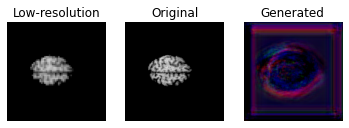

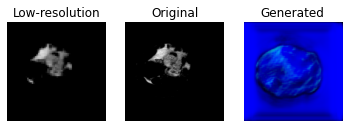

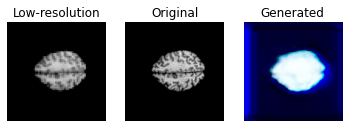

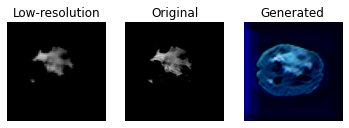

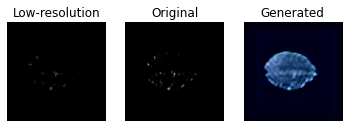

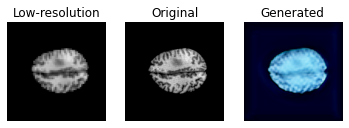

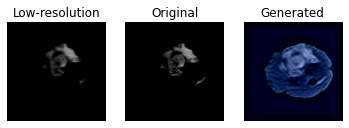

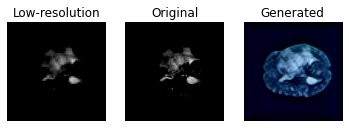

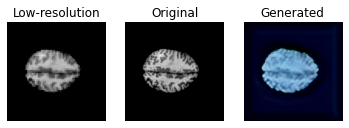

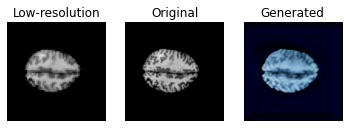

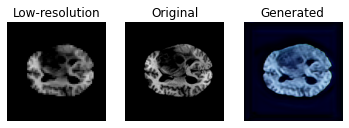

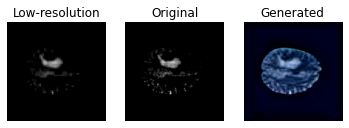

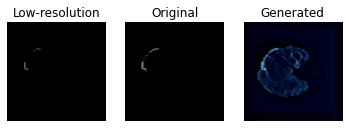

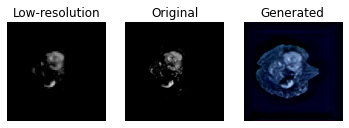

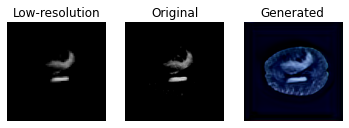

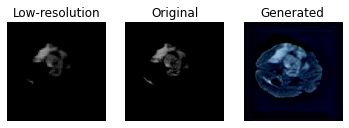

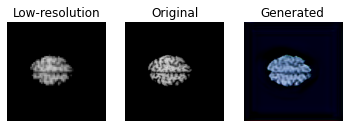

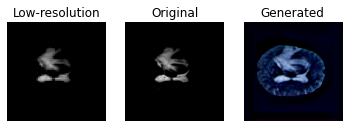

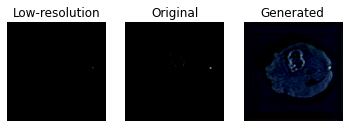

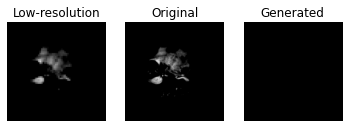

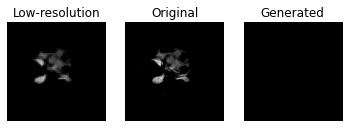

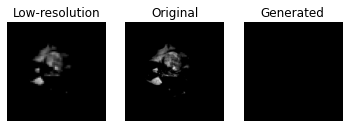

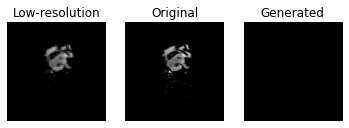

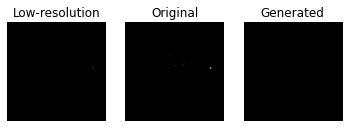

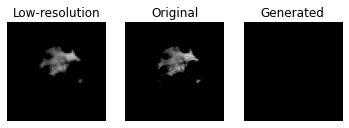

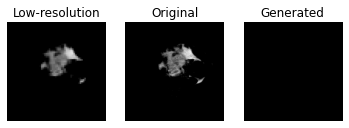

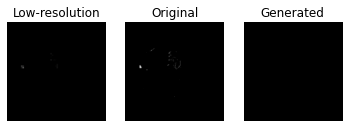

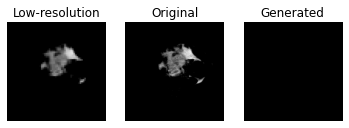

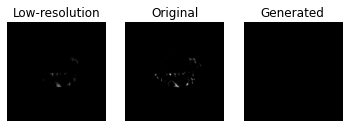

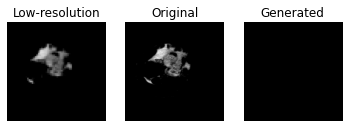

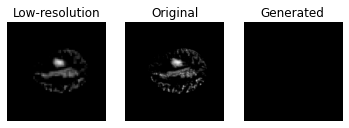

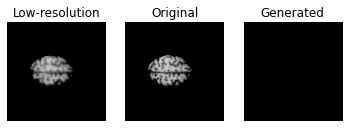

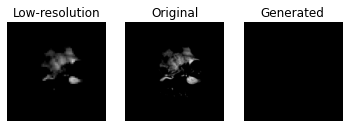

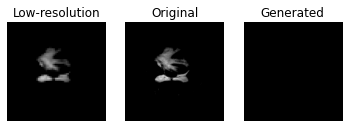

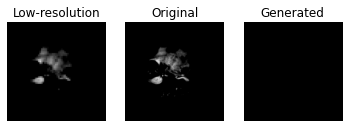

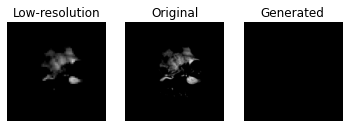

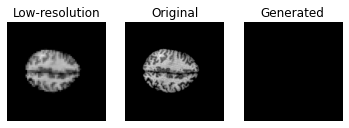

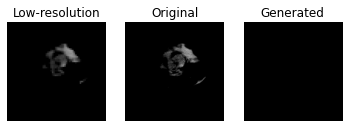

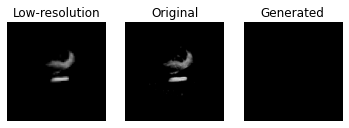

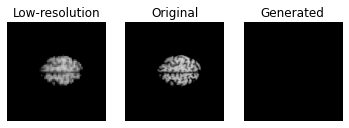

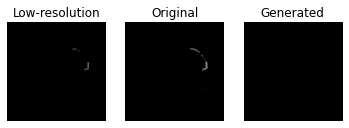

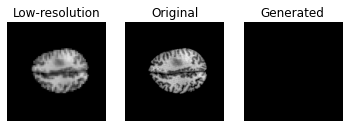

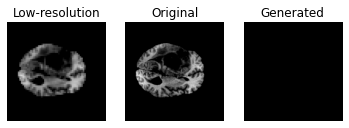

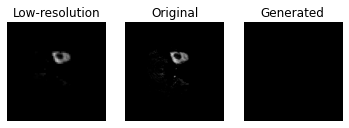

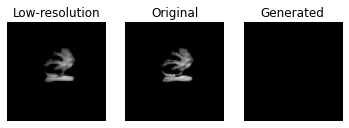

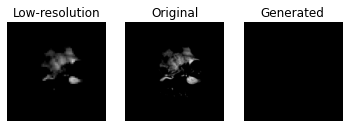

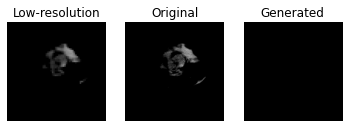

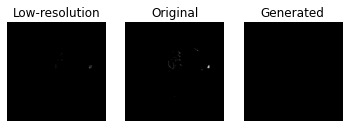

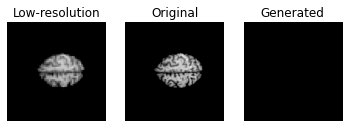

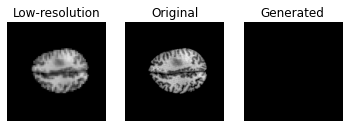

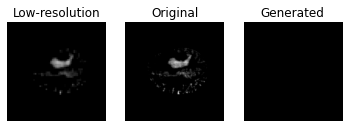

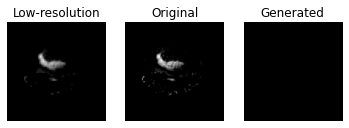

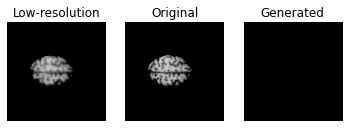

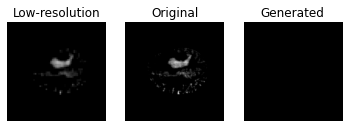

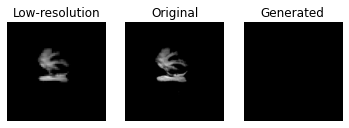

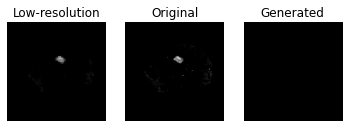

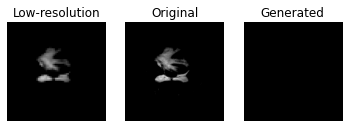

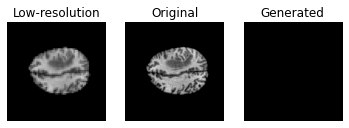

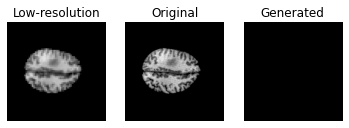

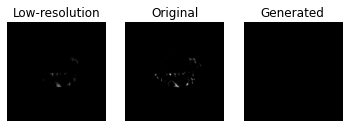

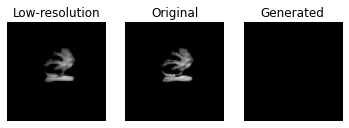

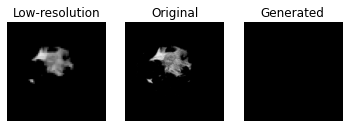

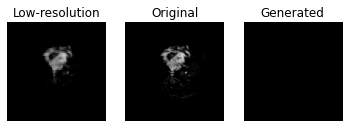

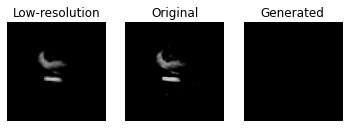

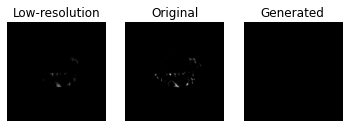

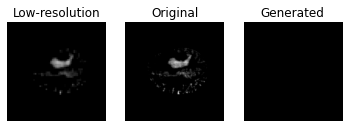

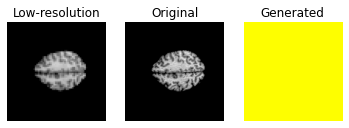

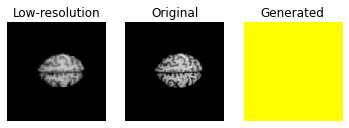

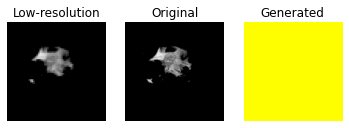

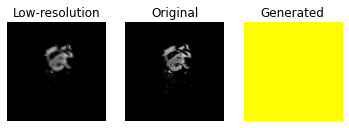

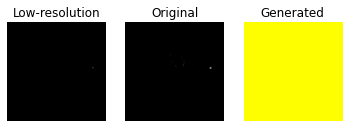

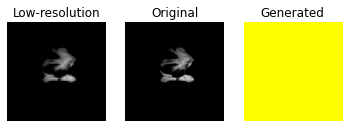

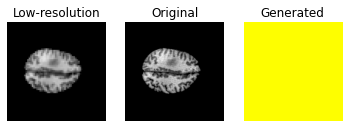

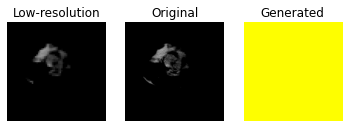

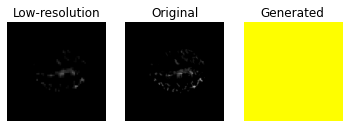

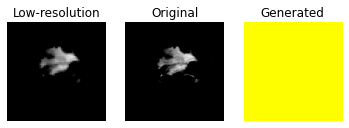

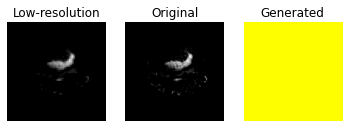

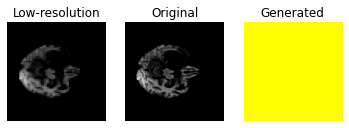

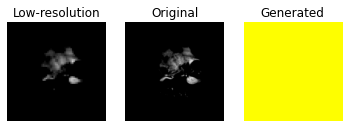

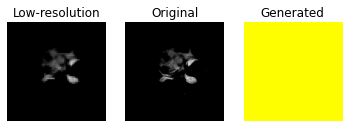

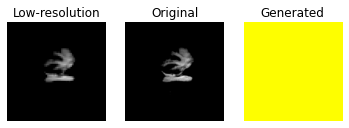

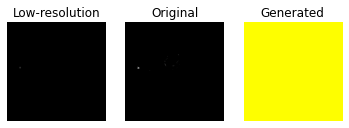

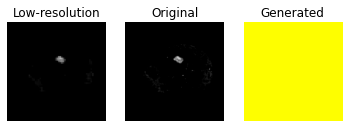

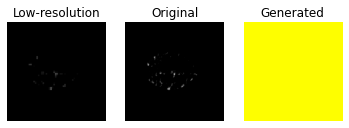

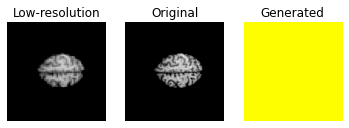

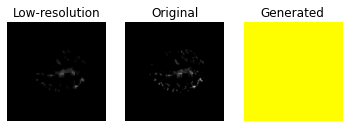

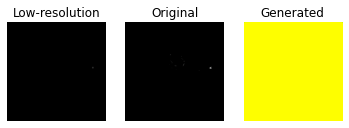

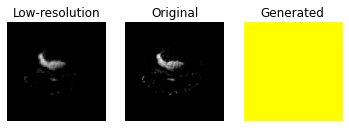

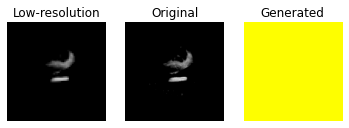

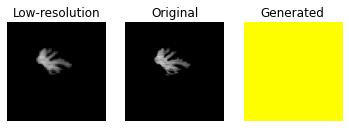

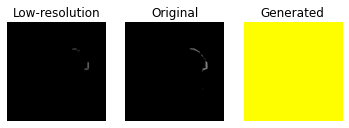

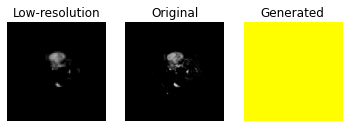

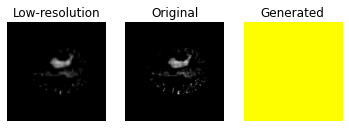

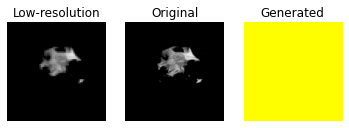

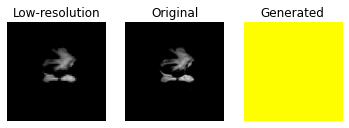

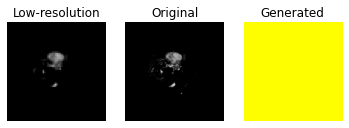

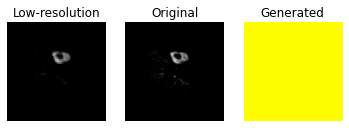

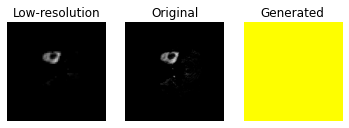

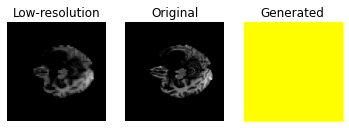

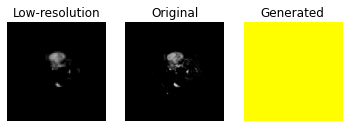

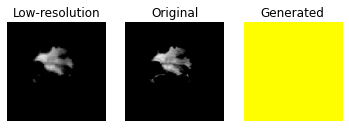

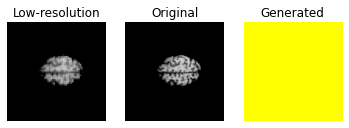

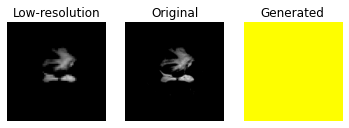

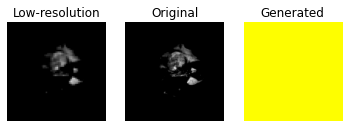

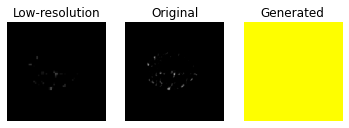

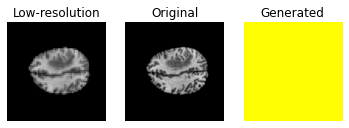

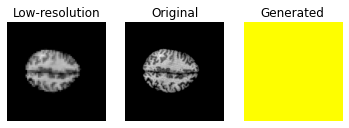

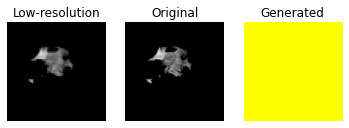

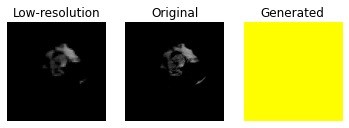

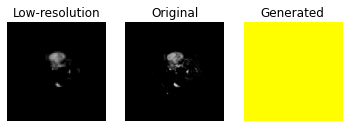

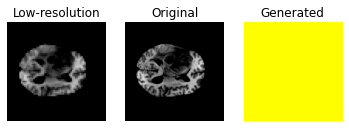

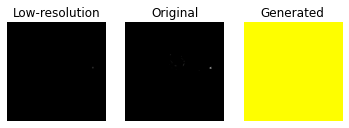

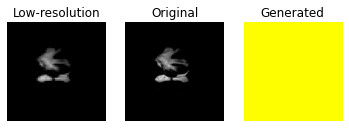

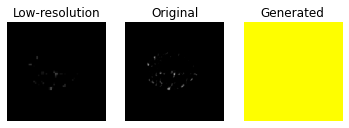

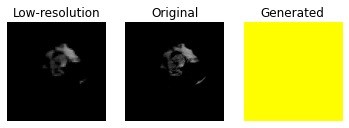

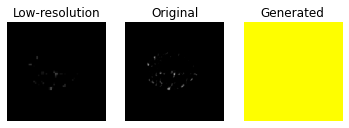

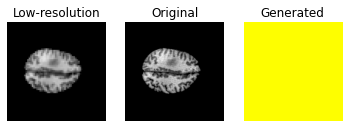

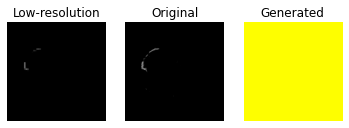

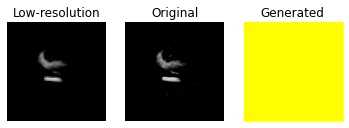

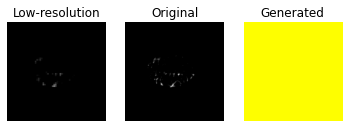

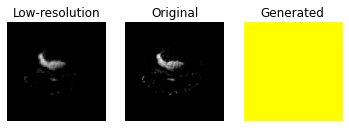

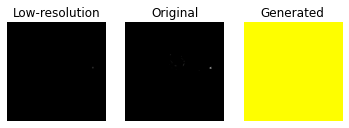

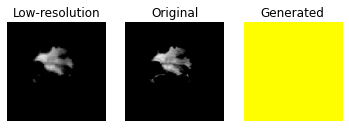

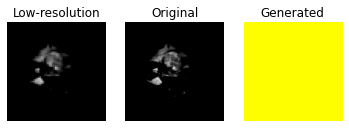

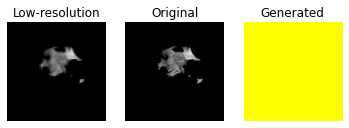

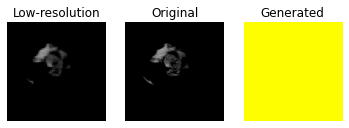

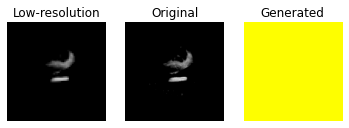

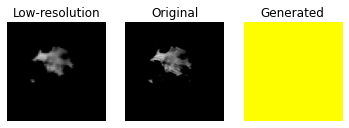

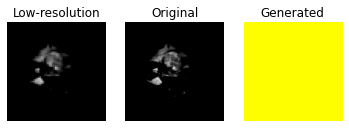

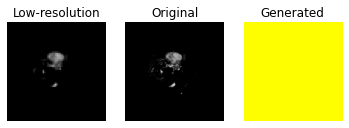

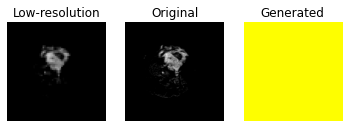

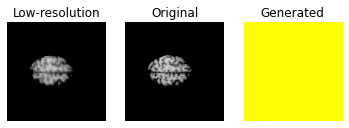

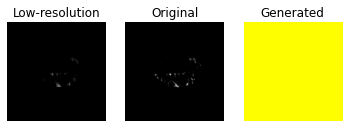

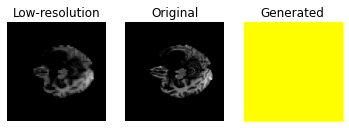

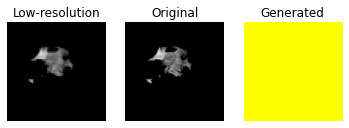

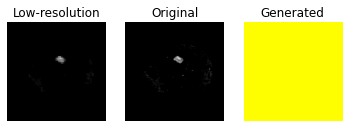

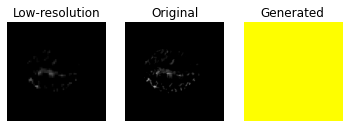

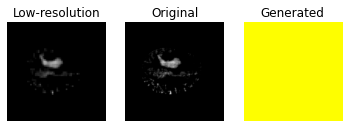

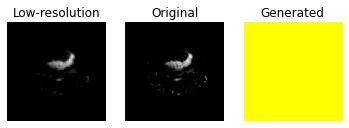

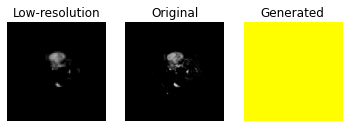

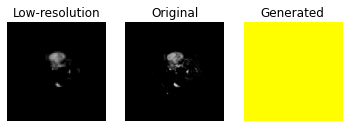

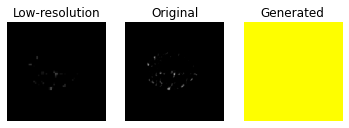

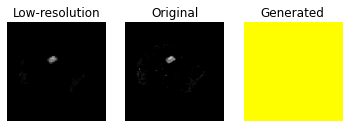

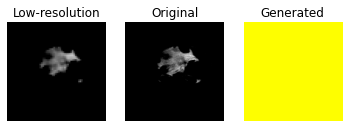

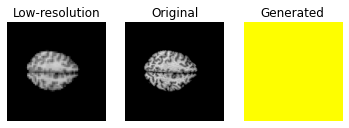

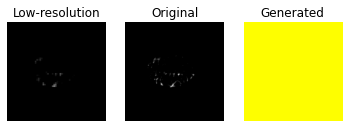

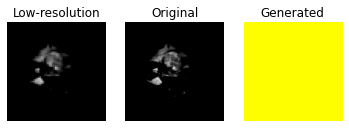

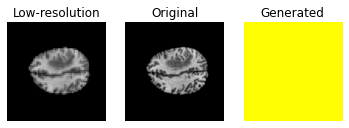

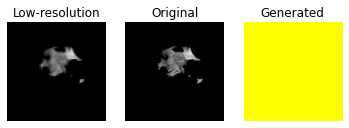

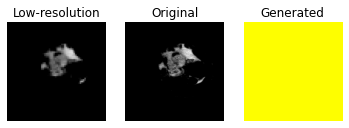

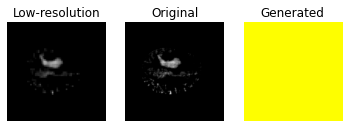

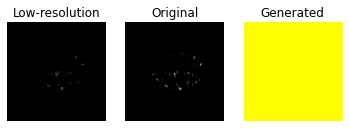

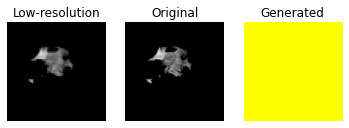

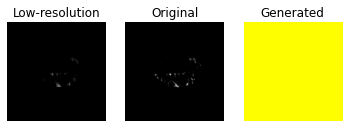

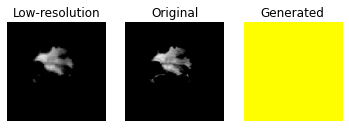

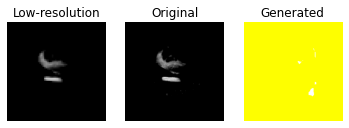

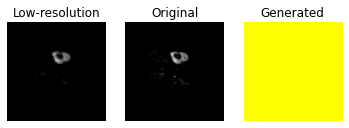

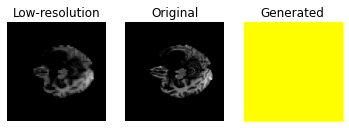

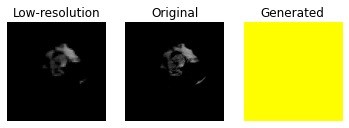

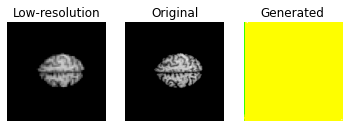

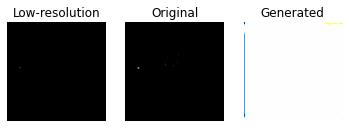

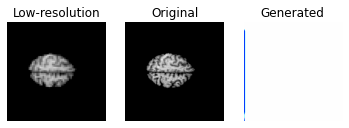

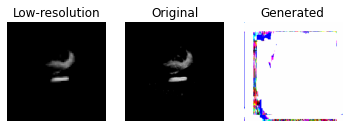

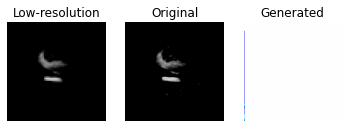

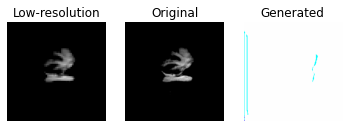

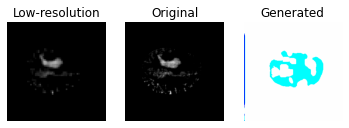

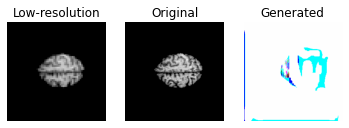

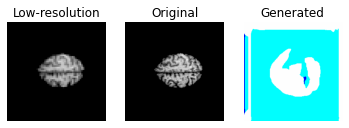

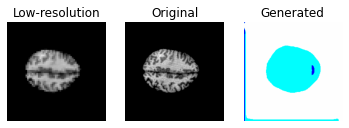

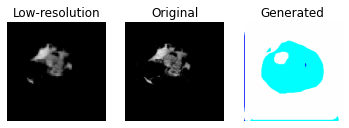

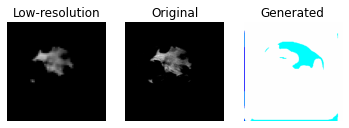

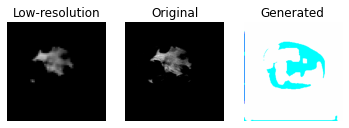

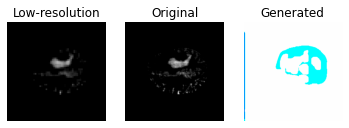

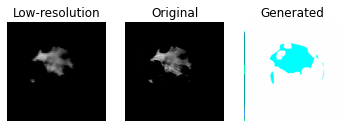

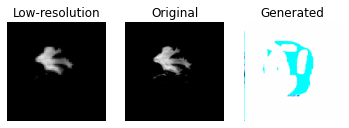

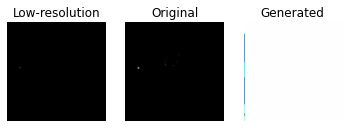

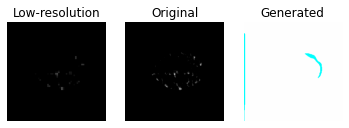

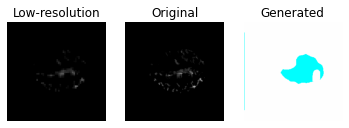

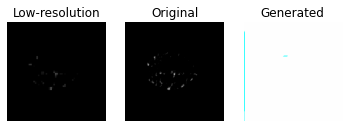

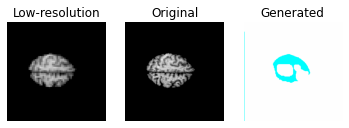

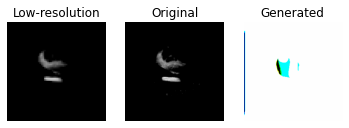

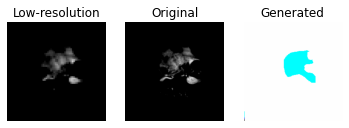

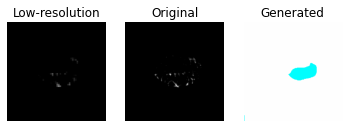

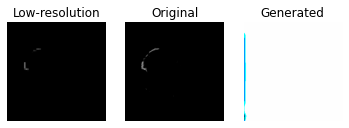

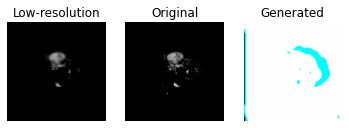

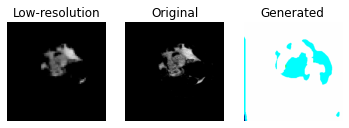

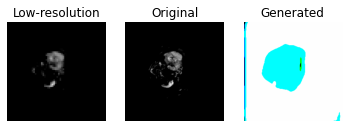

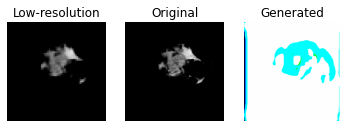

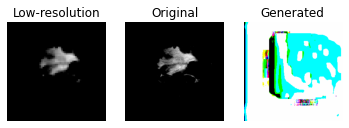

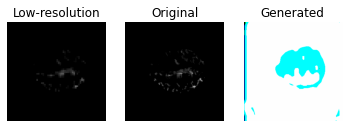

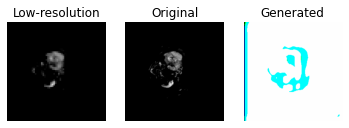

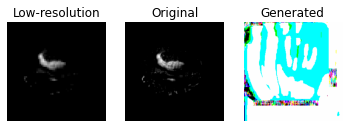

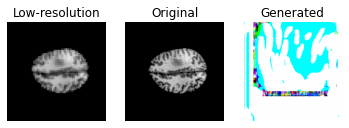

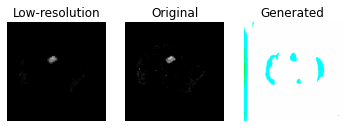

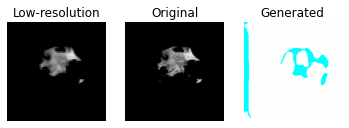

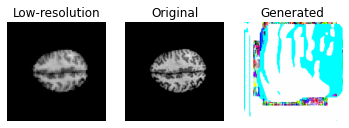

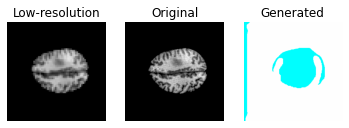

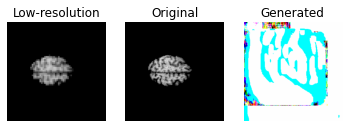

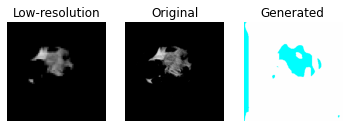

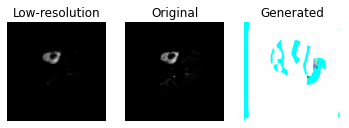

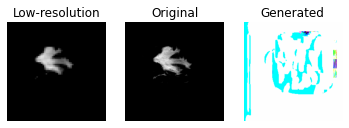

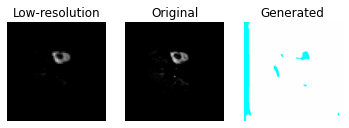

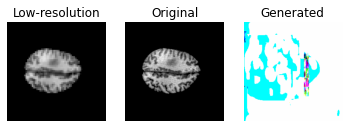

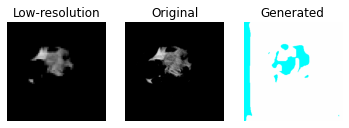

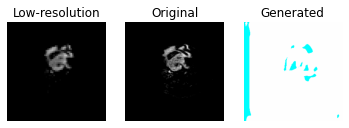

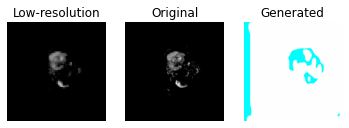

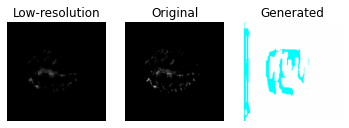

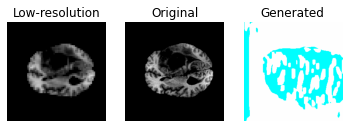

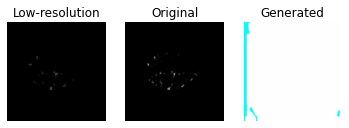

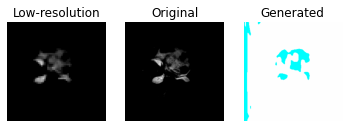

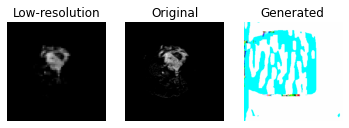

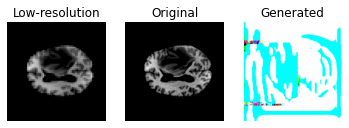

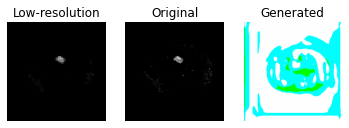

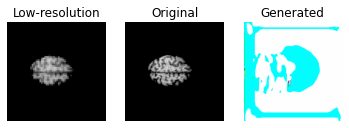

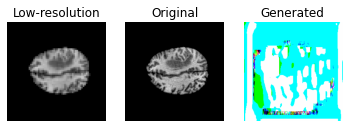

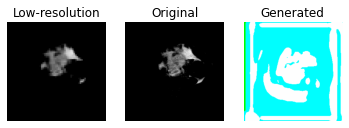

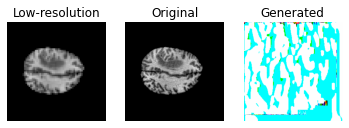

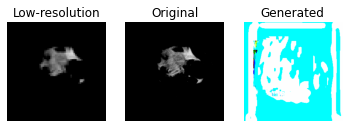

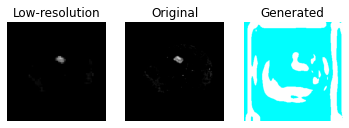

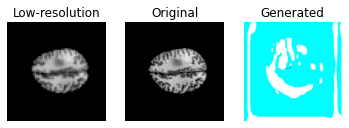

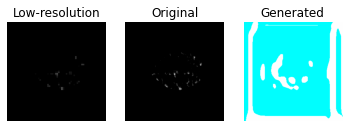

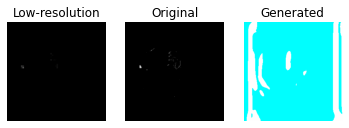

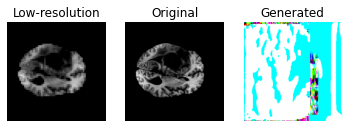

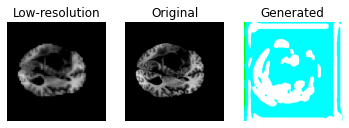

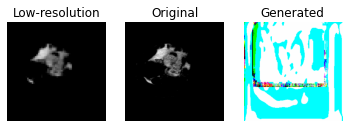

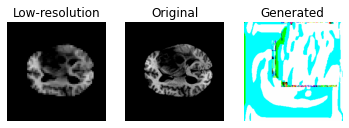

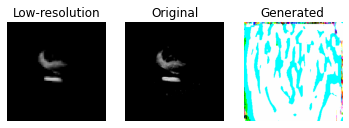

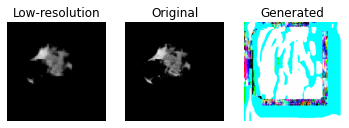

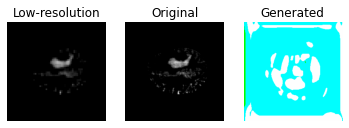

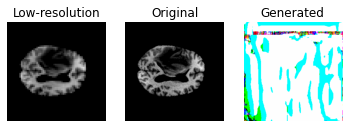

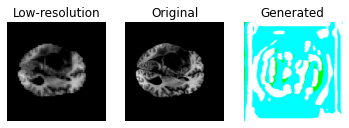

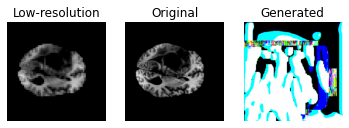

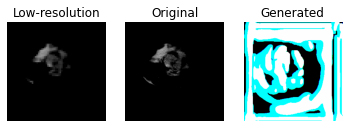

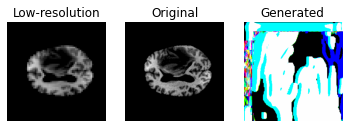

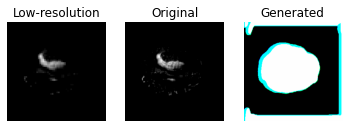

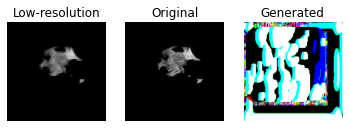

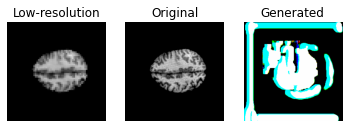

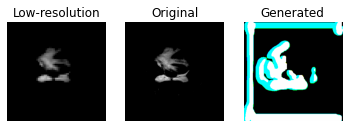

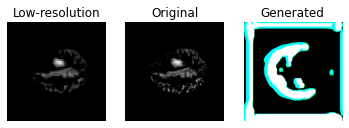

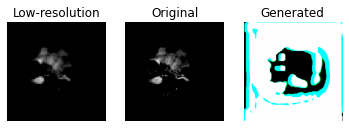

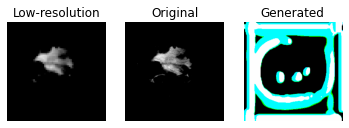

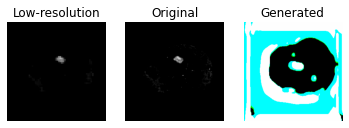

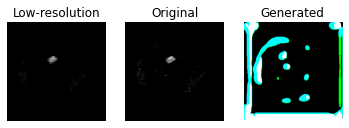

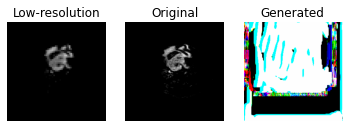

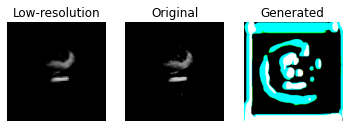

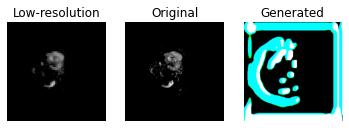

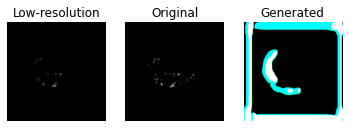

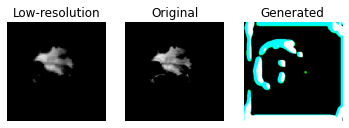

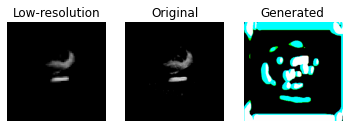

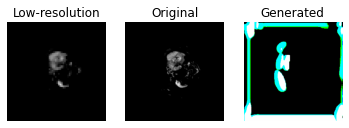

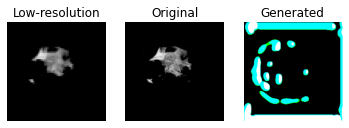

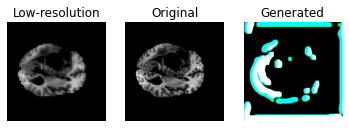

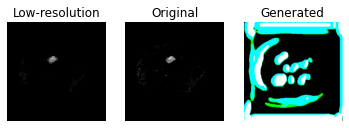

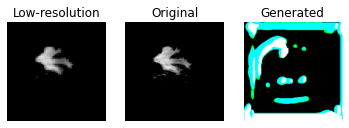

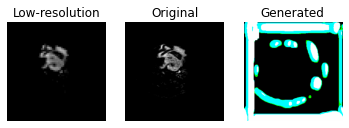

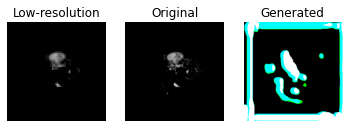

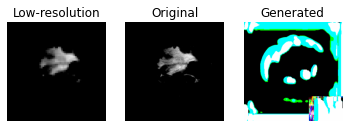

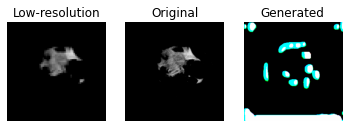

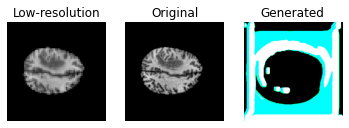

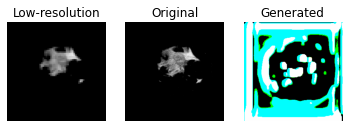

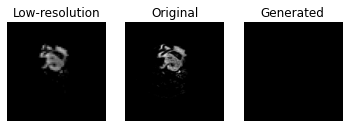

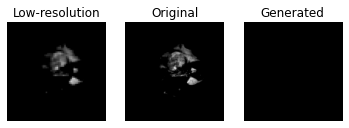

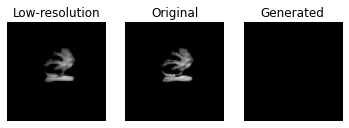

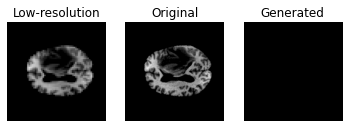

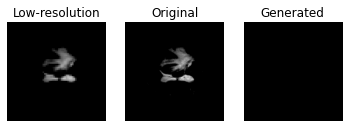

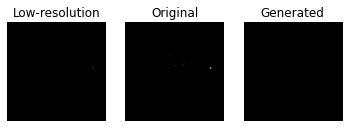

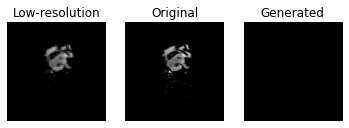

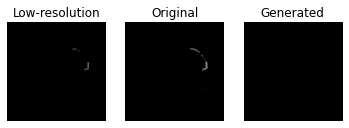

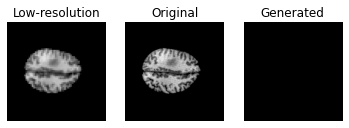

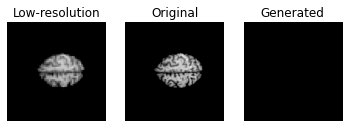

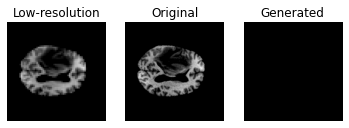

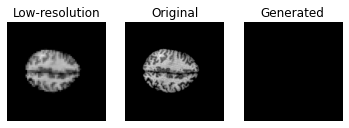

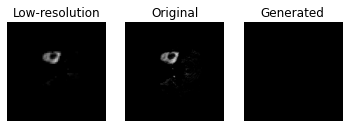

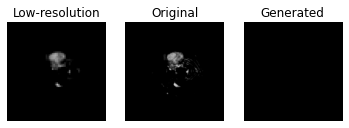

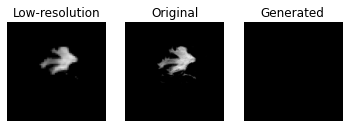

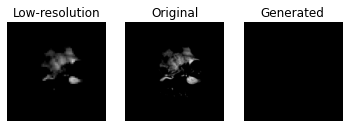

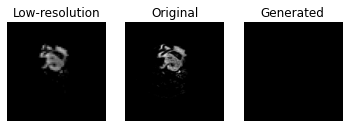

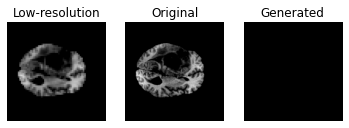

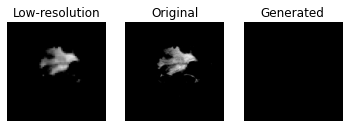

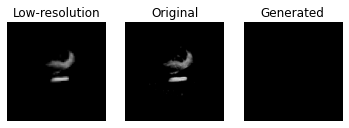

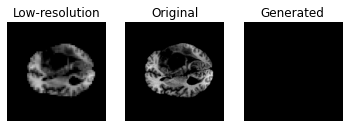

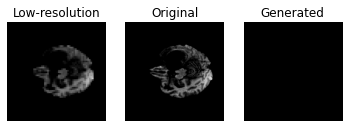

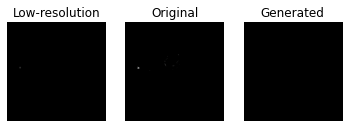

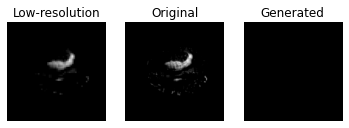

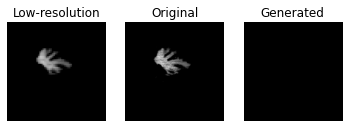

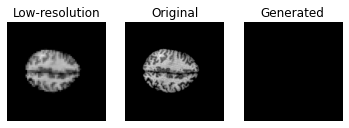

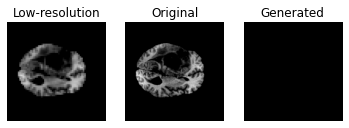

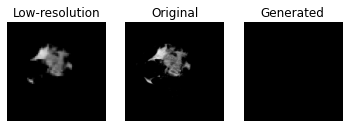

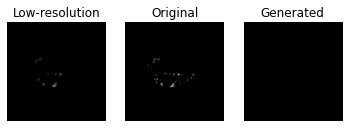

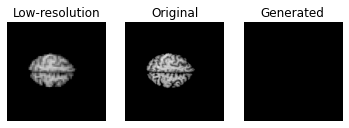

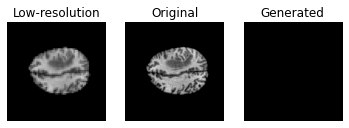

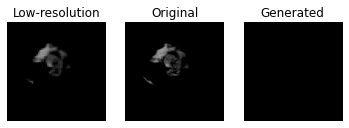

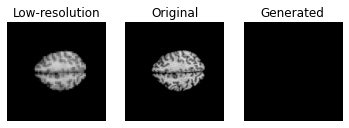

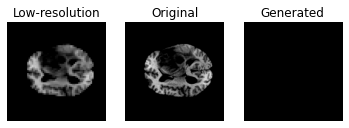

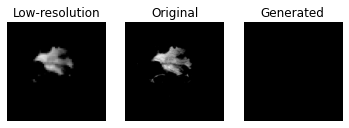

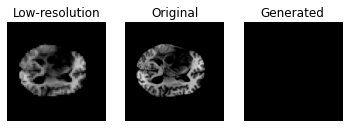

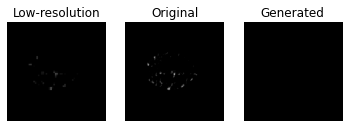

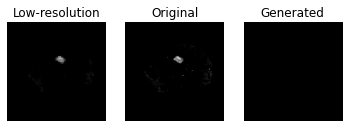

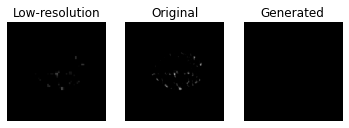

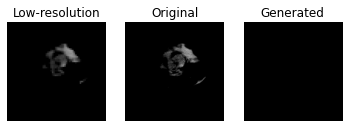

In [13]:
if __name__ == '__main__':
    data_dir = "/content/nii_images/*.*"
    epochs = 30000
    batch_size = 1
    mode = 'train'

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (64, 64, 1)
    high_resolution_shape = (256, 256, 1)

    # Common optimizer for all networks
    common_optimizer = Adam(0.0002, 0.5)

    if mode == 'train':
        # Build and compile VGG19 network to extract features
        vgg = build_vgg()
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build and compile the discriminator network
        discriminator = build_discriminator()
        discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build the generator network
        generator = build_generator()

        """
        Build and compile the adversarial model
        """

        # Input layers for high-resolution and low-resolution images
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator(input_low_resolution)

        # Extract feature maps of the generated images
        features = vgg(generated_high_resolution_images)

        # Make the discriminator network as non-trainable
        discriminator.trainable = False

        # Get the probability of generated high-resolution images
        probs = discriminator(generated_high_resolution_images)

        # Create and compile an adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

        # Add Tensorboard
        tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
        tensorboard.set_model(generator)
        tensorboard.set_model(discriminator)

        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            """
            Train the discriminator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Generate high-resolution images from low-resolution images
            generated_high_resolution_images = generator.predict(low_resolution_images)

            # Generate batch of real and fake labels
            real_labels = np.ones((batch_size, 16, 16, 1))
            fake_labels = np.zeros((batch_size, 16, 16, 1))

            # Train the discriminator network on real and fake images
            d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

            # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss:", d_loss)

            """
            Train the generator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Extract feature maps for real high-resolution images
            image_features = vgg.predict(high_resolution_images)

            # Train the generator network
            g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                             [real_labels, image_features])

            print("g_loss:", g_loss)

            # Write the losses to Tensorboard
            # write_log(tensorboard, 'g_loss', g_loss[0], epoch)
            # write_log(tensorboard, 'd_loss', d_loss[0], epoch)

            # Sample and save images after every 100 epochs
            if epoch % 100 == 0:
                high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              low_resolution_shape=low_resolution_shape,
                                                                              high_resolution_shape=high_resolution_shape)
                # Normalize images
                high_resolution_images = high_resolution_images / 127.5 - 1.
                low_resolution_images = low_resolution_images / 127.5 - 1.

                generated_images = generator.predict_on_batch(low_resolution_images)

                for index, img in enumerate(generated_images):
                    save_images(low_resolution_images[index], high_resolution_images[index], img,
                                path="/content/results/img_{}_{}".format(epoch, index))

        # Save models
        generator.save_weights("generator.h5")
        discriminator.save_weights("discriminator.h5")

    if mode == 'predict':
        # Build and compile the discriminator network
        discriminator = build_discriminator()

        # Build the generator network
        generator = build_generator()

        # Load models
        generator.load_weights("generator.h5")
        discriminator.load_weights("discriminator.h5")

        # Get 10 random images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        # Generate high-resolution images from low-resolution images
        generated_images = generator.predict_on_batch(low_resolution_images)

        # Save images
        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img, 
                        path="/content/results/gen_{}".format(index))